In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


Loaded 43520 images
Dataset type test label type: species


Loaded 5270 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 etvcjp2m


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                      | 0/5208 [00:00<?, ?it/s]

  0%|                                                                                                              | 1/5208 [00:00<58:11,  1.49it/s]

  0%|                                                                                                              | 3/5208 [00:00<21:12,  4.09it/s]

  0%|                                                                                                              | 5/5208 [00:01<14:24,  6.02it/s]

  0%|▏                                                                                                             | 7/5208 [00:01<11:42,  7.40it/s]

  0%|▏                                                                                                             | 9/5208 [00:01<10:18,  8.40it/s]

  0%|▏                                                                                                            | 11/5208 [00:01<09:30,  9.12it/s]

  0%|▎                                                                                                            | 13/5208 [00:01<09:00,  9.62it/s]

  0%|▎                                                                                                            | 15/5208 [00:01<08:40,  9.98it/s]

  0%|▎                                                                                                            | 17/5208 [00:02<08:27, 10.22it/s]

  0%|▍                                                                                                            | 19/5208 [00:02<08:18, 10.40it/s]

  0%|▍                                                                                                            | 21/5208 [00:02<08:12, 10.53it/s]

  0%|▍                                                                                                            | 23/5208 [00:02<08:08, 10.61it/s]

  0%|▌                                                                                                            | 25/5208 [00:02<08:05, 10.67it/s]

  1%|▌                                                                                                            | 27/5208 [00:03<08:03, 10.72it/s]

  1%|▌                                                                                                            | 29/5208 [00:03<08:01, 10.75it/s]

  1%|▋                                                                                                            | 31/5208 [00:03<08:01, 10.76it/s]

  1%|▋                                                                                                            | 33/5208 [00:03<08:00, 10.78it/s]

  1%|▋                                                                                                            | 35/5208 [00:03<07:59, 10.79it/s]

  1%|▊                                                                                                            | 37/5208 [00:04<07:59, 10.79it/s]

  1%|▊                                                                                                            | 39/5208 [00:04<07:58, 10.80it/s]

  1%|▊                                                                                                            | 41/5208 [00:04<07:58, 10.80it/s]

  1%|▉                                                                                                            | 43/5208 [00:04<07:57, 10.81it/s]

  1%|▉                                                                                                            | 45/5208 [00:04<07:57, 10.81it/s]

  1%|▉                                                                                                            | 47/5208 [00:04<07:57, 10.81it/s]

  1%|█                                                                                                            | 49/5208 [00:05<07:57, 10.81it/s]

  1%|█                                                                                                            | 51/5208 [00:05<07:57, 10.81it/s]

  1%|█                                                                                                            | 53/5208 [00:05<07:56, 10.81it/s]

  1%|█▏                                                                                                           | 55/5208 [00:05<07:56, 10.82it/s]

  1%|█▏                                                                                                           | 57/5208 [00:05<07:56, 10.82it/s]

  1%|█▏                                                                                                           | 59/5208 [00:06<07:56, 10.81it/s]

  1%|█▎                                                                                                           | 61/5208 [00:06<07:55, 10.81it/s]

  1%|█▎                                                                                                           | 63/5208 [00:06<07:55, 10.81it/s]

  1%|█▎                                                                                                           | 65/5208 [00:06<07:55, 10.81it/s]

  1%|█▍                                                                                                           | 67/5208 [00:06<07:55, 10.81it/s]

  1%|█▍                                                                                                           | 69/5208 [00:06<07:55, 10.81it/s]

  1%|█▍                                                                                                           | 71/5208 [00:07<07:54, 10.82it/s]

  1%|█▌                                                                                                           | 73/5208 [00:07<07:55, 10.81it/s]

  1%|█▌                                                                                                           | 75/5208 [00:07<07:54, 10.81it/s]

  1%|█▌                                                                                                           | 77/5208 [00:07<07:54, 10.81it/s]

  2%|█▋                                                                                                           | 79/5208 [00:07<07:54, 10.81it/s]

  2%|█▋                                                                                                           | 81/5208 [00:08<07:54, 10.81it/s]

  2%|█▋                                                                                                           | 83/5208 [00:08<07:54, 10.81it/s]

  2%|█▊                                                                                                           | 85/5208 [00:08<07:53, 10.81it/s]

  2%|█▊                                                                                                           | 87/5208 [00:08<07:53, 10.80it/s]

  2%|█▊                                                                                                           | 89/5208 [00:08<07:53, 10.81it/s]

  2%|█▉                                                                                                           | 91/5208 [00:09<07:53, 10.81it/s]

  2%|█▉                                                                                                           | 93/5208 [00:09<07:53, 10.81it/s]

  2%|█▉                                                                                                           | 95/5208 [00:09<07:53, 10.81it/s]

  2%|██                                                                                                           | 97/5208 [00:09<07:52, 10.81it/s]

  2%|██                                                                                                           | 99/5208 [00:09<07:52, 10.81it/s]

  2%|██                                                                                                          | 101/5208 [00:09<07:52, 10.81it/s]

  2%|██▏                                                                                                         | 103/5208 [00:10<07:52, 10.81it/s]

  2%|██▏                                                                                                         | 105/5208 [00:10<07:52, 10.81it/s]

  2%|██▏                                                                                                         | 107/5208 [00:10<07:52, 10.81it/s]

  2%|██▎                                                                                                         | 109/5208 [00:10<07:51, 10.81it/s]

  2%|██▎                                                                                                         | 111/5208 [00:10<07:51, 10.81it/s]

  2%|██▎                                                                                                         | 113/5208 [00:11<07:51, 10.81it/s]

  2%|██▍                                                                                                         | 115/5208 [00:11<07:51, 10.81it/s]

  2%|██▍                                                                                                         | 117/5208 [00:11<07:50, 10.81it/s]

  2%|██▍                                                                                                         | 119/5208 [00:11<07:50, 10.82it/s]

  2%|██▌                                                                                                         | 121/5208 [00:11<07:50, 10.81it/s]

  2%|██▌                                                                                                         | 123/5208 [00:11<07:50, 10.81it/s]

  2%|██▌                                                                                                         | 125/5208 [00:12<07:49, 10.82it/s]

  2%|██▋                                                                                                         | 127/5208 [00:12<07:49, 10.82it/s]

  2%|██▋                                                                                                         | 129/5208 [00:12<07:49, 10.81it/s]

  3%|██▋                                                                                                         | 131/5208 [00:12<07:49, 10.82it/s]

  3%|██▊                                                                                                         | 133/5208 [00:12<07:49, 10.82it/s]

  3%|██▊                                                                                                         | 135/5208 [00:13<07:49, 10.81it/s]

  3%|██▊                                                                                                         | 137/5208 [00:13<07:48, 10.82it/s]

  3%|██▉                                                                                                         | 139/5208 [00:13<07:48, 10.82it/s]

  3%|██▉                                                                                                         | 141/5208 [00:13<07:48, 10.82it/s]

  3%|██▉                                                                                                         | 143/5208 [00:13<07:48, 10.82it/s]

  3%|███                                                                                                         | 145/5208 [00:13<07:47, 10.82it/s]

  3%|███                                                                                                         | 147/5208 [00:14<07:47, 10.82it/s]

  3%|███                                                                                                         | 149/5208 [00:14<07:47, 10.82it/s]

  3%|███▏                                                                                                        | 151/5208 [00:14<07:47, 10.82it/s]

  3%|███▏                                                                                                        | 153/5208 [00:14<07:47, 10.82it/s]

  3%|███▏                                                                                                        | 155/5208 [00:14<07:47, 10.82it/s]

  3%|███▎                                                                                                        | 157/5208 [00:15<07:47, 10.82it/s]

  3%|███▎                                                                                                        | 159/5208 [00:15<07:46, 10.82it/s]

  3%|███▎                                                                                                        | 161/5208 [00:15<07:46, 10.82it/s]

  3%|███▍                                                                                                        | 163/5208 [00:15<07:46, 10.81it/s]

  3%|███▍                                                                                                        | 165/5208 [00:15<07:46, 10.82it/s]

  3%|███▍                                                                                                        | 167/5208 [00:16<07:45, 10.82it/s]

  3%|███▌                                                                                                        | 169/5208 [00:16<07:45, 10.82it/s]

  3%|███▌                                                                                                        | 171/5208 [00:16<07:45, 10.81it/s]

  3%|███▌                                                                                                        | 173/5208 [00:16<07:45, 10.82it/s]

  3%|███▋                                                                                                        | 175/5208 [00:16<07:45, 10.82it/s]

  3%|███▋                                                                                                        | 177/5208 [00:16<07:45, 10.81it/s]

  3%|███▋                                                                                                        | 179/5208 [00:17<07:45, 10.81it/s]

  3%|███▊                                                                                                        | 181/5208 [00:17<07:44, 10.82it/s]

  4%|███▊                                                                                                        | 183/5208 [00:17<07:44, 10.82it/s]

  4%|███▊                                                                                                        | 185/5208 [00:17<07:44, 10.81it/s]

  4%|███▉                                                                                                        | 187/5208 [00:17<07:44, 10.82it/s]

  4%|███▉                                                                                                        | 189/5208 [00:18<07:43, 10.82it/s]

  4%|███▉                                                                                                        | 191/5208 [00:18<07:43, 10.81it/s]

  4%|████                                                                                                        | 193/5208 [00:18<07:43, 10.82it/s]

  4%|████                                                                                                        | 195/5208 [00:18<07:43, 10.82it/s]

  4%|████                                                                                                        | 197/5208 [00:18<07:43, 10.82it/s]

  4%|████▏                                                                                                       | 199/5208 [00:18<07:43, 10.81it/s]

  4%|████▏                                                                                                       | 201/5208 [00:19<07:43, 10.81it/s]

  4%|████▏                                                                                                       | 203/5208 [00:19<07:42, 10.81it/s]

  4%|████▎                                                                                                       | 205/5208 [00:19<07:42, 10.81it/s]

  4%|████▎                                                                                                       | 207/5208 [00:19<07:42, 10.81it/s]

  4%|████▎                                                                                                       | 209/5208 [00:19<07:42, 10.81it/s]

  4%|████▍                                                                                                       | 211/5208 [00:20<07:42, 10.82it/s]

  4%|████▍                                                                                                       | 213/5208 [00:20<07:42, 10.81it/s]

  4%|████▍                                                                                                       | 215/5208 [00:20<07:41, 10.81it/s]

  4%|████▌                                                                                                       | 217/5208 [00:20<07:41, 10.81it/s]

  4%|████▌                                                                                                       | 219/5208 [00:20<07:41, 10.81it/s]

  4%|████▌                                                                                                       | 221/5208 [00:21<07:41, 10.81it/s]

  4%|████▌                                                                                                       | 223/5208 [00:21<07:41, 10.81it/s]

  4%|████▋                                                                                                       | 225/5208 [00:21<07:40, 10.81it/s]

  4%|████▋                                                                                                       | 227/5208 [00:21<07:40, 10.81it/s]

  4%|████▋                                                                                                       | 229/5208 [00:21<07:40, 10.81it/s]

  4%|████▊                                                                                                       | 231/5208 [00:21<07:40, 10.81it/s]

  4%|████▊                                                                                                       | 233/5208 [00:22<07:40, 10.81it/s]

  5%|████▊                                                                                                       | 235/5208 [00:22<07:40, 10.81it/s]

  5%|████▉                                                                                                       | 237/5208 [00:22<07:39, 10.81it/s]

  5%|████▉                                                                                                       | 239/5208 [00:22<07:39, 10.81it/s]

  5%|████▉                                                                                                       | 241/5208 [00:22<07:39, 10.80it/s]

  5%|█████                                                                                                       | 243/5208 [00:23<07:39, 10.80it/s]

  5%|█████                                                                                                       | 245/5208 [00:23<07:39, 10.81it/s]

  5%|█████                                                                                                       | 247/5208 [00:23<07:39, 10.80it/s]

  5%|█████▏                                                                                                      | 249/5208 [00:23<07:39, 10.80it/s]

  5%|█████▏                                                                                                      | 251/5208 [00:23<07:39, 10.80it/s]

  5%|█████▏                                                                                                      | 253/5208 [00:23<07:38, 10.80it/s]

  5%|█████▎                                                                                                      | 255/5208 [00:24<07:38, 10.81it/s]

  5%|█████▎                                                                                                      | 257/5208 [00:24<07:38, 10.81it/s]

  5%|█████▎                                                                                                      | 259/5208 [00:24<07:37, 10.81it/s]

  5%|█████▍                                                                                                      | 261/5208 [00:24<07:37, 10.81it/s]

  5%|█████▍                                                                                                      | 263/5208 [00:24<07:37, 10.80it/s]

  5%|█████▍                                                                                                      | 265/5208 [00:25<07:37, 10.81it/s]

  5%|█████▌                                                                                                      | 267/5208 [00:25<07:37, 10.81it/s]

  5%|█████▌                                                                                                      | 269/5208 [00:25<07:36, 10.81it/s]

  5%|█████▌                                                                                                      | 271/5208 [00:25<07:36, 10.81it/s]

  5%|█████▋                                                                                                      | 273/5208 [00:25<07:36, 10.81it/s]

  5%|█████▋                                                                                                      | 275/5208 [00:26<07:36, 10.81it/s]

  5%|█████▋                                                                                                      | 277/5208 [00:26<07:36, 10.81it/s]

  5%|█████▊                                                                                                      | 279/5208 [00:26<07:36, 10.81it/s]

  5%|█████▊                                                                                                      | 281/5208 [00:26<07:35, 10.81it/s]

  5%|█████▊                                                                                                      | 283/5208 [00:26<07:36, 10.80it/s]

  5%|█████▉                                                                                                      | 285/5208 [00:26<07:35, 10.80it/s]

  6%|█████▉                                                                                                      | 287/5208 [00:27<07:35, 10.81it/s]

  6%|█████▉                                                                                                      | 289/5208 [00:27<07:35, 10.81it/s]

  6%|██████                                                                                                      | 291/5208 [00:27<07:35, 10.81it/s]

  6%|██████                                                                                                      | 293/5208 [00:27<07:34, 10.81it/s]

  6%|██████                                                                                                      | 295/5208 [00:27<07:34, 10.80it/s]

  6%|██████▏                                                                                                     | 297/5208 [00:28<07:34, 10.80it/s]

  6%|██████▏                                                                                                     | 299/5208 [00:28<07:34, 10.80it/s]

  6%|██████▏                                                                                                     | 301/5208 [00:28<07:34, 10.81it/s]

  6%|██████▎                                                                                                     | 303/5208 [00:28<07:33, 10.80it/s]

  6%|██████▎                                                                                                     | 305/5208 [00:28<07:34, 10.80it/s]

  6%|██████▎                                                                                                     | 307/5208 [00:28<07:33, 10.80it/s]

  6%|██████▍                                                                                                     | 309/5208 [00:29<07:33, 10.80it/s]

  6%|██████▍                                                                                                     | 311/5208 [00:29<07:33, 10.80it/s]

  6%|██████▍                                                                                                     | 313/5208 [00:29<07:33, 10.80it/s]

  6%|██████▌                                                                                                     | 315/5208 [00:29<07:32, 10.80it/s]

  6%|██████▌                                                                                                     | 317/5208 [00:29<07:33, 10.80it/s]

  6%|██████▌                                                                                                     | 319/5208 [00:30<07:32, 10.80it/s]

  6%|██████▋                                                                                                     | 321/5208 [00:30<07:32, 10.80it/s]

  6%|██████▋                                                                                                     | 323/5208 [00:30<07:32, 10.80it/s]

  6%|██████▋                                                                                                     | 325/5208 [00:30<07:32, 10.80it/s]

  6%|██████▊                                                                                                     | 327/5208 [00:30<07:31, 10.80it/s]

  6%|██████▊                                                                                                     | 329/5208 [00:31<07:31, 10.80it/s]

  6%|██████▊                                                                                                     | 331/5208 [00:31<07:31, 10.81it/s]

  6%|██████▉                                                                                                     | 333/5208 [00:31<07:31, 10.80it/s]

  6%|██████▉                                                                                                     | 335/5208 [00:31<07:31, 10.80it/s]

  6%|██████▉                                                                                                     | 337/5208 [00:31<07:30, 10.80it/s]

  7%|███████                                                                                                     | 339/5208 [00:31<07:30, 10.80it/s]

  7%|███████                                                                                                     | 341/5208 [00:32<07:30, 10.80it/s]

  7%|███████                                                                                                     | 343/5208 [00:32<07:30, 10.81it/s]

  7%|███████▏                                                                                                    | 345/5208 [00:32<07:30, 10.81it/s]

  7%|███████▏                                                                                                    | 347/5208 [00:32<07:30, 10.80it/s]

  7%|███████▏                                                                                                    | 349/5208 [00:32<07:29, 10.80it/s]

  7%|███████▎                                                                                                    | 351/5208 [00:33<07:29, 10.80it/s]

  7%|███████▎                                                                                                    | 353/5208 [00:33<07:29, 10.80it/s]

  7%|███████▎                                                                                                    | 355/5208 [00:33<07:29, 10.80it/s]

  7%|███████▍                                                                                                    | 357/5208 [00:33<07:29, 10.80it/s]

  7%|███████▍                                                                                                    | 359/5208 [00:33<07:28, 10.80it/s]

  7%|███████▍                                                                                                    | 361/5208 [00:33<07:28, 10.81it/s]

  7%|███████▌                                                                                                    | 363/5208 [00:34<07:28, 10.81it/s]

  7%|███████▌                                                                                                    | 365/5208 [00:34<07:28, 10.81it/s]

  7%|███████▌                                                                                                    | 367/5208 [00:34<07:27, 10.81it/s]

  7%|███████▋                                                                                                    | 369/5208 [00:34<07:27, 10.81it/s]

  7%|███████▋                                                                                                    | 371/5208 [00:34<07:27, 10.81it/s]

  7%|███████▋                                                                                                    | 373/5208 [00:35<07:27, 10.81it/s]

  7%|███████▊                                                                                                    | 375/5208 [00:35<07:27, 10.81it/s]

  7%|███████▊                                                                                                    | 377/5208 [00:35<07:26, 10.81it/s]

  7%|███████▊                                                                                                    | 379/5208 [00:35<07:26, 10.81it/s]

  7%|███████▉                                                                                                    | 381/5208 [00:35<07:26, 10.81it/s]

  7%|███████▉                                                                                                    | 383/5208 [00:36<07:26, 10.81it/s]

  7%|███████▉                                                                                                    | 385/5208 [00:36<07:26, 10.81it/s]

  7%|████████                                                                                                    | 387/5208 [00:36<07:26, 10.81it/s]

  7%|████████                                                                                                    | 389/5208 [00:36<07:25, 10.81it/s]

  8%|████████                                                                                                    | 391/5208 [00:36<07:25, 10.81it/s]

  8%|████████▏                                                                                                   | 393/5208 [00:36<07:25, 10.81it/s]

  8%|████████▏                                                                                                   | 395/5208 [00:37<07:25, 10.81it/s]

  8%|████████▏                                                                                                   | 397/5208 [00:37<07:25, 10.81it/s]

  8%|████████▎                                                                                                   | 399/5208 [00:37<07:24, 10.81it/s]

  8%|████████▎                                                                                                   | 401/5208 [00:37<07:24, 10.81it/s]

  8%|████████▎                                                                                                   | 403/5208 [00:37<07:24, 10.80it/s]

  8%|████████▍                                                                                                   | 405/5208 [00:38<07:24, 10.81it/s]

  8%|████████▍                                                                                                   | 407/5208 [00:38<07:24, 10.81it/s]

  8%|████████▍                                                                                                   | 409/5208 [00:38<07:23, 10.81it/s]

  8%|████████▌                                                                                                   | 411/5208 [00:38<07:23, 10.81it/s]

  8%|████████▌                                                                                                   | 413/5208 [00:38<07:23, 10.81it/s]

  8%|████████▌                                                                                                   | 415/5208 [00:38<07:22, 10.82it/s]

  8%|████████▋                                                                                                   | 417/5208 [00:39<07:22, 10.82it/s]

  8%|████████▋                                                                                                   | 419/5208 [00:39<07:22, 10.82it/s]

  8%|████████▋                                                                                                   | 421/5208 [00:39<07:22, 10.82it/s]

  8%|████████▊                                                                                                   | 423/5208 [00:39<07:22, 10.82it/s]

  8%|████████▊                                                                                                   | 425/5208 [00:39<07:21, 10.82it/s]

  8%|████████▊                                                                                                   | 427/5208 [00:40<07:21, 10.82it/s]

  8%|████████▉                                                                                                   | 429/5208 [00:40<07:21, 10.82it/s]

  8%|████████▉                                                                                                   | 431/5208 [00:40<07:21, 10.82it/s]

  8%|████████▉                                                                                                   | 433/5208 [00:40<07:21, 10.83it/s]

  8%|█████████                                                                                                   | 435/5208 [00:40<07:20, 10.82it/s]

  8%|█████████                                                                                                   | 437/5208 [00:41<07:20, 10.82it/s]

  8%|█████████                                                                                                   | 439/5208 [00:41<07:20, 10.83it/s]

  8%|█████████▏                                                                                                  | 441/5208 [00:41<07:20, 10.83it/s]

  9%|█████████▏                                                                                                  | 443/5208 [00:41<07:20, 10.83it/s]

  9%|█████████▏                                                                                                  | 445/5208 [00:41<07:19, 10.83it/s]

  9%|█████████▎                                                                                                  | 447/5208 [00:41<07:19, 10.83it/s]

  9%|█████████▎                                                                                                  | 449/5208 [00:42<07:19, 10.83it/s]

  9%|█████████▎                                                                                                  | 451/5208 [00:42<07:19, 10.83it/s]

  9%|█████████▍                                                                                                  | 453/5208 [00:42<07:19, 10.82it/s]

  9%|█████████▍                                                                                                  | 455/5208 [00:42<07:19, 10.82it/s]

  9%|█████████▍                                                                                                  | 457/5208 [00:42<07:18, 10.82it/s]

  9%|█████████▌                                                                                                  | 459/5208 [00:43<07:18, 10.82it/s]

  9%|█████████▌                                                                                                  | 461/5208 [00:43<07:18, 10.83it/s]

  9%|█████████▌                                                                                                  | 463/5208 [00:43<07:18, 10.83it/s]

  9%|█████████▋                                                                                                  | 465/5208 [00:43<07:18, 10.83it/s]

  9%|█████████▋                                                                                                  | 467/5208 [00:43<07:17, 10.83it/s]

  9%|█████████▋                                                                                                  | 469/5208 [00:43<07:17, 10.83it/s]

  9%|█████████▊                                                                                                  | 471/5208 [00:44<07:17, 10.83it/s]

  9%|█████████▊                                                                                                  | 473/5208 [00:44<07:17, 10.82it/s]

  9%|█████████▊                                                                                                  | 475/5208 [00:44<07:17, 10.82it/s]

  9%|█████████▉                                                                                                  | 477/5208 [00:44<07:17, 10.82it/s]

  9%|█████████▉                                                                                                  | 479/5208 [00:44<07:16, 10.82it/s]

  9%|█████████▉                                                                                                  | 481/5208 [00:45<07:16, 10.83it/s]

  9%|██████████                                                                                                  | 483/5208 [00:45<07:16, 10.82it/s]

  9%|██████████                                                                                                  | 485/5208 [00:45<07:16, 10.82it/s]

  9%|██████████                                                                                                  | 487/5208 [00:45<07:16, 10.82it/s]

  9%|██████████▏                                                                                                 | 489/5208 [00:45<07:15, 10.82it/s]

  9%|██████████▏                                                                                                 | 491/5208 [00:45<07:15, 10.82it/s]

  9%|██████████▏                                                                                                 | 493/5208 [00:46<07:15, 10.82it/s]

 10%|██████████▎                                                                                                 | 495/5208 [00:46<07:15, 10.82it/s]

 10%|██████████▎                                                                                                 | 497/5208 [00:46<07:15, 10.82it/s]

 10%|██████████▎                                                                                                 | 499/5208 [00:46<07:15, 10.82it/s]

 10%|██████████▍                                                                                                 | 501/5208 [00:46<07:14, 10.82it/s]

 10%|██████████▍                                                                                                 | 503/5208 [00:47<07:14, 10.82it/s]

 10%|██████████▍                                                                                                 | 505/5208 [00:47<07:15, 10.79it/s]

 10%|██████████▌                                                                                                 | 507/5208 [00:47<07:15, 10.79it/s]

 10%|██████████▌                                                                                                 | 509/5208 [00:47<07:14, 10.80it/s]

 10%|██████████▌                                                                                                 | 511/5208 [00:47<07:14, 10.80it/s]

 10%|██████████▋                                                                                                 | 513/5208 [00:48<07:14, 10.81it/s]

 10%|██████████▋                                                                                                 | 515/5208 [00:48<07:13, 10.82it/s]

 10%|██████████▋                                                                                                 | 517/5208 [00:48<07:13, 10.82it/s]

 10%|██████████▊                                                                                                 | 519/5208 [00:48<07:13, 10.82it/s]

 10%|██████████▊                                                                                                 | 521/5208 [00:48<07:13, 10.82it/s]

 10%|██████████▊                                                                                                 | 523/5208 [00:48<07:12, 10.82it/s]

 10%|██████████▉                                                                                                 | 525/5208 [00:49<07:12, 10.82it/s]

 10%|██████████▉                                                                                                 | 527/5208 [00:49<07:12, 10.82it/s]

 10%|██████████▉                                                                                                 | 529/5208 [00:49<07:12, 10.83it/s]

 10%|███████████                                                                                                 | 531/5208 [00:49<07:12, 10.82it/s]

 10%|███████████                                                                                                 | 533/5208 [00:49<07:12, 10.82it/s]

 10%|███████████                                                                                                 | 535/5208 [00:50<07:11, 10.82it/s]

 10%|███████████▏                                                                                                | 537/5208 [00:50<07:11, 10.82it/s]

 10%|███████████▏                                                                                                | 539/5208 [00:50<07:11, 10.82it/s]

 10%|███████████▏                                                                                                | 541/5208 [00:50<07:11, 10.81it/s]

 10%|███████████▎                                                                                                | 543/5208 [00:50<07:11, 10.82it/s]

 10%|███████████▎                                                                                                | 545/5208 [00:50<07:12, 10.78it/s]

 11%|███████████▎                                                                                                | 547/5208 [00:51<07:11, 10.80it/s]

 11%|███████████▍                                                                                                | 549/5208 [00:51<07:11, 10.80it/s]

 11%|███████████▍                                                                                                | 551/5208 [00:51<07:10, 10.81it/s]

 11%|███████████▍                                                                                                | 553/5208 [00:51<07:10, 10.81it/s]

 11%|███████████▌                                                                                                | 555/5208 [00:51<07:10, 10.82it/s]

 11%|███████████▌                                                                                                | 557/5208 [00:52<07:10, 10.81it/s]

 11%|███████████▌                                                                                                | 559/5208 [00:52<07:09, 10.81it/s]

 11%|███████████▋                                                                                                | 561/5208 [00:52<07:09, 10.82it/s]

 11%|███████████▋                                                                                                | 563/5208 [00:52<07:09, 10.82it/s]

 11%|███████████▋                                                                                                | 565/5208 [00:52<07:09, 10.82it/s]

 11%|███████████▊                                                                                                | 567/5208 [00:53<07:08, 10.82it/s]

 11%|███████████▊                                                                                                | 569/5208 [00:53<07:08, 10.82it/s]

 11%|███████████▊                                                                                                | 571/5208 [00:53<07:08, 10.82it/s]

 11%|███████████▉                                                                                                | 573/5208 [00:53<07:08, 10.82it/s]

 11%|███████████▉                                                                                                | 575/5208 [00:53<07:08, 10.82it/s]

 11%|███████████▉                                                                                                | 577/5208 [00:53<07:07, 10.82it/s]

 11%|████████████                                                                                                | 579/5208 [00:54<07:07, 10.82it/s]

 11%|████████████                                                                                                | 581/5208 [00:54<07:07, 10.83it/s]

 11%|████████████                                                                                                | 583/5208 [00:54<07:07, 10.82it/s]

 11%|████████████▏                                                                                               | 585/5208 [00:54<07:07, 10.82it/s]

 11%|████████████▏                                                                                               | 587/5208 [00:54<07:06, 10.82it/s]

 11%|████████████▏                                                                                               | 589/5208 [00:55<07:06, 10.82it/s]

 11%|████████████▎                                                                                               | 591/5208 [00:55<07:06, 10.82it/s]

 11%|████████████▎                                                                                               | 593/5208 [00:55<07:06, 10.82it/s]

 11%|████████████▎                                                                                               | 595/5208 [00:55<07:06, 10.82it/s]

 11%|████████████▍                                                                                               | 597/5208 [00:55<07:06, 10.82it/s]

 12%|████████████▍                                                                                               | 599/5208 [00:55<07:06, 10.82it/s]

 12%|████████████▍                                                                                               | 601/5208 [00:56<07:05, 10.82it/s]

 12%|████████████▌                                                                                               | 603/5208 [00:56<07:05, 10.82it/s]

 12%|████████████▌                                                                                               | 605/5208 [00:56<07:05, 10.82it/s]

 12%|████████████▌                                                                                               | 607/5208 [00:56<07:05, 10.82it/s]

 12%|████████████▋                                                                                               | 609/5208 [00:56<07:05, 10.82it/s]

 12%|████████████▋                                                                                               | 611/5208 [00:57<07:04, 10.82it/s]

 12%|████████████▋                                                                                               | 613/5208 [00:57<07:04, 10.82it/s]

 12%|████████████▊                                                                                               | 615/5208 [00:57<07:04, 10.82it/s]

 12%|████████████▊                                                                                               | 617/5208 [00:57<07:04, 10.82it/s]

 12%|████████████▊                                                                                               | 619/5208 [00:57<07:03, 10.82it/s]

 12%|████████████▉                                                                                               | 621/5208 [00:58<07:03, 10.83it/s]

 12%|████████████▉                                                                                               | 623/5208 [00:58<07:03, 10.83it/s]

 12%|████████████▉                                                                                               | 625/5208 [00:58<07:03, 10.83it/s]

 12%|█████████████                                                                                               | 627/5208 [00:58<07:02, 10.83it/s]

 12%|█████████████                                                                                               | 629/5208 [00:58<07:02, 10.83it/s]

 12%|█████████████                                                                                               | 631/5208 [00:58<07:02, 10.83it/s]

 12%|█████████████▏                                                                                              | 633/5208 [00:59<07:02, 10.84it/s]

 12%|█████████████▏                                                                                              | 635/5208 [00:59<07:01, 10.84it/s]

 12%|█████████████▏                                                                                              | 637/5208 [00:59<07:01, 10.84it/s]

 12%|█████████████▎                                                                                              | 639/5208 [00:59<07:01, 10.83it/s]

 12%|█████████████▎                                                                                              | 641/5208 [00:59<07:01, 10.83it/s]

 12%|█████████████▎                                                                                              | 643/5208 [01:00<07:01, 10.83it/s]

 12%|█████████████▍                                                                                              | 645/5208 [01:00<07:01, 10.83it/s]

 12%|█████████████▍                                                                                              | 647/5208 [01:00<07:01, 10.82it/s]

 12%|█████████████▍                                                                                              | 649/5208 [01:00<07:01, 10.83it/s]

 12%|█████████████▌                                                                                              | 651/5208 [01:00<07:00, 10.83it/s]

 13%|█████████████▌                                                                                              | 653/5208 [01:00<07:00, 10.83it/s]

 13%|█████████████▌                                                                                              | 655/5208 [01:01<07:00, 10.83it/s]

 13%|█████████████▌                                                                                              | 657/5208 [01:01<06:59, 10.84it/s]

 13%|█████████████▋                                                                                              | 659/5208 [01:01<06:59, 10.84it/s]

 13%|█████████████▋                                                                                              | 661/5208 [01:01<06:59, 10.84it/s]

 13%|█████████████▋                                                                                              | 663/5208 [01:01<06:59, 10.84it/s]

 13%|█████████████▊                                                                                              | 665/5208 [01:02<06:59, 10.84it/s]

 13%|█████████████▊                                                                                              | 667/5208 [01:02<06:58, 10.84it/s]

 13%|█████████████▊                                                                                              | 669/5208 [01:02<06:58, 10.84it/s]

 13%|█████████████▉                                                                                              | 671/5208 [01:02<06:58, 10.84it/s]

 13%|█████████████▉                                                                                              | 673/5208 [01:02<06:58, 10.84it/s]

 13%|█████████████▉                                                                                              | 675/5208 [01:02<06:58, 10.84it/s]

 13%|██████████████                                                                                              | 677/5208 [01:03<06:58, 10.83it/s]

 13%|██████████████                                                                                              | 679/5208 [01:03<06:58, 10.83it/s]

 13%|██████████████                                                                                              | 681/5208 [01:03<06:57, 10.84it/s]

 13%|██████████████▏                                                                                             | 683/5208 [01:03<06:57, 10.84it/s]

 13%|██████████████▏                                                                                             | 685/5208 [01:03<06:57, 10.84it/s]

 13%|██████████████▏                                                                                             | 687/5208 [01:04<06:57, 10.84it/s]

 13%|██████████████▎                                                                                             | 689/5208 [01:04<06:56, 10.84it/s]

 13%|██████████████▎                                                                                             | 691/5208 [01:04<06:56, 10.84it/s]

 13%|██████████████▎                                                                                             | 693/5208 [01:04<06:56, 10.84it/s]

 13%|██████████████▍                                                                                             | 695/5208 [01:04<06:56, 10.84it/s]

 13%|██████████████▍                                                                                             | 697/5208 [01:05<06:56, 10.84it/s]

 13%|██████████████▍                                                                                             | 699/5208 [01:05<06:56, 10.84it/s]

 13%|██████████████▌                                                                                             | 701/5208 [01:05<06:55, 10.84it/s]

 13%|██████████████▌                                                                                             | 703/5208 [01:05<06:55, 10.84it/s]

 14%|██████████████▌                                                                                             | 705/5208 [01:05<06:55, 10.84it/s]

 14%|██████████████▋                                                                                             | 707/5208 [01:05<06:55, 10.84it/s]

 14%|██████████████▋                                                                                             | 709/5208 [01:06<06:55, 10.84it/s]

 14%|██████████████▋                                                                                             | 711/5208 [01:06<06:54, 10.84it/s]

 14%|██████████████▊                                                                                             | 713/5208 [01:06<06:54, 10.84it/s]

 14%|██████████████▊                                                                                             | 715/5208 [01:06<06:54, 10.84it/s]

 14%|██████████████▊                                                                                             | 717/5208 [01:06<06:54, 10.83it/s]

 14%|██████████████▉                                                                                             | 719/5208 [01:07<06:54, 10.83it/s]

 14%|██████████████▉                                                                                             | 721/5208 [01:07<06:54, 10.83it/s]

 14%|██████████████▉                                                                                             | 723/5208 [01:07<06:54, 10.83it/s]

 14%|███████████████                                                                                             | 725/5208 [01:07<06:53, 10.83it/s]

 14%|███████████████                                                                                             | 727/5208 [01:07<06:54, 10.81it/s]

 14%|███████████████                                                                                             | 729/5208 [01:07<06:53, 10.82it/s]

 14%|███████████████▏                                                                                            | 731/5208 [01:08<06:53, 10.83it/s]

 14%|███████████████▏                                                                                            | 733/5208 [01:08<06:53, 10.82it/s]

 14%|███████████████▏                                                                                            | 735/5208 [01:08<06:53, 10.83it/s]

 14%|███████████████▎                                                                                            | 737/5208 [01:08<06:52, 10.83it/s]

 14%|███████████████▎                                                                                            | 739/5208 [01:08<06:52, 10.83it/s]

 14%|███████████████▎                                                                                            | 741/5208 [01:09<06:52, 10.83it/s]

 14%|███████████████▍                                                                                            | 743/5208 [01:09<06:52, 10.83it/s]

 14%|███████████████▍                                                                                            | 745/5208 [01:09<06:51, 10.83it/s]

 14%|███████████████▍                                                                                            | 747/5208 [01:09<06:51, 10.84it/s]

 14%|███████████████▌                                                                                            | 749/5208 [01:09<06:51, 10.84it/s]

 14%|███████████████▌                                                                                            | 751/5208 [01:10<06:51, 10.84it/s]

 14%|███████████████▌                                                                                            | 753/5208 [01:10<06:51, 10.83it/s]

 14%|███████████████▋                                                                                            | 755/5208 [01:10<06:51, 10.83it/s]

 15%|███████████████▋                                                                                            | 757/5208 [01:10<06:50, 10.84it/s]

 15%|███████████████▋                                                                                            | 759/5208 [01:10<06:50, 10.84it/s]

 15%|███████████████▊                                                                                            | 761/5208 [01:10<06:50, 10.84it/s]

 15%|███████████████▊                                                                                            | 763/5208 [01:11<06:50, 10.84it/s]

 15%|███████████████▊                                                                                            | 765/5208 [01:11<06:49, 10.84it/s]

 15%|███████████████▉                                                                                            | 767/5208 [01:11<06:49, 10.84it/s]

 15%|███████████████▉                                                                                            | 769/5208 [01:11<06:49, 10.84it/s]

 15%|███████████████▉                                                                                            | 771/5208 [01:11<06:49, 10.84it/s]

 15%|████████████████                                                                                            | 773/5208 [01:12<06:49, 10.84it/s]

 15%|████████████████                                                                                            | 775/5208 [01:12<06:48, 10.84it/s]

 15%|████████████████                                                                                            | 777/5208 [01:12<06:48, 10.84it/s]

 15%|████████████████▏                                                                                           | 779/5208 [01:12<06:48, 10.84it/s]

 15%|████████████████▏                                                                                           | 781/5208 [01:12<06:48, 10.84it/s]

 15%|████████████████▏                                                                                           | 783/5208 [01:12<06:48, 10.84it/s]

 15%|████████████████▎                                                                                           | 785/5208 [01:13<06:47, 10.84it/s]

 15%|████████████████▎                                                                                           | 787/5208 [01:13<06:47, 10.84it/s]

 15%|████████████████▎                                                                                           | 789/5208 [01:13<06:47, 10.84it/s]

 15%|████████████████▍                                                                                           | 791/5208 [01:13<06:47, 10.84it/s]

 15%|████████████████▍                                                                                           | 793/5208 [01:13<06:47, 10.84it/s]

 15%|████████████████▍                                                                                           | 795/5208 [01:14<06:47, 10.84it/s]

 15%|████████████████▌                                                                                           | 797/5208 [01:14<06:47, 10.84it/s]

 15%|████████████████▌                                                                                           | 799/5208 [01:14<06:46, 10.83it/s]

 15%|████████████████▌                                                                                           | 801/5208 [01:14<06:46, 10.84it/s]

 15%|████████████████▋                                                                                           | 803/5208 [01:14<06:46, 10.84it/s]

 15%|████████████████▋                                                                                           | 805/5208 [01:14<06:46, 10.84it/s]

 15%|████████████████▋                                                                                           | 807/5208 [01:15<06:46, 10.84it/s]

 16%|████████████████▊                                                                                           | 809/5208 [01:15<06:46, 10.83it/s]

 16%|████████████████▊                                                                                           | 811/5208 [01:15<06:46, 10.82it/s]

 16%|████████████████▊                                                                                           | 813/5208 [01:15<06:45, 10.83it/s]

 16%|████████████████▉                                                                                           | 815/5208 [01:15<06:45, 10.83it/s]

 16%|████████████████▉                                                                                           | 817/5208 [01:16<06:45, 10.83it/s]

 16%|████████████████▉                                                                                           | 819/5208 [01:16<06:45, 10.82it/s]

 16%|█████████████████                                                                                           | 821/5208 [01:16<06:45, 10.82it/s]

 16%|█████████████████                                                                                           | 823/5208 [01:16<06:44, 10.83it/s]

 16%|█████████████████                                                                                           | 825/5208 [01:16<06:44, 10.83it/s]

 16%|█████████████████▏                                                                                          | 827/5208 [01:17<06:44, 10.84it/s]

 16%|█████████████████▏                                                                                          | 829/5208 [01:17<06:43, 10.84it/s]

 16%|█████████████████▏                                                                                          | 831/5208 [01:17<06:43, 10.83it/s]

 16%|█████████████████▎                                                                                          | 833/5208 [01:17<06:43, 10.84it/s]

 16%|█████████████████▎                                                                                          | 835/5208 [01:17<06:43, 10.84it/s]

 16%|█████████████████▎                                                                                          | 837/5208 [01:17<06:43, 10.84it/s]

 16%|█████████████████▍                                                                                          | 839/5208 [01:18<06:43, 10.84it/s]

 16%|█████████████████▍                                                                                          | 841/5208 [01:18<06:42, 10.84it/s]

 16%|█████████████████▍                                                                                          | 843/5208 [01:18<06:42, 10.84it/s]

 16%|█████████████████▌                                                                                          | 845/5208 [01:18<06:42, 10.84it/s]

 16%|█████████████████▌                                                                                          | 847/5208 [01:18<06:42, 10.84it/s]

 16%|█████████████████▌                                                                                          | 849/5208 [01:19<06:42, 10.84it/s]

 16%|█████████████████▋                                                                                          | 851/5208 [01:19<06:42, 10.84it/s]

 16%|█████████████████▋                                                                                          | 853/5208 [01:19<06:41, 10.84it/s]

 16%|█████████████████▋                                                                                          | 855/5208 [01:19<06:41, 10.84it/s]

 16%|█████████████████▊                                                                                          | 857/5208 [01:19<06:41, 10.84it/s]

 16%|█████████████████▊                                                                                          | 859/5208 [01:19<06:41, 10.84it/s]

 17%|█████████████████▊                                                                                          | 861/5208 [01:20<06:41, 10.84it/s]

 17%|█████████████████▉                                                                                          | 863/5208 [01:20<06:40, 10.84it/s]

 17%|█████████████████▉                                                                                          | 865/5208 [01:20<06:40, 10.83it/s]

 17%|█████████████████▉                                                                                          | 867/5208 [01:20<06:40, 10.83it/s]

 17%|██████████████████                                                                                          | 869/5208 [01:20<06:40, 10.84it/s]

 17%|██████████████████                                                                                          | 871/5208 [01:21<06:40, 10.84it/s]

 17%|██████████████████                                                                                          | 873/5208 [01:21<06:40, 10.84it/s]

 17%|██████████████████▏                                                                                         | 875/5208 [01:21<06:39, 10.84it/s]

 17%|██████████████████▏                                                                                         | 877/5208 [01:21<06:39, 10.84it/s]

 17%|██████████████████▏                                                                                         | 879/5208 [01:21<06:39, 10.84it/s]

 17%|██████████████████▎                                                                                         | 881/5208 [01:22<06:39, 10.84it/s]

 17%|██████████████████▎                                                                                         | 883/5208 [01:22<06:38, 10.84it/s]

 17%|██████████████████▎                                                                                         | 885/5208 [01:22<06:38, 10.84it/s]

 17%|██████████████████▍                                                                                         | 887/5208 [01:22<06:38, 10.84it/s]

 17%|██████████████████▍                                                                                         | 889/5208 [01:22<06:38, 10.84it/s]

 17%|██████████████████▍                                                                                         | 891/5208 [01:22<06:38, 10.84it/s]

 17%|██████████████████▌                                                                                         | 893/5208 [01:23<06:38, 10.84it/s]

 17%|██████████████████▌                                                                                         | 895/5208 [01:23<06:37, 10.84it/s]

 17%|██████████████████▌                                                                                         | 897/5208 [01:23<06:37, 10.84it/s]

 17%|██████████████████▋                                                                                         | 899/5208 [01:23<06:37, 10.84it/s]

 17%|██████████████████▋                                                                                         | 901/5208 [01:23<06:37, 10.84it/s]

 17%|██████████████████▋                                                                                         | 903/5208 [01:24<06:37, 10.84it/s]

 17%|██████████████████▊                                                                                         | 905/5208 [01:24<06:37, 10.84it/s]

 17%|██████████████████▊                                                                                         | 907/5208 [01:24<06:36, 10.84it/s]

 17%|██████████████████▊                                                                                         | 909/5208 [01:24<06:36, 10.84it/s]

 17%|██████████████████▉                                                                                         | 911/5208 [01:24<06:36, 10.84it/s]

 18%|██████████████████▉                                                                                         | 913/5208 [01:24<06:36, 10.84it/s]

 18%|██████████████████▉                                                                                         | 915/5208 [01:25<06:36, 10.84it/s]

 18%|███████████████████                                                                                         | 917/5208 [01:25<06:36, 10.84it/s]

 18%|███████████████████                                                                                         | 919/5208 [01:25<06:35, 10.83it/s]

 18%|███████████████████                                                                                         | 921/5208 [01:25<06:36, 10.82it/s]

 18%|███████████████████▏                                                                                        | 923/5208 [01:25<06:35, 10.83it/s]

 18%|███████████████████▏                                                                                        | 925/5208 [01:26<06:35, 10.83it/s]

 18%|███████████████████▏                                                                                        | 927/5208 [01:26<06:35, 10.84it/s]

 18%|███████████████████▎                                                                                        | 929/5208 [01:26<06:34, 10.83it/s]

 18%|███████████████████▎                                                                                        | 931/5208 [01:26<06:34, 10.83it/s]

 18%|███████████████████▎                                                                                        | 933/5208 [01:26<06:34, 10.83it/s]

 18%|███████████████████▍                                                                                        | 935/5208 [01:26<06:34, 10.83it/s]

 18%|███████████████████▍                                                                                        | 937/5208 [01:27<06:34, 10.83it/s]

 18%|███████████████████▍                                                                                        | 939/5208 [01:27<06:34, 10.83it/s]

 18%|███████████████████▌                                                                                        | 941/5208 [01:27<06:33, 10.83it/s]

 18%|███████████████████▌                                                                                        | 943/5208 [01:27<06:33, 10.83it/s]

 18%|███████████████████▌                                                                                        | 945/5208 [01:27<06:33, 10.83it/s]

 18%|███████████████████▋                                                                                        | 947/5208 [01:28<06:33, 10.83it/s]

 18%|███████████████████▋                                                                                        | 949/5208 [01:28<06:33, 10.83it/s]

 18%|███████████████████▋                                                                                        | 951/5208 [01:28<06:32, 10.83it/s]

 18%|███████████████████▊                                                                                        | 953/5208 [01:28<06:32, 10.83it/s]

 18%|███████████████████▊                                                                                        | 955/5208 [01:28<06:32, 10.83it/s]

 18%|███████████████████▊                                                                                        | 957/5208 [01:29<06:32, 10.83it/s]

 18%|███████████████████▉                                                                                        | 959/5208 [01:29<06:32, 10.83it/s]

 18%|███████████████████▉                                                                                        | 961/5208 [01:29<06:32, 10.83it/s]

 18%|███████████████████▉                                                                                        | 963/5208 [01:29<06:32, 10.83it/s]

 19%|████████████████████                                                                                        | 965/5208 [01:29<06:31, 10.83it/s]

 19%|████████████████████                                                                                        | 967/5208 [01:29<06:32, 10.80it/s]

 19%|████████████████████                                                                                        | 969/5208 [01:30<06:32, 10.81it/s]

 19%|████████████████████▏                                                                                       | 971/5208 [01:30<06:31, 10.81it/s]

 19%|████████████████████▏                                                                                       | 973/5208 [01:30<06:31, 10.82it/s]

 19%|████████████████████▏                                                                                       | 975/5208 [01:30<06:31, 10.82it/s]

 19%|████████████████████▎                                                                                       | 977/5208 [01:30<06:30, 10.82it/s]

 19%|████████████████████▎                                                                                       | 979/5208 [01:31<06:30, 10.82it/s]

 19%|████████████████████▎                                                                                       | 981/5208 [01:31<06:30, 10.82it/s]

 19%|████████████████████▍                                                                                       | 983/5208 [01:31<06:30, 10.82it/s]

 19%|████████████████████▍                                                                                       | 985/5208 [01:31<06:30, 10.82it/s]

 19%|████████████████████▍                                                                                       | 987/5208 [01:31<06:30, 10.82it/s]

 19%|████████████████████▌                                                                                       | 989/5208 [01:31<06:36, 10.63it/s]

 19%|████████████████████▌                                                                                       | 991/5208 [01:32<06:34, 10.69it/s]

 19%|████████████████████▌                                                                                       | 993/5208 [01:32<06:32, 10.73it/s]

 19%|████████████████████▋                                                                                       | 995/5208 [01:32<06:31, 10.76it/s]

 19%|████████████████████▋                                                                                       | 997/5208 [01:32<06:30, 10.77it/s]

 19%|████████████████████▋                                                                                       | 999/5208 [01:32<06:30, 10.79it/s]

 19%|████████████████████▌                                                                                      | 1001/5208 [01:33<06:29, 10.80it/s]

 19%|████████████████████▌                                                                                      | 1003/5208 [01:33<06:29, 10.81it/s]

 19%|████████████████████▋                                                                                      | 1005/5208 [01:33<06:28, 10.81it/s]

 19%|████████████████████▋                                                                                      | 1007/5208 [01:33<06:28, 10.81it/s]

 19%|████████████████████▋                                                                                      | 1009/5208 [01:33<06:28, 10.82it/s]

 19%|████████████████████▊                                                                                      | 1011/5208 [01:34<06:28, 10.82it/s]

 19%|████████████████████▊                                                                                      | 1013/5208 [01:34<06:27, 10.82it/s]

 19%|████████████████████▊                                                                                      | 1015/5208 [01:34<06:27, 10.82it/s]

 20%|████████████████████▉                                                                                      | 1017/5208 [01:34<06:27, 10.82it/s]

 20%|████████████████████▉                                                                                      | 1019/5208 [01:34<06:27, 10.82it/s]

 20%|████████████████████▉                                                                                      | 1021/5208 [01:34<06:26, 10.82it/s]

 20%|█████████████████████                                                                                      | 1023/5208 [01:35<06:26, 10.82it/s]

 20%|█████████████████████                                                                                      | 1025/5208 [01:35<06:26, 10.82it/s]

 20%|█████████████████████                                                                                      | 1027/5208 [01:35<06:26, 10.82it/s]

 20%|█████████████████████▏                                                                                     | 1029/5208 [01:35<06:26, 10.82it/s]

 20%|█████████████████████▏                                                                                     | 1031/5208 [01:35<06:26, 10.82it/s]

 20%|█████████████████████▏                                                                                     | 1033/5208 [01:36<06:25, 10.82it/s]

 20%|█████████████████████▎                                                                                     | 1035/5208 [01:36<06:25, 10.83it/s]

 20%|█████████████████████▎                                                                                     | 1037/5208 [01:36<06:25, 10.81it/s]

 20%|█████████████████████▎                                                                                     | 1039/5208 [01:36<06:25, 10.82it/s]

 20%|█████████████████████▍                                                                                     | 1041/5208 [01:36<06:25, 10.81it/s]

 20%|█████████████████████▍                                                                                     | 1043/5208 [01:36<06:25, 10.81it/s]

 20%|█████████████████████▍                                                                                     | 1045/5208 [01:37<06:24, 10.82it/s]

 20%|█████████████████████▌                                                                                     | 1047/5208 [01:37<06:24, 10.82it/s]

 20%|█████████████████████▌                                                                                     | 1049/5208 [01:37<06:24, 10.82it/s]

 20%|█████████████████████▌                                                                                     | 1051/5208 [01:37<06:24, 10.80it/s]

 20%|█████████████████████▋                                                                                     | 1053/5208 [01:37<06:24, 10.81it/s]

 20%|█████████████████████▋                                                                                     | 1055/5208 [01:38<06:24, 10.81it/s]

 20%|█████████████████████▋                                                                                     | 1057/5208 [01:38<06:23, 10.81it/s]

 20%|█████████████████████▊                                                                                     | 1059/5208 [01:38<06:23, 10.82it/s]

 20%|█████████████████████▊                                                                                     | 1061/5208 [01:38<06:23, 10.82it/s]

 20%|█████████████████████▊                                                                                     | 1063/5208 [01:38<06:23, 10.82it/s]

 20%|█████████████████████▉                                                                                     | 1065/5208 [01:39<06:22, 10.82it/s]

 20%|█████████████████████▉                                                                                     | 1067/5208 [01:39<06:22, 10.82it/s]

 21%|█████████████████████▉                                                                                     | 1069/5208 [01:39<06:22, 10.82it/s]

 21%|██████████████████████                                                                                     | 1071/5208 [01:39<06:22, 10.82it/s]

 21%|██████████████████████                                                                                     | 1073/5208 [01:39<06:22, 10.82it/s]

 21%|██████████████████████                                                                                     | 1075/5208 [01:39<06:21, 10.82it/s]

 21%|██████████████████████▏                                                                                    | 1077/5208 [01:40<06:21, 10.81it/s]

 21%|██████████████████████▏                                                                                    | 1079/5208 [01:40<06:21, 10.82it/s]

 21%|██████████████████████▏                                                                                    | 1081/5208 [01:40<06:21, 10.82it/s]

 21%|██████████████████████▎                                                                                    | 1083/5208 [01:40<06:21, 10.82it/s]

 21%|██████████████████████▎                                                                                    | 1085/5208 [01:40<06:21, 10.82it/s]

 21%|██████████████████████▎                                                                                    | 1087/5208 [01:41<06:20, 10.82it/s]

 21%|██████████████████████▎                                                                                    | 1089/5208 [01:41<06:20, 10.82it/s]

 21%|██████████████████████▍                                                                                    | 1091/5208 [01:41<06:20, 10.82it/s]

 21%|██████████████████████▍                                                                                    | 1093/5208 [01:41<06:20, 10.82it/s]

 21%|██████████████████████▍                                                                                    | 1095/5208 [01:41<06:19, 10.82it/s]

 21%|██████████████████████▌                                                                                    | 1097/5208 [01:41<06:19, 10.82it/s]

 21%|██████████████████████▌                                                                                    | 1099/5208 [01:42<06:19, 10.82it/s]

 21%|██████████████████████▌                                                                                    | 1101/5208 [01:42<06:19, 10.82it/s]

 21%|██████████████████████▋                                                                                    | 1103/5208 [01:42<06:19, 10.82it/s]

 21%|██████████████████████▋                                                                                    | 1105/5208 [01:42<06:19, 10.82it/s]

 21%|██████████████████████▋                                                                                    | 1107/5208 [01:42<06:18, 10.82it/s]

 21%|██████████████████████▊                                                                                    | 1109/5208 [01:43<06:18, 10.82it/s]

 21%|██████████████████████▊                                                                                    | 1111/5208 [01:43<06:18, 10.82it/s]

 21%|██████████████████████▊                                                                                    | 1113/5208 [01:43<06:18, 10.82it/s]

 21%|██████████████████████▉                                                                                    | 1115/5208 [01:43<06:18, 10.82it/s]

 21%|██████████████████████▉                                                                                    | 1117/5208 [01:43<06:17, 10.82it/s]

 21%|██████████████████████▉                                                                                    | 1119/5208 [01:44<06:17, 10.82it/s]

 22%|███████████████████████                                                                                    | 1121/5208 [01:44<06:17, 10.82it/s]

 22%|███████████████████████                                                                                    | 1123/5208 [01:44<06:17, 10.82it/s]

 22%|███████████████████████                                                                                    | 1125/5208 [01:44<06:17, 10.82it/s]

 22%|███████████████████████▏                                                                                   | 1127/5208 [01:44<06:17, 10.82it/s]

 22%|███████████████████████▏                                                                                   | 1129/5208 [01:44<06:16, 10.82it/s]

 22%|███████████████████████▏                                                                                   | 1131/5208 [01:45<06:16, 10.82it/s]

 22%|███████████████████████▎                                                                                   | 1133/5208 [01:45<06:16, 10.82it/s]

 22%|███████████████████████▎                                                                                   | 1135/5208 [01:45<06:16, 10.82it/s]

 22%|███████████████████████▎                                                                                   | 1137/5208 [01:45<06:16, 10.82it/s]

 22%|███████████████████████▍                                                                                   | 1139/5208 [01:45<06:16, 10.82it/s]

 22%|███████████████████████▍                                                                                   | 1141/5208 [01:46<06:15, 10.82it/s]

 22%|███████████████████████▍                                                                                   | 1143/5208 [01:46<06:15, 10.83it/s]

 22%|███████████████████████▌                                                                                   | 1145/5208 [01:46<06:15, 10.83it/s]

 22%|███████████████████████▌                                                                                   | 1147/5208 [01:46<06:15, 10.82it/s]

 22%|███████████████████████▌                                                                                   | 1149/5208 [01:46<06:14, 10.83it/s]

 22%|███████████████████████▋                                                                                   | 1151/5208 [01:46<06:14, 10.82it/s]

 22%|███████████████████████▋                                                                                   | 1153/5208 [01:47<06:14, 10.82it/s]

 22%|███████████████████████▋                                                                                   | 1155/5208 [01:47<06:14, 10.82it/s]

 22%|███████████████████████▊                                                                                   | 1157/5208 [01:47<06:14, 10.82it/s]

 22%|███████████████████████▊                                                                                   | 1159/5208 [01:47<06:14, 10.82it/s]

 22%|███████████████████████▊                                                                                   | 1161/5208 [01:47<06:13, 10.82it/s]

 22%|███████████████████████▉                                                                                   | 1163/5208 [01:48<06:13, 10.82it/s]

 22%|███████████████████████▉                                                                                   | 1165/5208 [01:48<06:13, 10.82it/s]

 22%|███████████████████████▉                                                                                   | 1167/5208 [01:48<06:13, 10.81it/s]

 22%|████████████████████████                                                                                   | 1169/5208 [01:48<06:13, 10.82it/s]

 22%|████████████████████████                                                                                   | 1171/5208 [01:48<06:13, 10.82it/s]

 23%|████████████████████████                                                                                   | 1173/5208 [01:48<06:12, 10.82it/s]

 23%|████████████████████████▏                                                                                  | 1175/5208 [01:49<06:12, 10.82it/s]

 23%|████████████████████████▏                                                                                  | 1177/5208 [01:49<06:12, 10.82it/s]

 23%|████████████████████████▏                                                                                  | 1179/5208 [01:49<06:12, 10.82it/s]

 23%|████████████████████████▎                                                                                  | 1181/5208 [01:49<06:12, 10.82it/s]

 23%|████████████████████████▎                                                                                  | 1183/5208 [01:49<06:11, 10.82it/s]

 23%|████████████████████████▎                                                                                  | 1185/5208 [01:50<06:11, 10.82it/s]

 23%|████████████████████████▍                                                                                  | 1187/5208 [01:50<06:11, 10.83it/s]

 23%|████████████████████████▍                                                                                  | 1189/5208 [01:50<06:11, 10.82it/s]

 23%|████████████████████████▍                                                                                  | 1191/5208 [01:50<06:11, 10.82it/s]

 23%|████████████████████████▌                                                                                  | 1193/5208 [01:50<06:10, 10.82it/s]

 23%|████████████████████████▌                                                                                  | 1195/5208 [01:51<06:10, 10.82it/s]

 23%|████████████████████████▌                                                                                  | 1197/5208 [01:51<06:10, 10.82it/s]

 23%|████████████████████████▋                                                                                  | 1199/5208 [01:51<06:11, 10.78it/s]

 23%|████████████████████████▋                                                                                  | 1201/5208 [01:51<06:11, 10.79it/s]

 23%|████████████████████████▋                                                                                  | 1203/5208 [01:51<06:10, 10.80it/s]

 23%|████████████████████████▊                                                                                  | 1205/5208 [01:51<06:10, 10.81it/s]

 23%|████████████████████████▊                                                                                  | 1207/5208 [01:52<06:10, 10.81it/s]

 23%|████████████████████████▊                                                                                  | 1209/5208 [01:52<06:09, 10.82it/s]

 23%|████████████████████████▉                                                                                  | 1211/5208 [01:52<06:09, 10.82it/s]

 23%|████████████████████████▉                                                                                  | 1213/5208 [01:52<06:09, 10.82it/s]

 23%|████████████████████████▉                                                                                  | 1215/5208 [01:52<06:08, 10.82it/s]

 23%|█████████████████████████                                                                                  | 1217/5208 [01:53<06:08, 10.83it/s]

 23%|█████████████████████████                                                                                  | 1219/5208 [01:53<06:08, 10.83it/s]

 23%|█████████████████████████                                                                                  | 1221/5208 [01:53<06:09, 10.80it/s]

 23%|█████████████████████████▏                                                                                 | 1223/5208 [01:53<06:08, 10.81it/s]

 24%|█████████████████████████▏                                                                                 | 1225/5208 [01:53<06:08, 10.81it/s]

 24%|█████████████████████████▏                                                                                 | 1227/5208 [01:53<06:08, 10.82it/s]

 24%|█████████████████████████▎                                                                                 | 1229/5208 [01:54<06:07, 10.82it/s]

 24%|█████████████████████████▎                                                                                 | 1231/5208 [01:54<06:07, 10.82it/s]

 24%|█████████████████████████▎                                                                                 | 1233/5208 [01:54<06:07, 10.83it/s]

 24%|█████████████████████████▎                                                                                 | 1235/5208 [01:54<06:06, 10.83it/s]

 24%|█████████████████████████▍                                                                                 | 1237/5208 [01:54<06:06, 10.83it/s]

 24%|█████████████████████████▍                                                                                 | 1239/5208 [01:55<06:06, 10.83it/s]

 24%|█████████████████████████▍                                                                                 | 1241/5208 [01:55<06:07, 10.79it/s]

 24%|█████████████████████████▌                                                                                 | 1243/5208 [01:55<06:07, 10.80it/s]

 24%|█████████████████████████▌                                                                                 | 1245/5208 [01:55<06:06, 10.81it/s]

 24%|█████████████████████████▌                                                                                 | 1247/5208 [01:55<06:06, 10.81it/s]

 24%|█████████████████████████▋                                                                                 | 1249/5208 [01:56<06:05, 10.82it/s]

 24%|█████████████████████████▋                                                                                 | 1251/5208 [01:56<06:05, 10.82it/s]

 24%|█████████████████████████▋                                                                                 | 1253/5208 [01:56<06:05, 10.83it/s]

 24%|█████████████████████████▊                                                                                 | 1255/5208 [01:56<06:04, 10.83it/s]

 24%|█████████████████████████▊                                                                                 | 1257/5208 [01:56<06:04, 10.84it/s]

 24%|█████████████████████████▊                                                                                 | 1259/5208 [01:56<06:04, 10.84it/s]

 24%|█████████████████████████▉                                                                                 | 1261/5208 [01:57<06:04, 10.84it/s]

 24%|█████████████████████████▉                                                                                 | 1263/5208 [01:57<06:03, 10.84it/s]

 24%|█████████████████████████▉                                                                                 | 1265/5208 [01:57<06:03, 10.84it/s]

 24%|██████████████████████████                                                                                 | 1267/5208 [01:57<06:03, 10.84it/s]

 24%|██████████████████████████                                                                                 | 1269/5208 [01:57<06:03, 10.84it/s]

 24%|██████████████████████████                                                                                 | 1271/5208 [01:58<06:03, 10.84it/s]

 24%|██████████████████████████▏                                                                                | 1273/5208 [01:58<06:03, 10.84it/s]

 24%|██████████████████████████▏                                                                                | 1275/5208 [01:58<06:02, 10.84it/s]

 25%|██████████████████████████▏                                                                                | 1277/5208 [01:58<06:02, 10.84it/s]

 25%|██████████████████████████▎                                                                                | 1279/5208 [01:58<06:02, 10.84it/s]

 25%|██████████████████████████▎                                                                                | 1281/5208 [01:58<06:02, 10.84it/s]

 25%|██████████████████████████▎                                                                                | 1283/5208 [01:59<06:01, 10.84it/s]

 25%|██████████████████████████▍                                                                                | 1285/5208 [01:59<06:01, 10.84it/s]

 25%|██████████████████████████▍                                                                                | 1287/5208 [01:59<06:01, 10.84it/s]

 25%|██████████████████████████▍                                                                                | 1289/5208 [01:59<06:01, 10.84it/s]

 25%|██████████████████████████▌                                                                                | 1291/5208 [01:59<06:01, 10.83it/s]

 25%|██████████████████████████▌                                                                                | 1293/5208 [02:00<06:01, 10.83it/s]

 25%|██████████████████████████▌                                                                                | 1295/5208 [02:00<06:01, 10.83it/s]

 25%|██████████████████████████▋                                                                                | 1297/5208 [02:00<06:01, 10.83it/s]

 25%|██████████████████████████▋                                                                                | 1299/5208 [02:00<06:00, 10.83it/s]

 25%|██████████████████████████▋                                                                                | 1301/5208 [02:00<06:00, 10.83it/s]

 25%|██████████████████████████▊                                                                                | 1303/5208 [02:01<06:00, 10.83it/s]

 25%|██████████████████████████▊                                                                                | 1305/5208 [02:01<06:00, 10.83it/s]

 25%|██████████████████████████▊                                                                                | 1307/5208 [02:01<06:00, 10.84it/s]

 25%|██████████████████████████▉                                                                                | 1309/5208 [02:01<05:59, 10.84it/s]

 25%|██████████████████████████▉                                                                                | 1311/5208 [02:01<05:59, 10.83it/s]

 25%|██████████████████████████▉                                                                                | 1313/5208 [02:01<06:00, 10.81it/s]

 25%|███████████████████████████                                                                                | 1315/5208 [02:02<05:59, 10.82it/s]

 25%|███████████████████████████                                                                                | 1317/5208 [02:02<05:59, 10.83it/s]

 25%|███████████████████████████                                                                                | 1319/5208 [02:02<05:58, 10.84it/s]

 25%|███████████████████████████▏                                                                               | 1321/5208 [02:02<05:58, 10.84it/s]

 25%|███████████████████████████▏                                                                               | 1323/5208 [02:02<05:58, 10.84it/s]

 25%|███████████████████████████▏                                                                               | 1325/5208 [02:03<05:58, 10.84it/s]

 25%|███████████████████████████▎                                                                               | 1327/5208 [02:03<05:58, 10.84it/s]

 26%|███████████████████████████▎                                                                               | 1329/5208 [02:03<05:57, 10.84it/s]

 26%|███████████████████████████▎                                                                               | 1331/5208 [02:03<05:57, 10.84it/s]

 26%|███████████████████████████▍                                                                               | 1333/5208 [02:03<05:57, 10.84it/s]

 26%|███████████████████████████▍                                                                               | 1335/5208 [02:03<05:57, 10.84it/s]

 26%|███████████████████████████▍                                                                               | 1337/5208 [02:04<05:57, 10.84it/s]

 26%|███████████████████████████▌                                                                               | 1339/5208 [02:04<05:56, 10.84it/s]

 26%|███████████████████████████▌                                                                               | 1341/5208 [02:04<05:56, 10.84it/s]

 26%|███████████████████████████▌                                                                               | 1343/5208 [02:04<05:56, 10.84it/s]

 26%|███████████████████████████▋                                                                               | 1345/5208 [02:04<05:56, 10.84it/s]

 26%|███████████████████████████▋                                                                               | 1347/5208 [02:05<05:56, 10.84it/s]

 26%|███████████████████████████▋                                                                               | 1349/5208 [02:05<05:55, 10.84it/s]

 26%|███████████████████████████▊                                                                               | 1351/5208 [02:05<05:55, 10.84it/s]

 26%|███████████████████████████▊                                                                               | 1353/5208 [02:05<05:55, 10.84it/s]

 26%|███████████████████████████▊                                                                               | 1355/5208 [02:05<05:55, 10.84it/s]

 26%|███████████████████████████▉                                                                               | 1357/5208 [02:05<05:55, 10.84it/s]

 26%|███████████████████████████▉                                                                               | 1359/5208 [02:06<05:55, 10.84it/s]

 26%|███████████████████████████▉                                                                               | 1361/5208 [02:06<05:54, 10.84it/s]

 26%|████████████████████████████                                                                               | 1363/5208 [02:06<05:54, 10.84it/s]

 26%|████████████████████████████                                                                               | 1365/5208 [02:06<05:54, 10.84it/s]

 26%|████████████████████████████                                                                               | 1367/5208 [02:06<05:54, 10.84it/s]

 26%|████████████████████████████▏                                                                              | 1369/5208 [02:07<05:54, 10.84it/s]

 26%|████████████████████████████▏                                                                              | 1371/5208 [02:07<05:54, 10.84it/s]

 26%|████████████████████████████▏                                                                              | 1373/5208 [02:07<05:53, 10.84it/s]

 26%|████████████████████████████▏                                                                              | 1375/5208 [02:07<05:53, 10.84it/s]

 26%|████████████████████████████▎                                                                              | 1377/5208 [02:07<05:53, 10.84it/s]

 26%|████████████████████████████▎                                                                              | 1379/5208 [02:08<05:53, 10.84it/s]

 27%|████████████████████████████▎                                                                              | 1381/5208 [02:08<05:53, 10.84it/s]

 27%|████████████████████████████▍                                                                              | 1383/5208 [02:08<05:52, 10.84it/s]

 27%|████████████████████████████▍                                                                              | 1385/5208 [02:08<05:52, 10.84it/s]

 27%|████████████████████████████▍                                                                              | 1387/5208 [02:08<05:52, 10.84it/s]

 27%|████████████████████████████▌                                                                              | 1389/5208 [02:08<05:52, 10.84it/s]

 27%|████████████████████████████▌                                                                              | 1391/5208 [02:09<05:52, 10.83it/s]

 27%|████████████████████████████▌                                                                              | 1393/5208 [02:09<05:52, 10.83it/s]

 27%|████████████████████████████▋                                                                              | 1395/5208 [02:09<05:51, 10.84it/s]

 27%|████████████████████████████▋                                                                              | 1397/5208 [02:09<05:51, 10.84it/s]

 27%|████████████████████████████▋                                                                              | 1399/5208 [02:09<05:51, 10.84it/s]

 27%|████████████████████████████▊                                                                              | 1401/5208 [02:10<05:51, 10.84it/s]

 27%|████████████████████████████▊                                                                              | 1403/5208 [02:10<05:51, 10.84it/s]

 27%|████████████████████████████▊                                                                              | 1405/5208 [02:10<05:50, 10.84it/s]

 27%|████████████████████████████▉                                                                              | 1407/5208 [02:10<05:50, 10.84it/s]

 27%|████████████████████████████▉                                                                              | 1409/5208 [02:10<05:50, 10.84it/s]

 27%|████████████████████████████▉                                                                              | 1411/5208 [02:10<05:50, 10.84it/s]

 27%|█████████████████████████████                                                                              | 1413/5208 [02:11<05:50, 10.84it/s]

 27%|█████████████████████████████                                                                              | 1415/5208 [02:11<05:49, 10.84it/s]

 27%|█████████████████████████████                                                                              | 1417/5208 [02:11<05:49, 10.84it/s]

 27%|█████████████████████████████▏                                                                             | 1419/5208 [02:11<05:49, 10.84it/s]

 27%|█████████████████████████████▏                                                                             | 1421/5208 [02:11<05:49, 10.84it/s]

 27%|█████████████████████████████▏                                                                             | 1423/5208 [02:12<05:49, 10.84it/s]

 27%|█████████████████████████████▎                                                                             | 1425/5208 [02:12<05:49, 10.84it/s]

 27%|█████████████████████████████▎                                                                             | 1427/5208 [02:12<05:48, 10.84it/s]

 27%|█████████████████████████████▎                                                                             | 1429/5208 [02:12<05:48, 10.84it/s]

 27%|█████████████████████████████▍                                                                             | 1431/5208 [02:12<05:48, 10.84it/s]

 28%|█████████████████████████████▍                                                                             | 1433/5208 [02:12<05:48, 10.84it/s]

 28%|█████████████████████████████▍                                                                             | 1435/5208 [02:13<05:47, 10.84it/s]

 28%|█████████████████████████████▌                                                                             | 1437/5208 [02:13<05:47, 10.84it/s]

 28%|█████████████████████████████▌                                                                             | 1439/5208 [02:13<05:47, 10.84it/s]

 28%|█████████████████████████████▌                                                                             | 1441/5208 [02:13<05:47, 10.84it/s]

 28%|█████████████████████████████▋                                                                             | 1443/5208 [02:13<05:47, 10.84it/s]

 28%|█████████████████████████████▋                                                                             | 1445/5208 [02:14<05:47, 10.84it/s]

 28%|█████████████████████████████▋                                                                             | 1447/5208 [02:14<05:46, 10.84it/s]

 28%|█████████████████████████████▊                                                                             | 1449/5208 [02:14<05:46, 10.84it/s]

 28%|█████████████████████████████▊                                                                             | 1451/5208 [02:14<05:46, 10.84it/s]

 28%|█████████████████████████████▊                                                                             | 1453/5208 [02:14<05:46, 10.84it/s]

 28%|█████████████████████████████▉                                                                             | 1455/5208 [02:15<05:46, 10.84it/s]

 28%|█████████████████████████████▉                                                                             | 1457/5208 [02:15<05:46, 10.84it/s]

 28%|█████████████████████████████▉                                                                             | 1459/5208 [02:15<05:45, 10.84it/s]

 28%|██████████████████████████████                                                                             | 1461/5208 [02:15<05:45, 10.83it/s]

 28%|██████████████████████████████                                                                             | 1463/5208 [02:15<05:45, 10.83it/s]

 28%|██████████████████████████████                                                                             | 1465/5208 [02:15<05:45, 10.84it/s]

 28%|██████████████████████████████▏                                                                            | 1467/5208 [02:16<05:45, 10.84it/s]

 28%|██████████████████████████████▏                                                                            | 1469/5208 [02:16<05:45, 10.83it/s]

 28%|██████████████████████████████▏                                                                            | 1471/5208 [02:16<05:44, 10.83it/s]

 28%|██████████████████████████████▎                                                                            | 1473/5208 [02:16<05:44, 10.83it/s]

 28%|██████████████████████████████▎                                                                            | 1475/5208 [02:16<05:44, 10.84it/s]

 28%|██████████████████████████████▎                                                                            | 1477/5208 [02:17<05:44, 10.84it/s]

 28%|██████████████████████████████▍                                                                            | 1479/5208 [02:17<05:44, 10.81it/s]

 28%|██████████████████████████████▍                                                                            | 1481/5208 [02:17<05:44, 10.82it/s]

 28%|██████████████████████████████▍                                                                            | 1483/5208 [02:17<05:44, 10.83it/s]

 29%|██████████████████████████████▌                                                                            | 1485/5208 [02:17<05:43, 10.83it/s]

 29%|██████████████████████████████▌                                                                            | 1487/5208 [02:17<05:43, 10.84it/s]

 29%|██████████████████████████████▌                                                                            | 1489/5208 [02:18<05:43, 10.84it/s]

 29%|██████████████████████████████▋                                                                            | 1491/5208 [02:18<05:42, 10.84it/s]

 29%|██████████████████████████████▋                                                                            | 1493/5208 [02:18<05:42, 10.84it/s]

 29%|██████████████████████████████▋                                                                            | 1495/5208 [02:18<05:42, 10.84it/s]

 29%|██████████████████████████████▊                                                                            | 1497/5208 [02:18<05:42, 10.84it/s]

 29%|██████████████████████████████▊                                                                            | 1499/5208 [02:19<05:42, 10.84it/s]

 29%|██████████████████████████████▊                                                                            | 1501/5208 [02:19<05:41, 10.84it/s]

 29%|██████████████████████████████▉                                                                            | 1503/5208 [02:19<05:41, 10.84it/s]

 29%|██████████████████████████████▉                                                                            | 1505/5208 [02:19<05:41, 10.84it/s]

 29%|██████████████████████████████▉                                                                            | 1507/5208 [02:19<05:41, 10.83it/s]

 29%|███████████████████████████████                                                                            | 1509/5208 [02:20<05:41, 10.82it/s]

 29%|███████████████████████████████                                                                            | 1511/5208 [02:20<05:41, 10.83it/s]

 29%|███████████████████████████████                                                                            | 1513/5208 [02:20<05:41, 10.83it/s]

 29%|███████████████████████████████▏                                                                           | 1515/5208 [02:20<05:40, 10.83it/s]

 29%|███████████████████████████████▏                                                                           | 1517/5208 [02:20<05:40, 10.83it/s]

 29%|███████████████████████████████▏                                                                           | 1519/5208 [02:20<05:40, 10.83it/s]

 29%|███████████████████████████████▏                                                                           | 1521/5208 [02:21<05:40, 10.83it/s]

 29%|███████████████████████████████▎                                                                           | 1523/5208 [02:21<05:40, 10.84it/s]

 29%|███████████████████████████████▎                                                                           | 1525/5208 [02:21<05:39, 10.83it/s]

 29%|███████████████████████████████▎                                                                           | 1527/5208 [02:21<05:39, 10.83it/s]

 29%|███████████████████████████████▍                                                                           | 1529/5208 [02:21<05:39, 10.83it/s]

 29%|███████████████████████████████▍                                                                           | 1531/5208 [02:22<05:39, 10.84it/s]

 29%|███████████████████████████████▍                                                                           | 1533/5208 [02:22<05:39, 10.84it/s]

 29%|███████████████████████████████▌                                                                           | 1535/5208 [02:22<05:38, 10.84it/s]

 30%|███████████████████████████████▌                                                                           | 1537/5208 [02:22<05:38, 10.84it/s]

 30%|███████████████████████████████▌                                                                           | 1539/5208 [02:22<05:38, 10.84it/s]

 30%|███████████████████████████████▋                                                                           | 1541/5208 [02:22<05:38, 10.84it/s]

 30%|███████████████████████████████▋                                                                           | 1543/5208 [02:23<05:38, 10.84it/s]

 30%|███████████████████████████████▋                                                                           | 1545/5208 [02:23<05:37, 10.84it/s]

 30%|███████████████████████████████▊                                                                           | 1547/5208 [02:23<05:37, 10.84it/s]

 30%|███████████████████████████████▊                                                                           | 1549/5208 [02:23<05:37, 10.84it/s]

 30%|███████████████████████████████▊                                                                           | 1551/5208 [02:23<05:37, 10.84it/s]

 30%|███████████████████████████████▉                                                                           | 1553/5208 [02:24<05:37, 10.84it/s]

 30%|███████████████████████████████▉                                                                           | 1555/5208 [02:24<05:36, 10.84it/s]

 30%|███████████████████████████████▉                                                                           | 1557/5208 [02:24<05:36, 10.84it/s]

 30%|████████████████████████████████                                                                           | 1559/5208 [02:24<05:36, 10.84it/s]

 30%|████████████████████████████████                                                                           | 1561/5208 [02:24<05:36, 10.84it/s]

 30%|████████████████████████████████                                                                           | 1563/5208 [02:24<05:36, 10.83it/s]

 30%|████████████████████████████████▏                                                                          | 1565/5208 [02:25<05:36, 10.83it/s]

 30%|████████████████████████████████▏                                                                          | 1567/5208 [02:25<05:36, 10.83it/s]

 30%|████████████████████████████████▏                                                                          | 1569/5208 [02:25<05:35, 10.83it/s]

 30%|████████████████████████████████▎                                                                          | 1571/5208 [02:25<05:35, 10.84it/s]

 30%|████████████████████████████████▎                                                                          | 1573/5208 [02:25<05:35, 10.84it/s]

 30%|████████████████████████████████▎                                                                          | 1575/5208 [02:26<05:35, 10.84it/s]

 30%|████████████████████████████████▍                                                                          | 1577/5208 [02:26<05:34, 10.84it/s]

 30%|████████████████████████████████▍                                                                          | 1579/5208 [02:26<05:34, 10.84it/s]

 30%|████████████████████████████████▍                                                                          | 1581/5208 [02:26<05:34, 10.84it/s]

 30%|████████████████████████████████▌                                                                          | 1583/5208 [02:26<05:34, 10.84it/s]

 30%|████████████████████████████████▌                                                                          | 1585/5208 [02:27<05:34, 10.84it/s]

 30%|████████████████████████████████▌                                                                          | 1587/5208 [02:27<05:33, 10.84it/s]

 31%|████████████████████████████████▋                                                                          | 1589/5208 [02:27<05:33, 10.84it/s]

 31%|████████████████████████████████▋                                                                          | 1591/5208 [02:27<05:33, 10.84it/s]

 31%|████████████████████████████████▋                                                                          | 1593/5208 [02:27<05:33, 10.84it/s]

 31%|████████████████████████████████▊                                                                          | 1595/5208 [02:27<05:33, 10.84it/s]

 31%|████████████████████████████████▊                                                                          | 1597/5208 [02:28<05:33, 10.84it/s]

 31%|████████████████████████████████▊                                                                          | 1599/5208 [02:28<05:32, 10.84it/s]

 31%|████████████████████████████████▉                                                                          | 1601/5208 [02:28<05:32, 10.84it/s]

 31%|████████████████████████████████▉                                                                          | 1603/5208 [02:28<05:32, 10.84it/s]

 31%|████████████████████████████████▉                                                                          | 1605/5208 [02:28<05:32, 10.83it/s]

 31%|█████████████████████████████████                                                                          | 1607/5208 [02:29<05:32, 10.83it/s]

 31%|█████████████████████████████████                                                                          | 1609/5208 [02:29<05:32, 10.84it/s]

 31%|█████████████████████████████████                                                                          | 1611/5208 [02:29<05:31, 10.84it/s]

 31%|█████████████████████████████████▏                                                                         | 1613/5208 [02:29<05:31, 10.83it/s]

 31%|█████████████████████████████████▏                                                                         | 1615/5208 [02:29<05:31, 10.84it/s]

 31%|█████████████████████████████████▏                                                                         | 1617/5208 [02:29<05:31, 10.84it/s]

 31%|█████████████████████████████████▎                                                                         | 1619/5208 [02:30<05:31, 10.84it/s]

 31%|█████████████████████████████████▎                                                                         | 1621/5208 [02:30<05:31, 10.84it/s]

 31%|█████████████████████████████████▎                                                                         | 1623/5208 [02:30<05:30, 10.83it/s]

 31%|█████████████████████████████████▍                                                                         | 1625/5208 [02:30<05:30, 10.84it/s]

 31%|█████████████████████████████████▍                                                                         | 1627/5208 [02:30<05:30, 10.83it/s]

 31%|█████████████████████████████████▍                                                                         | 1629/5208 [02:31<05:30, 10.83it/s]

 31%|█████████████████████████████████▌                                                                         | 1631/5208 [02:31<05:30, 10.84it/s]

 31%|█████████████████████████████████▌                                                                         | 1633/5208 [02:31<05:30, 10.82it/s]

 31%|█████████████████████████████████▌                                                                         | 1635/5208 [02:31<05:29, 10.83it/s]

 31%|█████████████████████████████████▋                                                                         | 1637/5208 [02:31<05:29, 10.83it/s]

 31%|█████████████████████████████████▋                                                                         | 1639/5208 [02:32<05:29, 10.84it/s]

 32%|█████████████████████████████████▋                                                                         | 1641/5208 [02:32<05:29, 10.84it/s]

 32%|█████████████████████████████████▊                                                                         | 1643/5208 [02:32<05:28, 10.84it/s]

 32%|█████████████████████████████████▊                                                                         | 1645/5208 [02:32<05:28, 10.84it/s]

 32%|█████████████████████████████████▊                                                                         | 1647/5208 [02:32<05:28, 10.84it/s]

 32%|█████████████████████████████████▉                                                                         | 1649/5208 [02:32<05:28, 10.84it/s]

 32%|█████████████████████████████████▉                                                                         | 1651/5208 [02:33<05:28, 10.84it/s]

 32%|█████████████████████████████████▉                                                                         | 1653/5208 [02:33<05:28, 10.82it/s]

 32%|██████████████████████████████████                                                                         | 1655/5208 [02:33<05:28, 10.82it/s]

 32%|██████████████████████████████████                                                                         | 1657/5208 [02:33<05:27, 10.83it/s]

 32%|██████████████████████████████████                                                                         | 1659/5208 [02:33<05:27, 10.83it/s]

 32%|██████████████████████████████████▏                                                                        | 1661/5208 [02:34<05:27, 10.83it/s]

 32%|██████████████████████████████████▏                                                                        | 1663/5208 [02:34<05:28, 10.80it/s]

 32%|██████████████████████████████████▏                                                                        | 1665/5208 [02:34<05:27, 10.81it/s]

 32%|██████████████████████████████████▏                                                                        | 1667/5208 [02:34<05:27, 10.82it/s]

 32%|██████████████████████████████████▎                                                                        | 1669/5208 [02:34<05:26, 10.82it/s]

 32%|██████████████████████████████████▎                                                                        | 1671/5208 [02:34<05:26, 10.82it/s]

 32%|██████████████████████████████████▎                                                                        | 1673/5208 [02:35<05:26, 10.82it/s]

 32%|██████████████████████████████████▍                                                                        | 1675/5208 [02:35<05:26, 10.83it/s]

 32%|██████████████████████████████████▍                                                                        | 1677/5208 [02:35<05:26, 10.83it/s]

 32%|██████████████████████████████████▍                                                                        | 1679/5208 [02:35<05:25, 10.83it/s]

 32%|██████████████████████████████████▌                                                                        | 1681/5208 [02:35<05:25, 10.83it/s]

 32%|██████████████████████████████████▌                                                                        | 1683/5208 [02:36<05:25, 10.83it/s]

 32%|██████████████████████████████████▌                                                                        | 1685/5208 [02:36<05:25, 10.84it/s]

 32%|██████████████████████████████████▋                                                                        | 1687/5208 [02:36<05:24, 10.84it/s]

 32%|██████████████████████████████████▋                                                                        | 1689/5208 [02:36<05:24, 10.84it/s]

 32%|██████████████████████████████████▋                                                                        | 1691/5208 [02:36<05:24, 10.84it/s]

 33%|██████████████████████████████████▊                                                                        | 1693/5208 [02:36<05:24, 10.84it/s]

 33%|██████████████████████████████████▊                                                                        | 1695/5208 [02:37<05:24, 10.84it/s]

 33%|██████████████████████████████████▊                                                                        | 1697/5208 [02:37<05:23, 10.84it/s]

 33%|██████████████████████████████████▉                                                                        | 1699/5208 [02:37<05:23, 10.84it/s]

 33%|██████████████████████████████████▉                                                                        | 1701/5208 [02:37<05:23, 10.84it/s]

 33%|██████████████████████████████████▉                                                                        | 1703/5208 [02:37<05:23, 10.84it/s]

 33%|███████████████████████████████████                                                                        | 1705/5208 [02:38<05:23, 10.84it/s]

 33%|███████████████████████████████████                                                                        | 1707/5208 [02:38<05:22, 10.84it/s]

 33%|███████████████████████████████████                                                                        | 1709/5208 [02:38<05:23, 10.81it/s]

 33%|███████████████████████████████████▏                                                                       | 1711/5208 [02:38<05:23, 10.81it/s]

 33%|███████████████████████████████████▏                                                                       | 1713/5208 [02:38<05:22, 10.82it/s]

 33%|███████████████████████████████████▏                                                                       | 1715/5208 [02:39<05:22, 10.83it/s]

 33%|███████████████████████████████████▎                                                                       | 1717/5208 [02:39<05:22, 10.83it/s]

 33%|███████████████████████████████████▎                                                                       | 1719/5208 [02:39<05:22, 10.83it/s]

 33%|███████████████████████████████████▎                                                                       | 1721/5208 [02:39<05:21, 10.83it/s]

 33%|███████████████████████████████████▍                                                                       | 1723/5208 [02:39<05:21, 10.84it/s]

 33%|███████████████████████████████████▍                                                                       | 1725/5208 [02:39<05:21, 10.84it/s]

 33%|███████████████████████████████████▍                                                                       | 1727/5208 [02:40<05:21, 10.83it/s]

 33%|███████████████████████████████████▌                                                                       | 1729/5208 [02:40<05:21, 10.83it/s]

 33%|███████████████████████████████████▌                                                                       | 1731/5208 [02:40<05:21, 10.83it/s]

 33%|███████████████████████████████████▌                                                                       | 1733/5208 [02:40<05:20, 10.83it/s]

 33%|███████████████████████████████████▋                                                                       | 1735/5208 [02:40<05:20, 10.83it/s]

 33%|███████████████████████████████████▋                                                                       | 1737/5208 [02:41<05:20, 10.83it/s]

 33%|███████████████████████████████████▋                                                                       | 1739/5208 [02:41<05:20, 10.82it/s]

 33%|███████████████████████████████████▊                                                                       | 1741/5208 [02:41<05:20, 10.82it/s]

 33%|███████████████████████████████████▊                                                                       | 1743/5208 [02:41<05:20, 10.83it/s]

 34%|███████████████████████████████████▊                                                                       | 1745/5208 [02:41<05:19, 10.82it/s]

 34%|███████████████████████████████████▉                                                                       | 1747/5208 [02:41<05:19, 10.83it/s]

 34%|███████████████████████████████████▉                                                                       | 1749/5208 [02:42<05:19, 10.83it/s]

 34%|███████████████████████████████████▉                                                                       | 1751/5208 [02:42<05:19, 10.83it/s]

 34%|████████████████████████████████████                                                                       | 1753/5208 [02:42<05:18, 10.83it/s]

 34%|████████████████████████████████████                                                                       | 1755/5208 [02:42<05:18, 10.83it/s]

 34%|████████████████████████████████████                                                                       | 1757/5208 [02:42<05:18, 10.83it/s]

 34%|████████████████████████████████████▏                                                                      | 1759/5208 [02:43<05:18, 10.84it/s]

 34%|████████████████████████████████████▏                                                                      | 1761/5208 [02:43<05:18, 10.84it/s]

 34%|████████████████████████████████████▏                                                                      | 1763/5208 [02:43<05:17, 10.84it/s]

 34%|████████████████████████████████████▎                                                                      | 1765/5208 [02:43<05:17, 10.83it/s]

 34%|████████████████████████████████████▎                                                                      | 1767/5208 [02:43<05:17, 10.83it/s]

 34%|████████████████████████████████████▎                                                                      | 1769/5208 [02:44<05:17, 10.84it/s]

 34%|████████████████████████████████████▍                                                                      | 1771/5208 [02:44<05:17, 10.84it/s]

 34%|████████████████████████████████████▍                                                                      | 1773/5208 [02:44<05:16, 10.84it/s]

 34%|████████████████████████████████████▍                                                                      | 1775/5208 [02:44<05:16, 10.84it/s]

 34%|████████████████████████████████████▌                                                                      | 1777/5208 [02:44<05:16, 10.84it/s]

 34%|████████████████████████████████████▌                                                                      | 1779/5208 [02:44<05:16, 10.84it/s]

 34%|████████████████████████████████████▌                                                                      | 1781/5208 [02:45<05:16, 10.84it/s]

 34%|████████████████████████████████████▋                                                                      | 1783/5208 [02:45<05:16, 10.83it/s]

 34%|████████████████████████████████████▋                                                                      | 1785/5208 [02:45<05:15, 10.84it/s]

 34%|████████████████████████████████████▋                                                                      | 1787/5208 [02:45<05:15, 10.83it/s]

 34%|████████████████████████████████████▊                                                                      | 1789/5208 [02:45<05:15, 10.84it/s]

 34%|████████████████████████████████████▊                                                                      | 1791/5208 [02:46<05:15, 10.84it/s]

 34%|████████████████████████████████████▊                                                                      | 1793/5208 [02:46<05:15, 10.84it/s]

 34%|████████████████████████████████████▉                                                                      | 1795/5208 [02:46<05:15, 10.83it/s]

 35%|████████████████████████████████████▉                                                                      | 1797/5208 [02:46<05:14, 10.84it/s]

 35%|████████████████████████████████████▉                                                                      | 1799/5208 [02:46<05:14, 10.83it/s]

 35%|█████████████████████████████████████                                                                      | 1801/5208 [02:46<05:14, 10.82it/s]

 35%|█████████████████████████████████████                                                                      | 1803/5208 [02:47<05:14, 10.82it/s]

 35%|█████████████████████████████████████                                                                      | 1805/5208 [02:47<05:14, 10.83it/s]

 35%|█████████████████████████████████████▏                                                                     | 1807/5208 [02:47<05:13, 10.83it/s]

 35%|█████████████████████████████████████▏                                                                     | 1809/5208 [02:47<05:13, 10.83it/s]

 35%|█████████████████████████████████████▏                                                                     | 1811/5208 [02:47<05:13, 10.83it/s]

 35%|█████████████████████████████████████▏                                                                     | 1813/5208 [02:48<05:13, 10.84it/s]

 35%|█████████████████████████████████████▎                                                                     | 1815/5208 [02:48<05:13, 10.83it/s]

 35%|█████████████████████████████████████▎                                                                     | 1817/5208 [02:48<05:12, 10.84it/s]

 35%|█████████████████████████████████████▎                                                                     | 1819/5208 [02:48<05:12, 10.83it/s]

 35%|█████████████████████████████████████▍                                                                     | 1821/5208 [02:48<05:12, 10.83it/s]

 35%|█████████████████████████████████████▍                                                                     | 1823/5208 [02:48<05:12, 10.83it/s]

 35%|█████████████████████████████████████▍                                                                     | 1825/5208 [02:49<05:12, 10.84it/s]

 35%|█████████████████████████████████████▌                                                                     | 1827/5208 [02:49<05:11, 10.84it/s]

 35%|█████████████████████████████████████▌                                                                     | 1829/5208 [02:49<05:11, 10.84it/s]

 35%|█████████████████████████████████████▌                                                                     | 1831/5208 [02:49<05:11, 10.84it/s]

 35%|█████████████████████████████████████▋                                                                     | 1833/5208 [02:49<05:11, 10.84it/s]

 35%|█████████████████████████████████████▋                                                                     | 1835/5208 [02:50<05:11, 10.84it/s]

 35%|█████████████████████████████████████▋                                                                     | 1837/5208 [02:50<05:11, 10.84it/s]

 35%|█████████████████████████████████████▊                                                                     | 1839/5208 [02:50<05:10, 10.84it/s]

 35%|█████████████████████████████████████▊                                                                     | 1841/5208 [02:50<05:10, 10.84it/s]

 35%|█████████████████████████████████████▊                                                                     | 1843/5208 [02:50<05:10, 10.84it/s]

 35%|█████████████████████████████████████▉                                                                     | 1845/5208 [02:51<05:10, 10.84it/s]

 35%|█████████████████████████████████████▉                                                                     | 1847/5208 [02:51<05:10, 10.84it/s]

 36%|█████████████████████████████████████▉                                                                     | 1849/5208 [02:51<05:09, 10.84it/s]

 36%|██████████████████████████████████████                                                                     | 1851/5208 [02:51<05:09, 10.84it/s]

 36%|██████████████████████████████████████                                                                     | 1853/5208 [02:51<05:09, 10.84it/s]

 36%|██████████████████████████████████████                                                                     | 1855/5208 [02:51<05:09, 10.84it/s]

 36%|██████████████████████████████████████▏                                                                    | 1857/5208 [02:52<05:09, 10.84it/s]

 36%|██████████████████████████████████████▏                                                                    | 1859/5208 [02:52<05:08, 10.84it/s]

 36%|██████████████████████████████████████▏                                                                    | 1861/5208 [02:52<05:08, 10.84it/s]

 36%|██████████████████████████████████████▎                                                                    | 1863/5208 [02:52<05:08, 10.84it/s]

 36%|██████████████████████████████████████▎                                                                    | 1865/5208 [02:52<05:08, 10.84it/s]

 36%|██████████████████████████████████████▎                                                                    | 1867/5208 [02:53<05:08, 10.84it/s]

 36%|██████████████████████████████████████▍                                                                    | 1869/5208 [02:53<05:08, 10.84it/s]

 36%|██████████████████████████████████████▍                                                                    | 1871/5208 [02:53<05:08, 10.81it/s]

 36%|██████████████████████████████████████▍                                                                    | 1873/5208 [02:53<05:08, 10.82it/s]

 36%|██████████████████████████████████████▌                                                                    | 1875/5208 [02:53<05:08, 10.80it/s]

 36%|██████████████████████████████████████▌                                                                    | 1877/5208 [02:53<05:08, 10.81it/s]

 36%|██████████████████████████████████████▌                                                                    | 1879/5208 [02:54<05:07, 10.82it/s]

 36%|██████████████████████████████████████▋                                                                    | 1881/5208 [02:54<05:07, 10.82it/s]

 36%|██████████████████████████████████████▋                                                                    | 1883/5208 [02:54<05:07, 10.83it/s]

 36%|██████████████████████████████████████▋                                                                    | 1885/5208 [02:54<05:06, 10.82it/s]

 36%|██████████████████████████████████████▊                                                                    | 1887/5208 [02:54<05:06, 10.83it/s]

 36%|██████████████████████████████████████▊                                                                    | 1889/5208 [02:55<05:06, 10.83it/s]

 36%|██████████████████████████████████████▊                                                                    | 1891/5208 [02:55<05:06, 10.83it/s]

 36%|██████████████████████████████████████▉                                                                    | 1893/5208 [02:55<05:06, 10.83it/s]

 36%|██████████████████████████████████████▉                                                                    | 1895/5208 [02:55<05:05, 10.83it/s]

 36%|██████████████████████████████████████▉                                                                    | 1897/5208 [02:55<05:05, 10.84it/s]

 36%|███████████████████████████████████████                                                                    | 1899/5208 [02:56<05:05, 10.83it/s]

 37%|███████████████████████████████████████                                                                    | 1901/5208 [02:56<05:05, 10.83it/s]

 37%|███████████████████████████████████████                                                                    | 1903/5208 [02:56<05:04, 10.84it/s]

 37%|███████████████████████████████████████▏                                                                   | 1905/5208 [02:56<05:04, 10.84it/s]

 37%|███████████████████████████████████████▏                                                                   | 1907/5208 [02:56<05:04, 10.84it/s]

 37%|███████████████████████████████████████▏                                                                   | 1909/5208 [02:56<05:04, 10.84it/s]

 37%|███████████████████████████████████████▎                                                                   | 1911/5208 [02:57<05:04, 10.84it/s]

 37%|███████████████████████████████████████▎                                                                   | 1913/5208 [02:57<05:04, 10.83it/s]

 37%|███████████████████████████████████████▎                                                                   | 1915/5208 [02:57<05:03, 10.83it/s]

 37%|███████████████████████████████████████▍                                                                   | 1917/5208 [02:57<05:03, 10.83it/s]

 37%|███████████████████████████████████████▍                                                                   | 1919/5208 [02:57<05:04, 10.81it/s]

 37%|███████████████████████████████████████▍                                                                   | 1921/5208 [02:58<05:04, 10.81it/s]

 37%|███████████████████████████████████████▌                                                                   | 1923/5208 [02:58<05:03, 10.82it/s]

 37%|███████████████████████████████████████▌                                                                   | 1925/5208 [02:58<05:03, 10.82it/s]

 37%|███████████████████████████████████████▌                                                                   | 1927/5208 [02:58<05:03, 10.82it/s]

 37%|███████████████████████████████████████▋                                                                   | 1929/5208 [02:58<05:03, 10.82it/s]

 37%|███████████████████████████████████████▋                                                                   | 1931/5208 [02:58<05:02, 10.83it/s]

 37%|███████████████████████████████████████▋                                                                   | 1933/5208 [02:59<05:02, 10.82it/s]

 37%|███████████████████████████████████████▊                                                                   | 1935/5208 [02:59<05:02, 10.83it/s]

 37%|███████████████████████████████████████▊                                                                   | 1937/5208 [02:59<05:02, 10.83it/s]

 37%|███████████████████████████████████████▊                                                                   | 1939/5208 [02:59<05:01, 10.83it/s]

 37%|███████████████████████████████████████▉                                                                   | 1941/5208 [02:59<05:01, 10.83it/s]

 37%|███████████████████████████████████████▉                                                                   | 1943/5208 [03:00<05:01, 10.83it/s]

 37%|███████████████████████████████████████▉                                                                   | 1945/5208 [03:00<05:01, 10.84it/s]

 37%|████████████████████████████████████████                                                                   | 1947/5208 [03:00<05:01, 10.83it/s]

 37%|████████████████████████████████████████                                                                   | 1949/5208 [03:00<05:00, 10.83it/s]

 37%|████████████████████████████████████████                                                                   | 1951/5208 [03:00<05:00, 10.83it/s]

 38%|████████████████████████████████████████▏                                                                  | 1953/5208 [03:00<05:00, 10.83it/s]

 38%|████████████████████████████████████████▏                                                                  | 1955/5208 [03:01<05:00, 10.82it/s]

 38%|████████████████████████████████████████▏                                                                  | 1957/5208 [03:01<05:00, 10.83it/s]

 38%|████████████████████████████████████████▏                                                                  | 1959/5208 [03:01<05:00, 10.83it/s]

 38%|████████████████████████████████████████▎                                                                  | 1961/5208 [03:01<04:59, 10.83it/s]

 38%|████████████████████████████████████████▎                                                                  | 1963/5208 [03:01<04:59, 10.83it/s]

 38%|████████████████████████████████████████▎                                                                  | 1965/5208 [03:02<04:59, 10.83it/s]

 38%|████████████████████████████████████████▍                                                                  | 1967/5208 [03:02<04:59, 10.83it/s]

 38%|████████████████████████████████████████▍                                                                  | 1969/5208 [03:02<04:59, 10.83it/s]

 38%|████████████████████████████████████████▍                                                                  | 1971/5208 [03:02<04:58, 10.83it/s]

 38%|████████████████████████████████████████▌                                                                  | 1973/5208 [03:02<04:58, 10.83it/s]

 38%|████████████████████████████████████████▌                                                                  | 1975/5208 [03:03<04:58, 10.82it/s]

 38%|████████████████████████████████████████▌                                                                  | 1977/5208 [03:03<04:58, 10.82it/s]

 38%|████████████████████████████████████████▋                                                                  | 1979/5208 [03:03<04:58, 10.82it/s]

 38%|████████████████████████████████████████▋                                                                  | 1981/5208 [03:03<04:58, 10.83it/s]

 38%|████████████████████████████████████████▋                                                                  | 1983/5208 [03:03<04:58, 10.82it/s]

 38%|████████████████████████████████████████▊                                                                  | 1985/5208 [03:03<04:57, 10.82it/s]

 38%|████████████████████████████████████████▊                                                                  | 1987/5208 [03:04<04:57, 10.82it/s]

 38%|████████████████████████████████████████▊                                                                  | 1989/5208 [03:04<04:57, 10.81it/s]

 38%|████████████████████████████████████████▉                                                                  | 1991/5208 [03:04<04:57, 10.82it/s]

 38%|████████████████████████████████████████▉                                                                  | 1993/5208 [03:04<04:57, 10.82it/s]

 38%|████████████████████████████████████████▉                                                                  | 1995/5208 [03:04<04:56, 10.83it/s]

 38%|█████████████████████████████████████████                                                                  | 1997/5208 [03:05<04:56, 10.82it/s]

 38%|█████████████████████████████████████████                                                                  | 1999/5208 [03:05<04:56, 10.83it/s]

 38%|█████████████████████████████████████████                                                                  | 2001/5208 [03:05<04:56, 10.83it/s]

 38%|█████████████████████████████████████████▏                                                                 | 2003/5208 [03:05<04:55, 10.83it/s]

 38%|█████████████████████████████████████████▏                                                                 | 2005/5208 [03:05<04:55, 10.83it/s]

 39%|█████████████████████████████████████████▏                                                                 | 2007/5208 [03:05<04:55, 10.83it/s]

 39%|█████████████████████████████████████████▎                                                                 | 2009/5208 [03:06<04:55, 10.83it/s]

 39%|█████████████████████████████████████████▎                                                                 | 2011/5208 [03:06<04:55, 10.82it/s]

 39%|█████████████████████████████████████████▎                                                                 | 2013/5208 [03:06<04:55, 10.83it/s]

 39%|█████████████████████████████████████████▍                                                                 | 2015/5208 [03:06<04:54, 10.83it/s]

 39%|█████████████████████████████████████████▍                                                                 | 2017/5208 [03:06<04:54, 10.83it/s]

 39%|█████████████████████████████████████████▍                                                                 | 2019/5208 [03:07<04:54, 10.83it/s]

 39%|█████████████████████████████████████████▌                                                                 | 2021/5208 [03:07<04:54, 10.84it/s]

 39%|█████████████████████████████████████████▌                                                                 | 2023/5208 [03:07<04:53, 10.84it/s]

 39%|█████████████████████████████████████████▌                                                                 | 2025/5208 [03:07<04:53, 10.83it/s]

 39%|█████████████████████████████████████████▋                                                                 | 2027/5208 [03:07<04:53, 10.83it/s]

 39%|█████████████████████████████████████████▋                                                                 | 2029/5208 [03:08<04:53, 10.83it/s]

 39%|█████████████████████████████████████████▋                                                                 | 2031/5208 [03:08<04:53, 10.83it/s]

 39%|█████████████████████████████████████████▊                                                                 | 2033/5208 [03:08<04:53, 10.83it/s]

 39%|█████████████████████████████████████████▊                                                                 | 2035/5208 [03:08<04:52, 10.83it/s]

 39%|█████████████████████████████████████████▊                                                                 | 2037/5208 [03:08<04:53, 10.80it/s]

 39%|█████████████████████████████████████████▉                                                                 | 2039/5208 [03:08<04:53, 10.81it/s]

 39%|█████████████████████████████████████████▉                                                                 | 2041/5208 [03:09<04:52, 10.82it/s]

 39%|█████████████████████████████████████████▉                                                                 | 2043/5208 [03:09<04:52, 10.82it/s]

 39%|██████████████████████████████████████████                                                                 | 2045/5208 [03:09<04:52, 10.82it/s]

 39%|██████████████████████████████████████████                                                                 | 2047/5208 [03:09<04:52, 10.82it/s]

 39%|██████████████████████████████████████████                                                                 | 2049/5208 [03:09<04:51, 10.83it/s]

 39%|██████████████████████████████████████████▏                                                                | 2051/5208 [03:10<04:51, 10.83it/s]

 39%|██████████████████████████████████████████▏                                                                | 2053/5208 [03:10<04:51, 10.83it/s]

 39%|██████████████████████████████████████████▏                                                                | 2055/5208 [03:10<04:51, 10.82it/s]

 39%|██████████████████████████████████████████▎                                                                | 2057/5208 [03:10<04:51, 10.83it/s]

 40%|██████████████████████████████████████████▎                                                                | 2059/5208 [03:10<04:50, 10.82it/s]

 40%|██████████████████████████████████████████▎                                                                | 2061/5208 [03:10<04:50, 10.83it/s]

 40%|██████████████████████████████████████████▍                                                                | 2063/5208 [03:11<04:50, 10.83it/s]

 40%|██████████████████████████████████████████▍                                                                | 2065/5208 [03:11<04:50, 10.84it/s]

 40%|██████████████████████████████████████████▍                                                                | 2067/5208 [03:11<04:50, 10.83it/s]

 40%|██████████████████████████████████████████▌                                                                | 2069/5208 [03:11<04:49, 10.83it/s]

 40%|██████████████████████████████████████████▌                                                                | 2071/5208 [03:11<04:49, 10.84it/s]

 40%|██████████████████████████████████████████▌                                                                | 2073/5208 [03:12<04:49, 10.81it/s]

 40%|██████████████████████████████████████████▋                                                                | 2075/5208 [03:12<04:49, 10.81it/s]

 40%|██████████████████████████████████████████▋                                                                | 2077/5208 [03:12<04:49, 10.82it/s]

 40%|██████████████████████████████████████████▋                                                                | 2079/5208 [03:12<04:49, 10.82it/s]

 40%|██████████████████████████████████████████▊                                                                | 2081/5208 [03:12<04:49, 10.82it/s]

 40%|██████████████████████████████████████████▊                                                                | 2083/5208 [03:13<04:48, 10.82it/s]

 40%|██████████████████████████████████████████▊                                                                | 2085/5208 [03:13<04:48, 10.83it/s]

 40%|██████████████████████████████████████████▉                                                                | 2087/5208 [03:13<04:48, 10.83it/s]

 40%|██████████████████████████████████████████▉                                                                | 2089/5208 [03:13<04:47, 10.83it/s]

 40%|██████████████████████████████████████████▉                                                                | 2091/5208 [03:13<04:47, 10.83it/s]

 40%|███████████████████████████████████████████                                                                | 2093/5208 [03:13<04:47, 10.83it/s]

 40%|███████████████████████████████████████████                                                                | 2095/5208 [03:14<04:47, 10.83it/s]

 40%|███████████████████████████████████████████                                                                | 2097/5208 [03:14<04:47, 10.83it/s]

 40%|███████████████████████████████████████████                                                                | 2099/5208 [03:14<04:46, 10.83it/s]

 40%|███████████████████████████████████████████▏                                                               | 2101/5208 [03:14<04:46, 10.83it/s]

 40%|███████████████████████████████████████████▏                                                               | 2103/5208 [03:14<04:46, 10.83it/s]

 40%|███████████████████████████████████████████▏                                                               | 2105/5208 [03:15<04:47, 10.80it/s]

 40%|███████████████████████████████████████████▎                                                               | 2107/5208 [03:15<04:46, 10.81it/s]

 40%|███████████████████████████████████████████▎                                                               | 2109/5208 [03:15<04:46, 10.82it/s]

 41%|███████████████████████████████████████████▎                                                               | 2111/5208 [03:15<04:46, 10.83it/s]

 41%|███████████████████████████████████████████▍                                                               | 2113/5208 [03:15<04:45, 10.83it/s]

 41%|███████████████████████████████████████████▍                                                               | 2115/5208 [03:15<04:45, 10.83it/s]

 41%|███████████████████████████████████████████▍                                                               | 2117/5208 [03:16<04:45, 10.82it/s]

 41%|███████████████████████████████████████████▌                                                               | 2119/5208 [03:16<04:45, 10.82it/s]

 41%|███████████████████████████████████████████▌                                                               | 2121/5208 [03:16<04:45, 10.82it/s]

 41%|███████████████████████████████████████████▌                                                               | 2123/5208 [03:16<04:44, 10.83it/s]

 41%|███████████████████████████████████████████▋                                                               | 2125/5208 [03:16<04:44, 10.83it/s]

 41%|███████████████████████████████████████████▋                                                               | 2127/5208 [03:17<04:44, 10.83it/s]

 41%|███████████████████████████████████████████▋                                                               | 2129/5208 [03:17<04:44, 10.83it/s]

 41%|███████████████████████████████████████████▊                                                               | 2131/5208 [03:17<04:44, 10.83it/s]

 41%|███████████████████████████████████████████▊                                                               | 2133/5208 [03:17<04:44, 10.83it/s]

 41%|███████████████████████████████████████████▊                                                               | 2135/5208 [03:17<04:43, 10.82it/s]

 41%|███████████████████████████████████████████▉                                                               | 2137/5208 [03:17<04:43, 10.83it/s]

 41%|███████████████████████████████████████████▉                                                               | 2139/5208 [03:18<04:43, 10.83it/s]

 41%|███████████████████████████████████████████▉                                                               | 2141/5208 [03:18<04:43, 10.83it/s]

 41%|████████████████████████████████████████████                                                               | 2143/5208 [03:18<04:43, 10.83it/s]

 41%|████████████████████████████████████████████                                                               | 2145/5208 [03:18<04:42, 10.83it/s]

 41%|████████████████████████████████████████████                                                               | 2147/5208 [03:18<04:42, 10.84it/s]

 41%|████████████████████████████████████████████▏                                                              | 2149/5208 [03:19<04:42, 10.83it/s]

 41%|████████████████████████████████████████████▏                                                              | 2151/5208 [03:19<04:42, 10.83it/s]

 41%|████████████████████████████████████████████▏                                                              | 2153/5208 [03:19<04:41, 10.84it/s]

 41%|████████████████████████████████████████████▎                                                              | 2155/5208 [03:19<04:41, 10.84it/s]

 41%|████████████████████████████████████████████▎                                                              | 2157/5208 [03:19<04:41, 10.83it/s]

 41%|████████████████████████████████████████████▎                                                              | 2159/5208 [03:20<04:41, 10.83it/s]

 41%|████████████████████████████████████████████▍                                                              | 2161/5208 [03:20<04:41, 10.83it/s]

 42%|████████████████████████████████████████████▍                                                              | 2163/5208 [03:20<04:41, 10.83it/s]

 42%|████████████████████████████████████████████▍                                                              | 2165/5208 [03:20<04:40, 10.83it/s]

 42%|████████████████████████████████████████████▌                                                              | 2167/5208 [03:20<04:40, 10.83it/s]

 42%|████████████████████████████████████████████▌                                                              | 2169/5208 [03:20<04:40, 10.83it/s]

 42%|████████████████████████████████████████████▌                                                              | 2171/5208 [03:21<04:40, 10.82it/s]

 42%|████████████████████████████████████████████▋                                                              | 2173/5208 [03:21<04:40, 10.83it/s]

 42%|████████████████████████████████████████████▋                                                              | 2175/5208 [03:21<04:40, 10.83it/s]

 42%|████████████████████████████████████████████▋                                                              | 2177/5208 [03:21<04:40, 10.82it/s]

 42%|████████████████████████████████████████████▊                                                              | 2179/5208 [03:21<04:39, 10.83it/s]

 42%|████████████████████████████████████████████▊                                                              | 2181/5208 [03:22<04:39, 10.83it/s]

 42%|████████████████████████████████████████████▊                                                              | 2183/5208 [03:22<04:39, 10.83it/s]

 42%|████████████████████████████████████████████▉                                                              | 2185/5208 [03:22<04:39, 10.83it/s]

 42%|████████████████████████████████████████████▉                                                              | 2187/5208 [03:22<04:38, 10.83it/s]

 42%|████████████████████████████████████████████▉                                                              | 2189/5208 [03:22<04:38, 10.83it/s]

 42%|█████████████████████████████████████████████                                                              | 2191/5208 [03:22<04:38, 10.83it/s]

 42%|█████████████████████████████████████████████                                                              | 2193/5208 [03:23<04:38, 10.83it/s]

 42%|█████████████████████████████████████████████                                                              | 2195/5208 [03:23<04:38, 10.83it/s]

 42%|█████████████████████████████████████████████▏                                                             | 2197/5208 [03:23<04:37, 10.83it/s]

 42%|█████████████████████████████████████████████▏                                                             | 2199/5208 [03:23<04:37, 10.83it/s]

 42%|█████████████████████████████████████████████▏                                                             | 2201/5208 [03:23<04:37, 10.83it/s]

 42%|█████████████████████████████████████████████▎                                                             | 2203/5208 [03:24<04:37, 10.83it/s]

 42%|█████████████████████████████████████████████▎                                                             | 2205/5208 [03:24<04:37, 10.83it/s]

 42%|█████████████████████████████████████████████▎                                                             | 2207/5208 [03:24<04:37, 10.83it/s]

 42%|█████████████████████████████████████████████▍                                                             | 2209/5208 [03:24<04:36, 10.83it/s]

 42%|█████████████████████████████████████████████▍                                                             | 2211/5208 [03:24<04:36, 10.84it/s]

 42%|█████████████████████████████████████████████▍                                                             | 2213/5208 [03:25<04:36, 10.83it/s]

 43%|█████████████████████████████████████████████▌                                                             | 2215/5208 [03:25<04:36, 10.83it/s]

 43%|█████████████████████████████████████████████▌                                                             | 2217/5208 [03:25<04:36, 10.83it/s]

 43%|█████████████████████████████████████████████▌                                                             | 2219/5208 [03:25<04:36, 10.82it/s]

 43%|█████████████████████████████████████████████▋                                                             | 2221/5208 [03:25<04:36, 10.82it/s]

 43%|█████████████████████████████████████████████▋                                                             | 2223/5208 [03:25<04:35, 10.82it/s]

 43%|█████████████████████████████████████████████▋                                                             | 2225/5208 [03:26<04:35, 10.82it/s]

 43%|█████████████████████████████████████████████▊                                                             | 2227/5208 [03:26<04:35, 10.82it/s]

 43%|█████████████████████████████████████████████▊                                                             | 2229/5208 [03:26<04:35, 10.83it/s]

 43%|█████████████████████████████████████████████▊                                                             | 2231/5208 [03:26<04:34, 10.83it/s]

 43%|█████████████████████████████████████████████▉                                                             | 2233/5208 [03:26<04:34, 10.82it/s]

 43%|█████████████████████████████████████████████▉                                                             | 2235/5208 [03:27<04:34, 10.82it/s]

 43%|█████████████████████████████████████████████▉                                                             | 2237/5208 [03:27<04:34, 10.83it/s]

 43%|██████████████████████████████████████████████                                                             | 2239/5208 [03:27<04:34, 10.82it/s]

 43%|██████████████████████████████████████████████                                                             | 2241/5208 [03:27<04:34, 10.82it/s]

 43%|██████████████████████████████████████████████                                                             | 2243/5208 [03:27<04:33, 10.82it/s]

 43%|██████████████████████████████████████████████                                                             | 2245/5208 [03:27<04:33, 10.83it/s]

 43%|██████████████████████████████████████████████▏                                                            | 2247/5208 [03:28<04:33, 10.83it/s]

 43%|██████████████████████████████████████████████▏                                                            | 2249/5208 [03:28<04:33, 10.83it/s]

 43%|██████████████████████████████████████████████▏                                                            | 2251/5208 [03:28<04:32, 10.83it/s]

 43%|██████████████████████████████████████████████▎                                                            | 2253/5208 [03:28<04:32, 10.83it/s]

 43%|██████████████████████████████████████████████▎                                                            | 2255/5208 [03:28<04:32, 10.83it/s]

 43%|██████████████████████████████████████████████▎                                                            | 2257/5208 [03:29<04:32, 10.83it/s]

 43%|██████████████████████████████████████████████▍                                                            | 2259/5208 [03:29<04:32, 10.83it/s]

 43%|██████████████████████████████████████████████▍                                                            | 2261/5208 [03:29<04:32, 10.82it/s]

 43%|██████████████████████████████████████████████▍                                                            | 2263/5208 [03:29<04:32, 10.83it/s]

 43%|██████████████████████████████████████████████▌                                                            | 2265/5208 [03:29<04:31, 10.82it/s]

 44%|██████████████████████████████████████████████▌                                                            | 2267/5208 [03:29<04:31, 10.82it/s]

 44%|██████████████████████████████████████████████▌                                                            | 2269/5208 [03:30<04:31, 10.82it/s]

 44%|██████████████████████████████████████████████▋                                                            | 2271/5208 [03:30<04:31, 10.82it/s]

 44%|██████████████████████████████████████████████▋                                                            | 2273/5208 [03:30<04:31, 10.82it/s]

 44%|██████████████████████████████████████████████▋                                                            | 2275/5208 [03:30<04:31, 10.82it/s]

 44%|██████████████████████████████████████████████▊                                                            | 2277/5208 [03:30<04:30, 10.82it/s]

 44%|██████████████████████████████████████████████▊                                                            | 2279/5208 [03:31<04:30, 10.82it/s]

 44%|██████████████████████████████████████████████▊                                                            | 2281/5208 [03:31<04:30, 10.82it/s]

 44%|██████████████████████████████████████████████▉                                                            | 2283/5208 [03:31<04:30, 10.81it/s]

 44%|██████████████████████████████████████████████▉                                                            | 2285/5208 [03:31<04:30, 10.81it/s]

 44%|██████████████████████████████████████████████▉                                                            | 2287/5208 [03:31<04:30, 10.82it/s]

 44%|███████████████████████████████████████████████                                                            | 2289/5208 [03:32<04:29, 10.82it/s]

 44%|███████████████████████████████████████████████                                                            | 2291/5208 [03:32<04:29, 10.82it/s]

 44%|███████████████████████████████████████████████                                                            | 2293/5208 [03:32<04:29, 10.82it/s]

 44%|███████████████████████████████████████████████▏                                                           | 2295/5208 [03:32<04:29, 10.82it/s]

 44%|███████████████████████████████████████████████▏                                                           | 2297/5208 [03:32<04:29, 10.82it/s]

 44%|███████████████████████████████████████████████▏                                                           | 2299/5208 [03:32<04:28, 10.82it/s]

 44%|███████████████████████████████████████████████▎                                                           | 2301/5208 [03:33<04:28, 10.83it/s]

 44%|███████████████████████████████████████████████▎                                                           | 2303/5208 [03:33<04:28, 10.82it/s]

 44%|███████████████████████████████████████████████▎                                                           | 2305/5208 [03:33<04:28, 10.83it/s]

 44%|███████████████████████████████████████████████▍                                                           | 2307/5208 [03:33<04:27, 10.83it/s]

 44%|███████████████████████████████████████████████▍                                                           | 2309/5208 [03:33<04:27, 10.83it/s]

 44%|███████████████████████████████████████████████▍                                                           | 2311/5208 [03:34<04:27, 10.82it/s]

 44%|███████████████████████████████████████████████▌                                                           | 2313/5208 [03:34<04:27, 10.82it/s]

 44%|███████████████████████████████████████████████▌                                                           | 2315/5208 [03:34<04:27, 10.83it/s]

 44%|███████████████████████████████████████████████▌                                                           | 2317/5208 [03:34<04:27, 10.82it/s]

 45%|███████████████████████████████████████████████▋                                                           | 2319/5208 [03:34<04:26, 10.83it/s]

 45%|███████████████████████████████████████████████▋                                                           | 2321/5208 [03:34<04:26, 10.83it/s]

 45%|███████████████████████████████████████████████▋                                                           | 2323/5208 [03:35<04:26, 10.83it/s]

 45%|███████████████████████████████████████████████▊                                                           | 2325/5208 [03:35<04:26, 10.81it/s]

 45%|███████████████████████████████████████████████▊                                                           | 2327/5208 [03:35<04:26, 10.81it/s]

 45%|███████████████████████████████████████████████▊                                                           | 2329/5208 [03:35<04:26, 10.82it/s]

 45%|███████████████████████████████████████████████▉                                                           | 2331/5208 [03:35<04:25, 10.82it/s]

 45%|███████████████████████████████████████████████▉                                                           | 2333/5208 [03:36<04:25, 10.82it/s]

 45%|███████████████████████████████████████████████▉                                                           | 2335/5208 [03:36<04:25, 10.82it/s]

 45%|████████████████████████████████████████████████                                                           | 2337/5208 [03:36<04:25, 10.82it/s]

 45%|████████████████████████████████████████████████                                                           | 2339/5208 [03:36<04:25, 10.82it/s]

 45%|████████████████████████████████████████████████                                                           | 2341/5208 [03:36<04:24, 10.82it/s]

 45%|████████████████████████████████████████████████▏                                                          | 2343/5208 [03:37<04:24, 10.82it/s]

 45%|████████████████████████████████████████████████▏                                                          | 2345/5208 [03:37<04:24, 10.82it/s]

 45%|████████████████████████████████████████████████▏                                                          | 2347/5208 [03:37<04:24, 10.82it/s]

 45%|████████████████████████████████████████████████▎                                                          | 2349/5208 [03:37<04:24, 10.83it/s]

 45%|████████████████████████████████████████████████▎                                                          | 2351/5208 [03:37<04:23, 10.83it/s]

 45%|████████████████████████████████████████████████▎                                                          | 2353/5208 [03:37<04:23, 10.82it/s]

 45%|████████████████████████████████████████████████▍                                                          | 2355/5208 [03:38<04:23, 10.83it/s]

 45%|████████████████████████████████████████████████▍                                                          | 2357/5208 [03:38<04:23, 10.82it/s]

 45%|████████████████████████████████████████████████▍                                                          | 2359/5208 [03:38<04:23, 10.82it/s]

 45%|████████████████████████████████████████████████▌                                                          | 2361/5208 [03:38<04:23, 10.82it/s]

 45%|████████████████████████████████████████████████▌                                                          | 2363/5208 [03:38<04:22, 10.83it/s]

 45%|████████████████████████████████████████████████▌                                                          | 2365/5208 [03:39<04:22, 10.83it/s]

 45%|████████████████████████████████████████████████▋                                                          | 2367/5208 [03:39<04:22, 10.82it/s]

 45%|████████████████████████████████████████████████▋                                                          | 2369/5208 [03:39<04:23, 10.77it/s]

 46%|████████████████████████████████████████████████▋                                                          | 2371/5208 [03:39<04:22, 10.80it/s]

 46%|████████████████████████████████████████████████▊                                                          | 2373/5208 [03:39<04:22, 10.81it/s]

 46%|████████████████████████████████████████████████▊                                                          | 2375/5208 [03:39<04:22, 10.81it/s]

 46%|████████████████████████████████████████████████▊                                                          | 2377/5208 [03:40<04:21, 10.81it/s]

 46%|████████████████████████████████████████████████▉                                                          | 2379/5208 [03:40<04:21, 10.81it/s]

 46%|████████████████████████████████████████████████▉                                                          | 2381/5208 [03:40<04:21, 10.82it/s]

 46%|████████████████████████████████████████████████▉                                                          | 2383/5208 [03:40<04:21, 10.82it/s]

 46%|█████████████████████████████████████████████████                                                          | 2385/5208 [03:40<04:21, 10.81it/s]

 46%|█████████████████████████████████████████████████                                                          | 2387/5208 [03:41<04:20, 10.82it/s]

 46%|█████████████████████████████████████████████████                                                          | 2389/5208 [03:41<04:20, 10.83it/s]

 46%|█████████████████████████████████████████████████                                                          | 2391/5208 [03:41<04:20, 10.82it/s]

 46%|█████████████████████████████████████████████████▏                                                         | 2393/5208 [03:41<04:20, 10.82it/s]

 46%|█████████████████████████████████████████████████▏                                                         | 2395/5208 [03:41<04:19, 10.82it/s]

 46%|█████████████████████████████████████████████████▏                                                         | 2397/5208 [03:42<04:19, 10.83it/s]

 46%|█████████████████████████████████████████████████▎                                                         | 2399/5208 [03:42<04:19, 10.82it/s]

 46%|█████████████████████████████████████████████████▎                                                         | 2401/5208 [03:42<04:19, 10.83it/s]

 46%|█████████████████████████████████████████████████▎                                                         | 2403/5208 [03:42<04:19, 10.83it/s]

 46%|█████████████████████████████████████████████████▍                                                         | 2405/5208 [03:42<04:18, 10.82it/s]

 46%|█████████████████████████████████████████████████▍                                                         | 2407/5208 [03:42<04:18, 10.83it/s]

 46%|█████████████████████████████████████████████████▍                                                         | 2409/5208 [03:43<04:18, 10.83it/s]

 46%|█████████████████████████████████████████████████▌                                                         | 2411/5208 [03:43<04:18, 10.83it/s]

 46%|█████████████████████████████████████████████████▌                                                         | 2413/5208 [03:43<04:18, 10.82it/s]

 46%|█████████████████████████████████████████████████▌                                                         | 2415/5208 [03:43<04:18, 10.83it/s]

 46%|█████████████████████████████████████████████████▋                                                         | 2417/5208 [03:43<04:18, 10.81it/s]

 46%|█████████████████████████████████████████████████▋                                                         | 2419/5208 [03:44<04:18, 10.81it/s]

 46%|█████████████████████████████████████████████████▋                                                         | 2421/5208 [03:44<04:17, 10.82it/s]

 47%|█████████████████████████████████████████████████▊                                                         | 2423/5208 [03:44<04:17, 10.82it/s]

 47%|█████████████████████████████████████████████████▊                                                         | 2425/5208 [03:44<04:17, 10.83it/s]

 47%|█████████████████████████████████████████████████▊                                                         | 2427/5208 [03:44<04:16, 10.82it/s]

 47%|█████████████████████████████████████████████████▉                                                         | 2429/5208 [03:44<04:16, 10.82it/s]

 47%|█████████████████████████████████████████████████▉                                                         | 2431/5208 [03:45<04:16, 10.83it/s]

 47%|█████████████████████████████████████████████████▉                                                         | 2433/5208 [03:45<04:16, 10.82it/s]

 47%|██████████████████████████████████████████████████                                                         | 2435/5208 [03:45<04:16, 10.82it/s]

 47%|██████████████████████████████████████████████████                                                         | 2437/5208 [03:45<04:15, 10.83it/s]

 47%|██████████████████████████████████████████████████                                                         | 2439/5208 [03:45<04:15, 10.82it/s]

 47%|██████████████████████████████████████████████████▏                                                        | 2441/5208 [03:46<04:15, 10.82it/s]

 47%|██████████████████████████████████████████████████▏                                                        | 2443/5208 [03:46<04:15, 10.82it/s]

 47%|██████████████████████████████████████████████████▏                                                        | 2445/5208 [03:46<04:15, 10.82it/s]

 47%|██████████████████████████████████████████████████▎                                                        | 2447/5208 [03:46<04:15, 10.82it/s]

 47%|██████████████████████████████████████████████████▎                                                        | 2449/5208 [03:46<04:14, 10.82it/s]

 47%|██████████████████████████████████████████████████▎                                                        | 2451/5208 [03:47<04:14, 10.82it/s]

 47%|██████████████████████████████████████████████████▍                                                        | 2453/5208 [03:47<04:14, 10.83it/s]

 47%|██████████████████████████████████████████████████▍                                                        | 2455/5208 [03:47<04:14, 10.82it/s]

 47%|██████████████████████████████████████████████████▍                                                        | 2457/5208 [03:47<04:14, 10.82it/s]

 47%|██████████████████████████████████████████████████▌                                                        | 2459/5208 [03:47<04:13, 10.83it/s]

 47%|██████████████████████████████████████████████████▌                                                        | 2461/5208 [03:47<04:13, 10.82it/s]

 47%|██████████████████████████████████████████████████▌                                                        | 2463/5208 [03:48<04:13, 10.83it/s]

 47%|██████████████████████████████████████████████████▋                                                        | 2465/5208 [03:48<04:13, 10.82it/s]

 47%|██████████████████████████████████████████████████▋                                                        | 2467/5208 [03:48<04:13, 10.82it/s]

 47%|██████████████████████████████████████████████████▋                                                        | 2469/5208 [03:48<04:13, 10.81it/s]

 47%|██████████████████████████████████████████████████▊                                                        | 2471/5208 [03:48<04:12, 10.82it/s]

 47%|██████████████████████████████████████████████████▊                                                        | 2473/5208 [03:49<04:12, 10.82it/s]

 48%|██████████████████████████████████████████████████▊                                                        | 2475/5208 [03:49<04:12, 10.82it/s]

 48%|██████████████████████████████████████████████████▉                                                        | 2477/5208 [03:49<04:12, 10.82it/s]

 48%|██████████████████████████████████████████████████▉                                                        | 2479/5208 [03:49<04:12, 10.82it/s]

 48%|██████████████████████████████████████████████████▉                                                        | 2481/5208 [03:49<04:11, 10.83it/s]

 48%|███████████████████████████████████████████████████                                                        | 2483/5208 [03:49<04:11, 10.82it/s]

 48%|███████████████████████████████████████████████████                                                        | 2485/5208 [03:50<04:12, 10.80it/s]

 48%|███████████████████████████████████████████████████                                                        | 2487/5208 [03:50<04:11, 10.81it/s]

 48%|███████████████████████████████████████████████████▏                                                       | 2489/5208 [03:50<04:11, 10.81it/s]

 48%|███████████████████████████████████████████████████▏                                                       | 2491/5208 [03:50<04:11, 10.82it/s]

 48%|███████████████████████████████████████████████████▏                                                       | 2493/5208 [03:50<04:10, 10.82it/s]

 48%|███████████████████████████████████████████████████▎                                                       | 2495/5208 [03:51<04:10, 10.82it/s]

 48%|███████████████████████████████████████████████████▎                                                       | 2497/5208 [03:51<04:10, 10.81it/s]

 48%|███████████████████████████████████████████████████▎                                                       | 2499/5208 [03:51<04:10, 10.82it/s]

 48%|███████████████████████████████████████████████████▍                                                       | 2501/5208 [03:51<04:10, 10.82it/s]

 48%|███████████████████████████████████████████████████▍                                                       | 2503/5208 [03:51<04:10, 10.81it/s]

 48%|███████████████████████████████████████████████████▍                                                       | 2505/5208 [03:51<04:09, 10.82it/s]

 48%|███████████████████████████████████████████████████▌                                                       | 2507/5208 [03:52<04:09, 10.82it/s]

 48%|███████████████████████████████████████████████████▌                                                       | 2509/5208 [03:52<04:09, 10.82it/s]

 48%|███████████████████████████████████████████████████▌                                                       | 2511/5208 [03:52<04:09, 10.82it/s]

 48%|███████████████████████████████████████████████████▋                                                       | 2513/5208 [03:52<04:09, 10.82it/s]

 48%|███████████████████████████████████████████████████▋                                                       | 2515/5208 [03:52<04:08, 10.82it/s]

 48%|███████████████████████████████████████████████████▋                                                       | 2517/5208 [03:53<04:08, 10.82it/s]

 48%|███████████████████████████████████████████████████▊                                                       | 2519/5208 [03:53<04:08, 10.82it/s]

 48%|███████████████████████████████████████████████████▊                                                       | 2521/5208 [03:53<04:08, 10.82it/s]

 48%|███████████████████████████████████████████████████▊                                                       | 2523/5208 [03:53<04:08, 10.82it/s]

 48%|███████████████████████████████████████████████████▉                                                       | 2525/5208 [03:53<04:08, 10.81it/s]

 49%|███████████████████████████████████████████████████▉                                                       | 2527/5208 [03:54<04:07, 10.81it/s]

 49%|███████████████████████████████████████████████████▉                                                       | 2529/5208 [03:54<04:07, 10.81it/s]

 49%|████████████████████████████████████████████████████                                                       | 2531/5208 [03:54<04:07, 10.81it/s]

 49%|████████████████████████████████████████████████████                                                       | 2533/5208 [03:54<04:07, 10.79it/s]

 49%|████████████████████████████████████████████████████                                                       | 2535/5208 [03:54<04:07, 10.80it/s]

 49%|████████████████████████████████████████████████████                                                       | 2537/5208 [03:54<04:07, 10.81it/s]

 49%|████████████████████████████████████████████████████▏                                                      | 2539/5208 [03:55<04:06, 10.81it/s]

 49%|████████████████████████████████████████████████████▏                                                      | 2541/5208 [03:55<04:06, 10.81it/s]

 49%|████████████████████████████████████████████████████▏                                                      | 2543/5208 [03:55<04:06, 10.82it/s]

 49%|████████████████████████████████████████████████████▎                                                      | 2545/5208 [03:55<04:06, 10.81it/s]

 49%|████████████████████████████████████████████████████▎                                                      | 2547/5208 [03:55<04:05, 10.82it/s]

 49%|████████████████████████████████████████████████████▎                                                      | 2549/5208 [03:56<04:05, 10.82it/s]

 49%|████████████████████████████████████████████████████▍                                                      | 2551/5208 [03:56<04:05, 10.82it/s]

 49%|████████████████████████████████████████████████████▍                                                      | 2553/5208 [03:56<04:05, 10.82it/s]

 49%|████████████████████████████████████████████████████▍                                                      | 2555/5208 [03:56<04:05, 10.82it/s]

 49%|████████████████████████████████████████████████████▌                                                      | 2557/5208 [03:56<04:04, 10.82it/s]

 49%|████████████████████████████████████████████████████▌                                                      | 2559/5208 [03:56<04:04, 10.82it/s]

 49%|████████████████████████████████████████████████████▌                                                      | 2561/5208 [03:57<04:04, 10.82it/s]

 49%|████████████████████████████████████████████████████▋                                                      | 2563/5208 [03:57<04:04, 10.82it/s]

 49%|████████████████████████████████████████████████████▋                                                      | 2565/5208 [03:57<04:04, 10.82it/s]

 49%|████████████████████████████████████████████████████▋                                                      | 2567/5208 [03:57<04:04, 10.82it/s]

 49%|████████████████████████████████████████████████████▊                                                      | 2569/5208 [03:57<04:03, 10.82it/s]

 49%|████████████████████████████████████████████████████▊                                                      | 2571/5208 [03:58<04:03, 10.82it/s]

 49%|████████████████████████████████████████████████████▊                                                      | 2573/5208 [03:58<04:03, 10.82it/s]

 49%|████████████████████████████████████████████████████▉                                                      | 2575/5208 [03:58<04:03, 10.82it/s]

 49%|████████████████████████████████████████████████████▉                                                      | 2577/5208 [03:58<04:03, 10.82it/s]

 50%|████████████████████████████████████████████████████▉                                                      | 2579/5208 [03:58<04:02, 10.83it/s]

 50%|█████████████████████████████████████████████████████                                                      | 2581/5208 [03:59<04:02, 10.82it/s]

 50%|█████████████████████████████████████████████████████                                                      | 2583/5208 [03:59<04:02, 10.82it/s]

 50%|█████████████████████████████████████████████████████                                                      | 2585/5208 [03:59<04:02, 10.82it/s]

 50%|█████████████████████████████████████████████████████▏                                                     | 2587/5208 [03:59<04:02, 10.81it/s]

 50%|█████████████████████████████████████████████████████▏                                                     | 2589/5208 [03:59<04:02, 10.81it/s]

 50%|█████████████████████████████████████████████████████▏                                                     | 2591/5208 [03:59<04:01, 10.82it/s]

 50%|█████████████████████████████████████████████████████▎                                                     | 2593/5208 [04:00<04:01, 10.82it/s]

 50%|█████████████████████████████████████████████████████▎                                                     | 2595/5208 [04:00<04:01, 10.82it/s]

 50%|█████████████████████████████████████████████████████▎                                                     | 2597/5208 [04:00<04:01, 10.82it/s]

 50%|█████████████████████████████████████████████████████▍                                                     | 2599/5208 [04:00<04:01, 10.82it/s]

 50%|█████████████████████████████████████████████████████▍                                                     | 2601/5208 [04:00<04:00, 10.82it/s]

 50%|█████████████████████████████████████████████████████▍                                                     | 2603/5208 [04:01<04:00, 10.82it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2605/5208 [04:01<04:00, 10.82it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2607/5208 [04:01<04:00, 10.82it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2609/5208 [04:01<04:00, 10.82it/s]

 50%|█████████████████████████████████████████████████████▋                                                     | 2611/5208 [04:01<03:59, 10.82it/s]

 50%|█████████████████████████████████████████████████████▋                                                     | 2613/5208 [04:01<03:59, 10.82it/s]

 50%|█████████████████████████████████████████████████████▋                                                     | 2615/5208 [04:02<03:59, 10.81it/s]

 50%|█████████████████████████████████████████████████████▊                                                     | 2617/5208 [04:02<03:59, 10.82it/s]

 50%|█████████████████████████████████████████████████████▊                                                     | 2619/5208 [04:02<03:59, 10.82it/s]

 50%|█████████████████████████████████████████████████████▊                                                     | 2621/5208 [04:02<03:59, 10.82it/s]

 50%|█████████████████████████████████████████████████████▉                                                     | 2623/5208 [04:02<03:58, 10.82it/s]

 50%|█████████████████████████████████████████████████████▉                                                     | 2625/5208 [04:03<03:58, 10.82it/s]

 50%|█████████████████████████████████████████████████████▉                                                     | 2627/5208 [04:03<03:58, 10.82it/s]

 50%|██████████████████████████████████████████████████████                                                     | 2629/5208 [04:03<03:58, 10.82it/s]

 51%|██████████████████████████████████████████████████████                                                     | 2631/5208 [04:03<03:58, 10.82it/s]

 51%|██████████████████████████████████████████████████████                                                     | 2633/5208 [04:03<03:57, 10.82it/s]

 51%|██████████████████████████████████████████████████████▏                                                    | 2635/5208 [04:04<03:57, 10.83it/s]

 51%|██████████████████████████████████████████████████████▏                                                    | 2637/5208 [04:04<03:57, 10.82it/s]

 51%|██████████████████████████████████████████████████████▏                                                    | 2639/5208 [04:04<03:57, 10.82it/s]

 51%|██████████████████████████████████████████████████████▎                                                    | 2641/5208 [04:04<03:57, 10.82it/s]

 51%|██████████████████████████████████████████████████████▎                                                    | 2643/5208 [04:04<03:57, 10.82it/s]

 51%|██████████████████████████████████████████████████████▎                                                    | 2645/5208 [04:04<03:56, 10.82it/s]

 51%|██████████████████████████████████████████████████████▍                                                    | 2647/5208 [04:05<03:56, 10.83it/s]

 51%|██████████████████████████████████████████████████████▍                                                    | 2649/5208 [04:05<03:56, 10.83it/s]

 51%|██████████████████████████████████████████████████████▍                                                    | 2651/5208 [04:05<03:56, 10.82it/s]

 51%|██████████████████████████████████████████████████████▌                                                    | 2653/5208 [04:05<03:56, 10.83it/s]

 51%|██████████████████████████████████████████████████████▌                                                    | 2655/5208 [04:05<03:55, 10.82it/s]

 51%|██████████████████████████████████████████████████████▌                                                    | 2657/5208 [04:06<03:55, 10.82it/s]

 51%|██████████████████████████████████████████████████████▋                                                    | 2659/5208 [04:06<03:55, 10.82it/s]

 51%|██████████████████████████████████████████████████████▋                                                    | 2661/5208 [04:06<03:55, 10.82it/s]

 51%|██████████████████████████████████████████████████████▋                                                    | 2663/5208 [04:06<03:55, 10.83it/s]

 51%|██████████████████████████████████████████████████████▊                                                    | 2665/5208 [04:06<03:54, 10.83it/s]

 51%|██████████████████████████████████████████████████████▊                                                    | 2667/5208 [04:06<03:55, 10.79it/s]

 51%|██████████████████████████████████████████████████████▊                                                    | 2669/5208 [04:07<03:54, 10.81it/s]

 51%|██████████████████████████████████████████████████████▉                                                    | 2671/5208 [04:07<03:54, 10.82it/s]

 51%|██████████████████████████████████████████████████████▉                                                    | 2673/5208 [04:07<03:54, 10.83it/s]

 51%|██████████████████████████████████████████████████████▉                                                    | 2675/5208 [04:07<03:53, 10.83it/s]

 51%|██████████████████████████████████████████████████████▉                                                    | 2677/5208 [04:07<03:53, 10.84it/s]

 51%|███████████████████████████████████████████████████████                                                    | 2679/5208 [04:08<03:53, 10.83it/s]

 51%|███████████████████████████████████████████████████████                                                    | 2681/5208 [04:08<03:53, 10.84it/s]

 52%|███████████████████████████████████████████████████████                                                    | 2683/5208 [04:08<03:52, 10.84it/s]

 52%|███████████████████████████████████████████████████████▏                                                   | 2685/5208 [04:08<03:52, 10.83it/s]

 52%|███████████████████████████████████████████████████████▏                                                   | 2687/5208 [04:08<03:52, 10.84it/s]

 52%|███████████████████████████████████████████████████████▏                                                   | 2689/5208 [04:08<03:52, 10.84it/s]

 52%|███████████████████████████████████████████████████████▎                                                   | 2691/5208 [04:09<03:52, 10.84it/s]

 52%|███████████████████████████████████████████████████████▎                                                   | 2693/5208 [04:09<03:52, 10.83it/s]

 52%|███████████████████████████████████████████████████████▎                                                   | 2695/5208 [04:09<03:51, 10.84it/s]

 52%|███████████████████████████████████████████████████████▍                                                   | 2697/5208 [04:09<03:51, 10.84it/s]

 52%|███████████████████████████████████████████████████████▍                                                   | 2699/5208 [04:09<03:51, 10.83it/s]

 52%|███████████████████████████████████████████████████████▍                                                   | 2701/5208 [04:10<03:51, 10.84it/s]

 52%|███████████████████████████████████████████████████████▌                                                   | 2703/5208 [04:10<03:51, 10.84it/s]

 52%|███████████████████████████████████████████████████████▌                                                   | 2705/5208 [04:10<03:50, 10.84it/s]

 52%|███████████████████████████████████████████████████████▌                                                   | 2707/5208 [04:10<03:50, 10.83it/s]

 52%|███████████████████████████████████████████████████████▋                                                   | 2709/5208 [04:10<03:50, 10.84it/s]

 52%|███████████████████████████████████████████████████████▋                                                   | 2711/5208 [04:11<03:50, 10.84it/s]

 52%|███████████████████████████████████████████████████████▋                                                   | 2713/5208 [04:11<03:50, 10.83it/s]

 52%|███████████████████████████████████████████████████████▊                                                   | 2715/5208 [04:11<03:50, 10.84it/s]

 52%|███████████████████████████████████████████████████████▊                                                   | 2717/5208 [04:11<03:49, 10.84it/s]

 52%|███████████████████████████████████████████████████████▊                                                   | 2719/5208 [04:11<03:49, 10.84it/s]

 52%|███████████████████████████████████████████████████████▉                                                   | 2721/5208 [04:11<03:49, 10.84it/s]

 52%|███████████████████████████████████████████████████████▉                                                   | 2723/5208 [04:12<03:49, 10.84it/s]

 52%|███████████████████████████████████████████████████████▉                                                   | 2725/5208 [04:12<03:49, 10.84it/s]

 52%|████████████████████████████████████████████████████████                                                   | 2727/5208 [04:12<03:49, 10.81it/s]

 52%|████████████████████████████████████████████████████████                                                   | 2729/5208 [04:12<03:49, 10.82it/s]

 52%|████████████████████████████████████████████████████████                                                   | 2731/5208 [04:12<03:48, 10.83it/s]

 52%|████████████████████████████████████████████████████████▏                                                  | 2733/5208 [04:13<03:48, 10.83it/s]

 53%|████████████████████████████████████████████████████████▏                                                  | 2735/5208 [04:13<03:48, 10.83it/s]

 53%|████████████████████████████████████████████████████████▏                                                  | 2737/5208 [04:13<03:48, 10.83it/s]

 53%|████████████████████████████████████████████████████████▎                                                  | 2739/5208 [04:13<03:47, 10.84it/s]

 53%|████████████████████████████████████████████████████████▎                                                  | 2741/5208 [04:13<03:47, 10.83it/s]

 53%|████████████████████████████████████████████████████████▎                                                  | 2743/5208 [04:13<03:47, 10.83it/s]

 53%|████████████████████████████████████████████████████████▍                                                  | 2745/5208 [04:14<03:47, 10.84it/s]

 53%|████████████████████████████████████████████████████████▍                                                  | 2747/5208 [04:14<03:47, 10.84it/s]

 53%|████████████████████████████████████████████████████████▍                                                  | 2749/5208 [04:14<03:46, 10.83it/s]

 53%|████████████████████████████████████████████████████████▌                                                  | 2751/5208 [04:14<03:46, 10.83it/s]

 53%|████████████████████████████████████████████████████████▌                                                  | 2753/5208 [04:14<03:46, 10.83it/s]

 53%|████████████████████████████████████████████████████████▌                                                  | 2755/5208 [04:15<03:46, 10.83it/s]

 53%|████████████████████████████████████████████████████████▋                                                  | 2757/5208 [04:15<03:46, 10.83it/s]

 53%|████████████████████████████████████████████████████████▋                                                  | 2759/5208 [04:15<03:45, 10.84it/s]

 53%|████████████████████████████████████████████████████████▋                                                  | 2761/5208 [04:15<03:45, 10.84it/s]

 53%|████████████████████████████████████████████████████████▊                                                  | 2763/5208 [04:15<03:45, 10.84it/s]

 53%|████████████████████████████████████████████████████████▊                                                  | 2765/5208 [04:16<03:45, 10.84it/s]

 53%|████████████████████████████████████████████████████████▊                                                  | 2767/5208 [04:16<03:45, 10.83it/s]

 53%|████████████████████████████████████████████████████████▉                                                  | 2769/5208 [04:16<03:45, 10.83it/s]

 53%|████████████████████████████████████████████████████████▉                                                  | 2771/5208 [04:16<03:45, 10.83it/s]

 53%|████████████████████████████████████████████████████████▉                                                  | 2773/5208 [04:16<03:44, 10.83it/s]

 53%|█████████████████████████████████████████████████████████                                                  | 2775/5208 [04:16<03:44, 10.84it/s]

 53%|█████████████████████████████████████████████████████████                                                  | 2777/5208 [04:17<03:44, 10.83it/s]

 53%|█████████████████████████████████████████████████████████                                                  | 2779/5208 [04:17<03:44, 10.84it/s]

 53%|█████████████████████████████████████████████████████████▏                                                 | 2781/5208 [04:17<03:43, 10.84it/s]

 53%|█████████████████████████████████████████████████████████▏                                                 | 2783/5208 [04:17<03:43, 10.84it/s]

 53%|█████████████████████████████████████████████████████████▏                                                 | 2785/5208 [04:17<03:43, 10.84it/s]

 54%|█████████████████████████████████████████████████████████▎                                                 | 2787/5208 [04:18<03:43, 10.84it/s]

 54%|█████████████████████████████████████████████████████████▎                                                 | 2789/5208 [04:18<03:43, 10.84it/s]

 54%|█████████████████████████████████████████████████████████▎                                                 | 2791/5208 [04:18<03:43, 10.83it/s]

 54%|█████████████████████████████████████████████████████████▍                                                 | 2793/5208 [04:18<03:42, 10.84it/s]

 54%|█████████████████████████████████████████████████████████▍                                                 | 2795/5208 [04:18<03:42, 10.84it/s]

 54%|█████████████████████████████████████████████████████████▍                                                 | 2797/5208 [04:18<03:42, 10.83it/s]

 54%|█████████████████████████████████████████████████████████▌                                                 | 2799/5208 [04:19<03:42, 10.84it/s]

 54%|█████████████████████████████████████████████████████████▌                                                 | 2801/5208 [04:19<03:42, 10.84it/s]

 54%|█████████████████████████████████████████████████████████▌                                                 | 2803/5208 [04:19<03:41, 10.84it/s]

 54%|█████████████████████████████████████████████████████████▋                                                 | 2805/5208 [04:19<03:41, 10.83it/s]

 54%|█████████████████████████████████████████████████████████▋                                                 | 2807/5208 [04:19<03:42, 10.80it/s]

 54%|█████████████████████████████████████████████████████████▋                                                 | 2809/5208 [04:20<03:41, 10.81it/s]

 54%|█████████████████████████████████████████████████████████▊                                                 | 2811/5208 [04:20<03:41, 10.82it/s]

 54%|█████████████████████████████████████████████████████████▊                                                 | 2813/5208 [04:20<03:41, 10.82it/s]

 54%|█████████████████████████████████████████████████████████▊                                                 | 2815/5208 [04:20<03:41, 10.83it/s]

 54%|█████████████████████████████████████████████████████████▉                                                 | 2817/5208 [04:20<03:40, 10.83it/s]

 54%|█████████████████████████████████████████████████████████▉                                                 | 2819/5208 [04:21<03:40, 10.83it/s]

 54%|█████████████████████████████████████████████████████████▉                                                 | 2821/5208 [04:21<03:40, 10.83it/s]

 54%|█████████████████████████████████████████████████████████▉                                                 | 2823/5208 [04:21<03:40, 10.83it/s]

 54%|██████████████████████████████████████████████████████████                                                 | 2825/5208 [04:21<03:40, 10.83it/s]

 54%|██████████████████████████████████████████████████████████                                                 | 2827/5208 [04:21<03:39, 10.83it/s]

 54%|██████████████████████████████████████████████████████████                                                 | 2829/5208 [04:21<03:39, 10.84it/s]

 54%|██████████████████████████████████████████████████████████▏                                                | 2831/5208 [04:22<03:39, 10.84it/s]

 54%|██████████████████████████████████████████████████████████▏                                                | 2833/5208 [04:22<03:39, 10.84it/s]

 54%|██████████████████████████████████████████████████████████▏                                                | 2835/5208 [04:22<03:38, 10.84it/s]

 54%|██████████████████████████████████████████████████████████▎                                                | 2837/5208 [04:22<03:38, 10.84it/s]

 55%|██████████████████████████████████████████████████████████▎                                                | 2839/5208 [04:22<03:38, 10.84it/s]

 55%|██████████████████████████████████████████████████████████▎                                                | 2841/5208 [04:23<03:38, 10.84it/s]

 55%|██████████████████████████████████████████████████████████▍                                                | 2843/5208 [04:23<03:38, 10.84it/s]

 55%|██████████████████████████████████████████████████████████▍                                                | 2845/5208 [04:23<03:38, 10.84it/s]

 55%|██████████████████████████████████████████████████████████▍                                                | 2847/5208 [04:23<03:37, 10.84it/s]

 55%|██████████████████████████████████████████████████████████▌                                                | 2849/5208 [04:23<03:37, 10.84it/s]

 55%|██████████████████████████████████████████████████████████▌                                                | 2851/5208 [04:23<03:37, 10.84it/s]

 55%|██████████████████████████████████████████████████████████▌                                                | 2853/5208 [04:24<03:37, 10.83it/s]

 55%|██████████████████████████████████████████████████████████▋                                                | 2855/5208 [04:24<03:37, 10.84it/s]

 55%|██████████████████████████████████████████████████████████▋                                                | 2857/5208 [04:24<03:36, 10.84it/s]

 55%|██████████████████████████████████████████████████████████▋                                                | 2859/5208 [04:24<03:36, 10.84it/s]

 55%|██████████████████████████████████████████████████████████▊                                                | 2861/5208 [04:24<03:36, 10.83it/s]

 55%|██████████████████████████████████████████████████████████▊                                                | 2863/5208 [04:25<03:36, 10.83it/s]

 55%|██████████████████████████████████████████████████████████▊                                                | 2865/5208 [04:25<03:36, 10.83it/s]

 55%|██████████████████████████████████████████████████████████▉                                                | 2867/5208 [04:25<03:36, 10.83it/s]

 55%|██████████████████████████████████████████████████████████▉                                                | 2869/5208 [04:25<03:35, 10.83it/s]

 55%|██████████████████████████████████████████████████████████▉                                                | 2871/5208 [04:25<03:35, 10.83it/s]

 55%|███████████████████████████████████████████████████████████                                                | 2873/5208 [04:25<03:35, 10.84it/s]

 55%|███████████████████████████████████████████████████████████                                                | 2875/5208 [04:26<03:35, 10.83it/s]

 55%|███████████████████████████████████████████████████████████                                                | 2877/5208 [04:26<03:35, 10.83it/s]

 55%|███████████████████████████████████████████████████████████▏                                               | 2879/5208 [04:26<03:34, 10.83it/s]

 55%|███████████████████████████████████████████████████████████▏                                               | 2881/5208 [04:26<03:34, 10.83it/s]

 55%|███████████████████████████████████████████████████████████▏                                               | 2883/5208 [04:26<03:34, 10.83it/s]

 55%|███████████████████████████████████████████████████████████▎                                               | 2885/5208 [04:27<03:34, 10.84it/s]

 55%|███████████████████████████████████████████████████████████▎                                               | 2887/5208 [04:27<03:34, 10.84it/s]

 55%|███████████████████████████████████████████████████████████▎                                               | 2889/5208 [04:27<03:34, 10.83it/s]

 56%|███████████████████████████████████████████████████████████▍                                               | 2891/5208 [04:27<03:33, 10.84it/s]

 56%|███████████████████████████████████████████████████████████▍                                               | 2893/5208 [04:27<03:33, 10.83it/s]

 56%|███████████████████████████████████████████████████████████▍                                               | 2895/5208 [04:28<03:33, 10.83it/s]

 56%|███████████████████████████████████████████████████████████▌                                               | 2897/5208 [04:28<03:33, 10.83it/s]

 56%|███████████████████████████████████████████████████████████▌                                               | 2899/5208 [04:28<03:33, 10.83it/s]

 56%|███████████████████████████████████████████████████████████▌                                               | 2901/5208 [04:28<03:32, 10.84it/s]

 56%|███████████████████████████████████████████████████████████▋                                               | 2903/5208 [04:28<03:32, 10.83it/s]

 56%|███████████████████████████████████████████████████████████▋                                               | 2905/5208 [04:28<03:32, 10.83it/s]

 56%|███████████████████████████████████████████████████████████▋                                               | 2907/5208 [04:29<03:32, 10.83it/s]

 56%|███████████████████████████████████████████████████████████▊                                               | 2909/5208 [04:29<03:32, 10.82it/s]

 56%|███████████████████████████████████████████████████████████▊                                               | 2911/5208 [04:29<03:32, 10.83it/s]

 56%|███████████████████████████████████████████████████████████▊                                               | 2913/5208 [04:29<03:31, 10.83it/s]

 56%|███████████████████████████████████████████████████████████▉                                               | 2915/5208 [04:29<03:31, 10.83it/s]

 56%|███████████████████████████████████████████████████████████▉                                               | 2917/5208 [04:30<03:31, 10.83it/s]

 56%|███████████████████████████████████████████████████████████▉                                               | 2919/5208 [04:30<03:31, 10.83it/s]

 56%|████████████████████████████████████████████████████████████                                               | 2921/5208 [04:30<03:31, 10.83it/s]

 56%|████████████████████████████████████████████████████████████                                               | 2923/5208 [04:30<03:31, 10.83it/s]

 56%|████████████████████████████████████████████████████████████                                               | 2925/5208 [04:30<03:30, 10.83it/s]

 56%|████████████████████████████████████████████████████████████▏                                              | 2927/5208 [04:30<03:30, 10.83it/s]

 56%|████████████████████████████████████████████████████████████▏                                              | 2929/5208 [04:31<03:30, 10.83it/s]

 56%|████████████████████████████████████████████████████████████▏                                              | 2931/5208 [04:31<03:30, 10.83it/s]

 56%|████████████████████████████████████████████████████████████▎                                              | 2933/5208 [04:31<03:29, 10.84it/s]

 56%|████████████████████████████████████████████████████████████▎                                              | 2935/5208 [04:31<03:29, 10.84it/s]

 56%|████████████████████████████████████████████████████████████▎                                              | 2937/5208 [04:31<03:29, 10.83it/s]

 56%|████████████████████████████████████████████████████████████▍                                              | 2939/5208 [04:32<03:29, 10.83it/s]

 56%|████████████████████████████████████████████████████████████▍                                              | 2941/5208 [04:32<03:29, 10.84it/s]

 57%|████████████████████████████████████████████████████████████▍                                              | 2943/5208 [04:32<03:29, 10.84it/s]

 57%|████████████████████████████████████████████████████████████▌                                              | 2945/5208 [04:32<03:28, 10.83it/s]

 57%|████████████████████████████████████████████████████████████▌                                              | 2947/5208 [04:32<03:28, 10.83it/s]

 57%|████████████████████████████████████████████████████████████▌                                              | 2949/5208 [04:32<03:28, 10.83it/s]

 57%|████████████████████████████████████████████████████████████▋                                              | 2951/5208 [04:33<03:28, 10.83it/s]

 57%|████████████████████████████████████████████████████████████▋                                              | 2953/5208 [04:33<03:28, 10.84it/s]

 57%|████████████████████████████████████████████████████████████▋                                              | 2955/5208 [04:33<03:27, 10.84it/s]

 57%|████████████████████████████████████████████████████████████▊                                              | 2957/5208 [04:33<03:27, 10.84it/s]

 57%|████████████████████████████████████████████████████████████▊                                              | 2959/5208 [04:33<03:27, 10.83it/s]

 57%|████████████████████████████████████████████████████████████▊                                              | 2961/5208 [04:34<03:27, 10.83it/s]

 57%|████████████████████████████████████████████████████████████▉                                              | 2963/5208 [04:34<03:27, 10.84it/s]

 57%|████████████████████████████████████████████████████████████▉                                              | 2965/5208 [04:34<03:27, 10.83it/s]

 57%|████████████████████████████████████████████████████████████▉                                              | 2967/5208 [04:34<03:26, 10.83it/s]

 57%|████████████████████████████████████████████████████████████▉                                              | 2969/5208 [04:34<03:26, 10.83it/s]

 57%|█████████████████████████████████████████████████████████████                                              | 2971/5208 [04:35<03:26, 10.81it/s]

 57%|█████████████████████████████████████████████████████████████                                              | 2973/5208 [04:35<03:26, 10.81it/s]

 57%|█████████████████████████████████████████████████████████████                                              | 2975/5208 [04:35<03:26, 10.82it/s]

 57%|█████████████████████████████████████████████████████████████▏                                             | 2977/5208 [04:35<03:26, 10.83it/s]

 57%|█████████████████████████████████████████████████████████████▏                                             | 2979/5208 [04:35<03:26, 10.82it/s]

 57%|█████████████████████████████████████████████████████████████▏                                             | 2981/5208 [04:35<03:25, 10.82it/s]

 57%|█████████████████████████████████████████████████████████████▎                                             | 2983/5208 [04:36<03:25, 10.83it/s]

 57%|█████████████████████████████████████████████████████████████▎                                             | 2985/5208 [04:36<03:25, 10.83it/s]

 57%|█████████████████████████████████████████████████████████████▎                                             | 2987/5208 [04:36<03:25, 10.82it/s]

 57%|█████████████████████████████████████████████████████████████▍                                             | 2989/5208 [04:36<03:25, 10.82it/s]

 57%|█████████████████████████████████████████████████████████████▍                                             | 2991/5208 [04:36<03:24, 10.83it/s]

 57%|█████████████████████████████████████████████████████████████▍                                             | 2993/5208 [04:37<03:24, 10.83it/s]

 58%|█████████████████████████████████████████████████████████████▌                                             | 2995/5208 [04:37<03:24, 10.83it/s]

 58%|█████████████████████████████████████████████████████████████▌                                             | 2997/5208 [04:37<03:24, 10.83it/s]

 58%|█████████████████████████████████████████████████████████████▌                                             | 2999/5208 [04:37<03:23, 10.83it/s]

 58%|█████████████████████████████████████████████████████████████▋                                             | 3001/5208 [04:37<03:24, 10.78it/s]

 58%|█████████████████████████████████████████████████████████████▋                                             | 3003/5208 [04:37<03:24, 10.80it/s]

 58%|█████████████████████████████████████████████████████████████▋                                             | 3005/5208 [04:38<03:23, 10.81it/s]

 58%|█████████████████████████████████████████████████████████████▊                                             | 3007/5208 [04:38<03:23, 10.82it/s]

 58%|█████████████████████████████████████████████████████████████▊                                             | 3009/5208 [04:38<03:23, 10.83it/s]

 58%|█████████████████████████████████████████████████████████████▊                                             | 3011/5208 [04:38<03:22, 10.83it/s]

 58%|█████████████████████████████████████████████████████████████▉                                             | 3013/5208 [04:38<03:22, 10.83it/s]

 58%|█████████████████████████████████████████████████████████████▉                                             | 3015/5208 [04:39<03:22, 10.83it/s]

 58%|█████████████████████████████████████████████████████████████▉                                             | 3017/5208 [04:39<03:22, 10.83it/s]

 58%|██████████████████████████████████████████████████████████████                                             | 3019/5208 [04:39<03:22, 10.83it/s]

 58%|██████████████████████████████████████████████████████████████                                             | 3021/5208 [04:39<03:21, 10.83it/s]

 58%|██████████████████████████████████████████████████████████████                                             | 3023/5208 [04:39<03:21, 10.83it/s]

 58%|██████████████████████████████████████████████████████████████▏                                            | 3025/5208 [04:40<03:22, 10.80it/s]

 58%|██████████████████████████████████████████████████████████████▏                                            | 3027/5208 [04:40<03:21, 10.81it/s]

 58%|██████████████████████████████████████████████████████████████▏                                            | 3029/5208 [04:40<03:21, 10.81it/s]

 58%|██████████████████████████████████████████████████████████████▎                                            | 3031/5208 [04:40<03:21, 10.82it/s]

 58%|██████████████████████████████████████████████████████████████▎                                            | 3033/5208 [04:40<03:21, 10.80it/s]

 58%|██████████████████████████████████████████████████████████████▎                                            | 3035/5208 [04:40<03:21, 10.81it/s]

 58%|██████████████████████████████████████████████████████████████▍                                            | 3037/5208 [04:41<03:20, 10.80it/s]

 58%|██████████████████████████████████████████████████████████████▍                                            | 3039/5208 [04:41<03:20, 10.80it/s]

 58%|██████████████████████████████████████████████████████████████▍                                            | 3041/5208 [04:41<03:20, 10.80it/s]

 58%|██████████████████████████████████████████████████████████████▌                                            | 3043/5208 [04:41<03:20, 10.80it/s]

 58%|██████████████████████████████████████████████████████████████▌                                            | 3045/5208 [04:41<03:20, 10.81it/s]

 59%|██████████████████████████████████████████████████████████████▌                                            | 3047/5208 [04:42<03:19, 10.81it/s]

 59%|██████████████████████████████████████████████████████████████▋                                            | 3049/5208 [04:42<03:19, 10.81it/s]

 59%|██████████████████████████████████████████████████████████████▋                                            | 3051/5208 [04:42<03:19, 10.81it/s]

 59%|██████████████████████████████████████████████████████████████▋                                            | 3053/5208 [04:42<03:19, 10.81it/s]

 59%|██████████████████████████████████████████████████████████████▊                                            | 3055/5208 [04:42<03:19, 10.80it/s]

 59%|██████████████████████████████████████████████████████████████▊                                            | 3057/5208 [04:42<03:19, 10.78it/s]

 59%|██████████████████████████████████████████████████████████████▊                                            | 3059/5208 [04:43<03:19, 10.78it/s]

 59%|██████████████████████████████████████████████████████████████▉                                            | 3061/5208 [04:43<03:18, 10.79it/s]

 59%|██████████████████████████████████████████████████████████████▉                                            | 3063/5208 [04:43<03:18, 10.80it/s]

 59%|██████████████████████████████████████████████████████████████▉                                            | 3065/5208 [04:43<03:18, 10.79it/s]

 59%|███████████████████████████████████████████████████████████████                                            | 3067/5208 [04:43<03:18, 10.80it/s]

 59%|███████████████████████████████████████████████████████████████                                            | 3069/5208 [04:44<03:18, 10.79it/s]

 59%|███████████████████████████████████████████████████████████████                                            | 3071/5208 [04:44<03:18, 10.79it/s]

 59%|███████████████████████████████████████████████████████████████▏                                           | 3073/5208 [04:44<03:17, 10.79it/s]

 59%|███████████████████████████████████████████████████████████████▏                                           | 3075/5208 [04:44<03:17, 10.80it/s]

 59%|███████████████████████████████████████████████████████████████▏                                           | 3077/5208 [04:44<03:17, 10.80it/s]

 59%|███████████████████████████████████████████████████████████████▎                                           | 3079/5208 [04:45<03:17, 10.80it/s]

 59%|███████████████████████████████████████████████████████████████▎                                           | 3081/5208 [04:45<03:16, 10.81it/s]

 59%|███████████████████████████████████████████████████████████████▎                                           | 3083/5208 [04:45<03:16, 10.81it/s]

 59%|███████████████████████████████████████████████████████████████▍                                           | 3085/5208 [04:45<03:16, 10.80it/s]

 59%|███████████████████████████████████████████████████████████████▍                                           | 3087/5208 [04:45<03:16, 10.81it/s]

 59%|███████████████████████████████████████████████████████████████▍                                           | 3089/5208 [04:45<03:16, 10.80it/s]

 59%|███████████████████████████████████████████████████████████████▌                                           | 3091/5208 [04:46<03:16, 10.79it/s]

 59%|███████████████████████████████████████████████████████████████▌                                           | 3093/5208 [04:46<03:16, 10.79it/s]

 59%|███████████████████████████████████████████████████████████████▌                                           | 3095/5208 [04:46<03:15, 10.80it/s]

 59%|███████████████████████████████████████████████████████████████▋                                           | 3097/5208 [04:46<03:15, 10.80it/s]

 60%|███████████████████████████████████████████████████████████████▋                                           | 3099/5208 [04:46<03:15, 10.80it/s]

 60%|███████████████████████████████████████████████████████████████▋                                           | 3101/5208 [04:47<03:14, 10.81it/s]

 60%|███████████████████████████████████████████████████████████████▊                                           | 3103/5208 [04:47<03:14, 10.82it/s]

 60%|███████████████████████████████████████████████████████████████▊                                           | 3105/5208 [04:47<03:14, 10.82it/s]

 60%|███████████████████████████████████████████████████████████████▊                                           | 3107/5208 [04:47<03:14, 10.80it/s]

 60%|███████████████████████████████████████████████████████████████▉                                           | 3109/5208 [04:47<03:14, 10.81it/s]

 60%|███████████████████████████████████████████████████████████████▉                                           | 3111/5208 [04:47<03:13, 10.82it/s]

 60%|███████████████████████████████████████████████████████████████▉                                           | 3113/5208 [04:48<03:13, 10.82it/s]

 60%|███████████████████████████████████████████████████████████████▉                                           | 3115/5208 [04:48<03:13, 10.83it/s]

 60%|████████████████████████████████████████████████████████████████                                           | 3117/5208 [04:48<03:13, 10.83it/s]

 60%|████████████████████████████████████████████████████████████████                                           | 3119/5208 [04:48<03:12, 10.83it/s]

 60%|████████████████████████████████████████████████████████████████                                           | 3121/5208 [04:48<03:12, 10.83it/s]

 60%|████████████████████████████████████████████████████████████████▏                                          | 3123/5208 [04:49<03:12, 10.82it/s]

 60%|████████████████████████████████████████████████████████████████▏                                          | 3125/5208 [04:49<03:12, 10.83it/s]

 60%|████████████████████████████████████████████████████████████████▏                                          | 3127/5208 [04:49<03:12, 10.83it/s]

 60%|████████████████████████████████████████████████████████████████▎                                          | 3129/5208 [04:49<03:11, 10.83it/s]

 60%|████████████████████████████████████████████████████████████████▎                                          | 3131/5208 [04:49<03:11, 10.83it/s]

 60%|████████████████████████████████████████████████████████████████▎                                          | 3133/5208 [04:50<03:11, 10.84it/s]

 60%|████████████████████████████████████████████████████████████████▍                                          | 3135/5208 [04:50<03:11, 10.83it/s]

 60%|████████████████████████████████████████████████████████████████▍                                          | 3137/5208 [04:50<03:11, 10.83it/s]

 60%|████████████████████████████████████████████████████████████████▍                                          | 3139/5208 [04:50<03:10, 10.84it/s]

 60%|████████████████████████████████████████████████████████████████▌                                          | 3141/5208 [04:50<03:10, 10.83it/s]

 60%|████████████████████████████████████████████████████████████████▌                                          | 3143/5208 [04:50<03:10, 10.84it/s]

 60%|████████████████████████████████████████████████████████████████▌                                          | 3145/5208 [04:51<03:10, 10.84it/s]

 60%|████████████████████████████████████████████████████████████████▋                                          | 3147/5208 [04:51<03:10, 10.84it/s]

 60%|████████████████████████████████████████████████████████████████▋                                          | 3149/5208 [04:51<03:10, 10.84it/s]

 61%|████████████████████████████████████████████████████████████████▋                                          | 3151/5208 [04:51<03:09, 10.84it/s]

 61%|████████████████████████████████████████████████████████████████▊                                          | 3153/5208 [04:51<03:09, 10.83it/s]

 61%|████████████████████████████████████████████████████████████████▊                                          | 3155/5208 [04:52<03:09, 10.83it/s]

 61%|████████████████████████████████████████████████████████████████▊                                          | 3157/5208 [04:52<03:09, 10.83it/s]

 61%|████████████████████████████████████████████████████████████████▉                                          | 3159/5208 [04:52<03:09, 10.83it/s]

 61%|████████████████████████████████████████████████████████████████▉                                          | 3161/5208 [04:52<03:08, 10.83it/s]

 61%|████████████████████████████████████████████████████████████████▉                                          | 3163/5208 [04:52<03:08, 10.83it/s]

 61%|█████████████████████████████████████████████████████████████████                                          | 3165/5208 [04:52<03:08, 10.83it/s]

 61%|█████████████████████████████████████████████████████████████████                                          | 3167/5208 [04:53<03:08, 10.83it/s]

 61%|█████████████████████████████████████████████████████████████████                                          | 3169/5208 [04:53<03:08, 10.83it/s]

 61%|█████████████████████████████████████████████████████████████████▏                                         | 3171/5208 [04:53<03:08, 10.83it/s]

 61%|█████████████████████████████████████████████████████████████████▏                                         | 3173/5208 [04:53<03:07, 10.83it/s]

 61%|█████████████████████████████████████████████████████████████████▏                                         | 3175/5208 [04:53<03:07, 10.83it/s]

 61%|█████████████████████████████████████████████████████████████████▎                                         | 3177/5208 [04:54<03:07, 10.83it/s]

 61%|█████████████████████████████████████████████████████████████████▎                                         | 3179/5208 [04:54<03:07, 10.83it/s]

 61%|█████████████████████████████████████████████████████████████████▎                                         | 3181/5208 [04:54<03:07, 10.84it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                         | 3183/5208 [04:54<03:07, 10.81it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                         | 3185/5208 [04:54<03:06, 10.82it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                         | 3187/5208 [04:54<03:06, 10.83it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                         | 3189/5208 [04:55<03:06, 10.84it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                         | 3191/5208 [04:55<03:06, 10.83it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                         | 3193/5208 [04:55<03:05, 10.83it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                         | 3195/5208 [04:55<03:05, 10.84it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                         | 3197/5208 [04:55<03:05, 10.83it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                         | 3199/5208 [04:56<03:05, 10.83it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                         | 3201/5208 [04:56<03:05, 10.83it/s]

 62%|█████████████████████████████████████████████████████████████████▊                                         | 3203/5208 [04:56<03:05, 10.83it/s]

 62%|█████████████████████████████████████████████████████████████████▊                                         | 3205/5208 [04:56<03:04, 10.83it/s]

 62%|█████████████████████████████████████████████████████████████████▉                                         | 3207/5208 [04:56<03:04, 10.83it/s]

 62%|█████████████████████████████████████████████████████████████████▉                                         | 3209/5208 [04:57<03:04, 10.84it/s]

 62%|█████████████████████████████████████████████████████████████████▉                                         | 3211/5208 [04:57<03:04, 10.83it/s]

 62%|██████████████████████████████████████████████████████████████████                                         | 3213/5208 [04:57<03:04, 10.82it/s]

 62%|██████████████████████████████████████████████████████████████████                                         | 3215/5208 [04:57<03:04, 10.82it/s]

 62%|██████████████████████████████████████████████████████████████████                                         | 3217/5208 [04:57<03:03, 10.83it/s]

 62%|██████████████████████████████████████████████████████████████████▏                                        | 3219/5208 [04:57<03:03, 10.82it/s]

 62%|██████████████████████████████████████████████████████████████████▏                                        | 3221/5208 [04:58<03:03, 10.83it/s]

 62%|██████████████████████████████████████████████████████████████████▏                                        | 3223/5208 [04:58<03:03, 10.83it/s]

 62%|██████████████████████████████████████████████████████████████████▎                                        | 3225/5208 [04:58<03:03, 10.83it/s]

 62%|██████████████████████████████████████████████████████████████████▎                                        | 3227/5208 [04:58<03:02, 10.83it/s]

 62%|██████████████████████████████████████████████████████████████████▎                                        | 3229/5208 [04:58<03:02, 10.84it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                        | 3231/5208 [04:59<03:02, 10.84it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                        | 3233/5208 [04:59<03:02, 10.83it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                        | 3235/5208 [04:59<03:02, 10.83it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                        | 3237/5208 [04:59<03:01, 10.84it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                        | 3239/5208 [04:59<03:01, 10.83it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                        | 3241/5208 [04:59<03:01, 10.83it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                        | 3243/5208 [05:00<03:01, 10.83it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                        | 3245/5208 [05:00<03:01, 10.84it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                        | 3247/5208 [05:00<03:01, 10.83it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                        | 3249/5208 [05:00<03:01, 10.80it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                        | 3251/5208 [05:00<03:01, 10.81it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                        | 3253/5208 [05:01<03:00, 10.81it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                        | 3255/5208 [05:01<03:00, 10.82it/s]

 63%|██████████████████████████████████████████████████████████████████▉                                        | 3257/5208 [05:01<03:00, 10.80it/s]

 63%|██████████████████████████████████████████████████████████████████▉                                        | 3259/5208 [05:01<03:00, 10.81it/s]

 63%|██████████████████████████████████████████████████████████████████▉                                        | 3261/5208 [05:01<03:00, 10.81it/s]

 63%|███████████████████████████████████████████████████████████████████                                        | 3263/5208 [05:02<02:59, 10.81it/s]

 63%|███████████████████████████████████████████████████████████████████                                        | 3265/5208 [05:02<02:59, 10.82it/s]

 63%|███████████████████████████████████████████████████████████████████                                        | 3267/5208 [05:02<02:59, 10.82it/s]

 63%|███████████████████████████████████████████████████████████████████▏                                       | 3269/5208 [05:02<02:59, 10.83it/s]

 63%|███████████████████████████████████████████████████████████████████▏                                       | 3271/5208 [05:02<02:58, 10.83it/s]

 63%|███████████████████████████████████████████████████████████████████▏                                       | 3273/5208 [05:02<02:58, 10.83it/s]

 63%|███████████████████████████████████████████████████████████████████▎                                       | 3275/5208 [05:03<02:58, 10.83it/s]

 63%|███████████████████████████████████████████████████████████████████▎                                       | 3277/5208 [05:03<02:58, 10.83it/s]

 63%|███████████████████████████████████████████████████████████████████▎                                       | 3279/5208 [05:03<02:58, 10.83it/s]

 63%|███████████████████████████████████████████████████████████████████▍                                       | 3281/5208 [05:03<02:58, 10.83it/s]

 63%|███████████████████████████████████████████████████████████████████▍                                       | 3283/5208 [05:03<02:57, 10.83it/s]

 63%|███████████████████████████████████████████████████████████████████▍                                       | 3285/5208 [05:04<02:57, 10.83it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                       | 3287/5208 [05:04<02:57, 10.83it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                       | 3289/5208 [05:04<02:57, 10.83it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                       | 3291/5208 [05:04<02:56, 10.84it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                       | 3293/5208 [05:04<02:56, 10.84it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                       | 3295/5208 [05:04<02:56, 10.83it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                       | 3297/5208 [05:05<02:56, 10.84it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                       | 3299/5208 [05:05<02:56, 10.84it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                       | 3301/5208 [05:05<02:55, 10.84it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                       | 3303/5208 [05:05<02:55, 10.83it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                       | 3305/5208 [05:05<02:55, 10.84it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                       | 3307/5208 [05:06<02:55, 10.84it/s]

 64%|███████████████████████████████████████████████████████████████████▉                                       | 3309/5208 [05:06<02:55, 10.83it/s]

 64%|████████████████████████████████████████████████████████████████████                                       | 3311/5208 [05:06<02:55, 10.84it/s]

 64%|████████████████████████████████████████████████████████████████████                                       | 3313/5208 [05:06<02:54, 10.84it/s]

 64%|████████████████████████████████████████████████████████████████████                                       | 3315/5208 [05:06<02:54, 10.84it/s]

 64%|████████████████████████████████████████████████████████████████████▏                                      | 3317/5208 [05:07<02:54, 10.84it/s]

 64%|████████████████████████████████████████████████████████████████████▏                                      | 3319/5208 [05:07<02:54, 10.84it/s]

 64%|████████████████████████████████████████████████████████████████████▏                                      | 3321/5208 [05:07<02:54, 10.82it/s]

 64%|████████████████████████████████████████████████████████████████████▎                                      | 3323/5208 [05:07<02:54, 10.82it/s]

 64%|████████████████████████████████████████████████████████████████████▎                                      | 3325/5208 [05:07<02:53, 10.83it/s]

 64%|████████████████████████████████████████████████████████████████████▎                                      | 3327/5208 [05:07<02:53, 10.83it/s]

 64%|████████████████████████████████████████████████████████████████████▍                                      | 3329/5208 [05:08<02:53, 10.82it/s]

 64%|████████████████████████████████████████████████████████████████████▍                                      | 3331/5208 [05:08<02:53, 10.82it/s]

 64%|████████████████████████████████████████████████████████████████████▍                                      | 3333/5208 [05:08<02:53, 10.83it/s]

 64%|████████████████████████████████████████████████████████████████████▌                                      | 3335/5208 [05:08<02:52, 10.83it/s]

 64%|████████████████████████████████████████████████████████████████████▌                                      | 3337/5208 [05:08<02:52, 10.83it/s]

 64%|████████████████████████████████████████████████████████████████████▌                                      | 3339/5208 [05:09<02:52, 10.84it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                      | 3341/5208 [05:09<02:52, 10.84it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                      | 3343/5208 [05:09<02:52, 10.84it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                      | 3345/5208 [05:09<02:52, 10.82it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                      | 3347/5208 [05:09<02:51, 10.83it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                      | 3349/5208 [05:09<02:51, 10.83it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                      | 3351/5208 [05:10<02:51, 10.83it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                      | 3353/5208 [05:10<02:51, 10.84it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                      | 3355/5208 [05:10<02:50, 10.84it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                      | 3357/5208 [05:10<02:50, 10.84it/s]

 64%|█████████████████████████████████████████████████████████████████████                                      | 3359/5208 [05:10<02:50, 10.84it/s]

 65%|█████████████████████████████████████████████████████████████████████                                      | 3361/5208 [05:11<02:50, 10.84it/s]

 65%|█████████████████████████████████████████████████████████████████████                                      | 3363/5208 [05:11<02:50, 10.84it/s]

 65%|█████████████████████████████████████████████████████████████████████▏                                     | 3365/5208 [05:11<02:50, 10.83it/s]

 65%|█████████████████████████████████████████████████████████████████████▏                                     | 3367/5208 [05:11<02:49, 10.84it/s]

 65%|█████████████████████████████████████████████████████████████████████▏                                     | 3369/5208 [05:11<02:49, 10.84it/s]

 65%|█████████████████████████████████████████████████████████████████████▎                                     | 3371/5208 [05:11<02:49, 10.84it/s]

 65%|█████████████████████████████████████████████████████████████████████▎                                     | 3373/5208 [05:12<02:49, 10.84it/s]

 65%|█████████████████████████████████████████████████████████████████████▎                                     | 3375/5208 [05:12<02:49, 10.84it/s]

 65%|█████████████████████████████████████████████████████████████████████▍                                     | 3377/5208 [05:12<02:49, 10.78it/s]

 65%|█████████████████████████████████████████████████████████████████████▍                                     | 3379/5208 [05:12<02:49, 10.80it/s]

 65%|█████████████████████████████████████████████████████████████████████▍                                     | 3381/5208 [05:12<02:48, 10.81it/s]

 65%|█████████████████████████████████████████████████████████████████████▌                                     | 3383/5208 [05:13<02:48, 10.82it/s]

 65%|█████████████████████████████████████████████████████████████████████▌                                     | 3385/5208 [05:13<02:48, 10.83it/s]

 65%|█████████████████████████████████████████████████████████████████████▌                                     | 3387/5208 [05:13<02:48, 10.83it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                     | 3389/5208 [05:13<02:47, 10.83it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                     | 3391/5208 [05:13<02:47, 10.83it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                     | 3393/5208 [05:14<02:47, 10.84it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                     | 3395/5208 [05:14<02:47, 10.84it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                     | 3397/5208 [05:14<02:47, 10.83it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                     | 3399/5208 [05:14<02:46, 10.84it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                     | 3401/5208 [05:14<02:46, 10.84it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                     | 3403/5208 [05:14<02:46, 10.83it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                     | 3405/5208 [05:15<02:46, 10.83it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                     | 3407/5208 [05:15<02:46, 10.84it/s]

 65%|██████████████████████████████████████████████████████████████████████                                     | 3409/5208 [05:15<02:45, 10.84it/s]

 65%|██████████████████████████████████████████████████████████████████████                                     | 3411/5208 [05:15<02:45, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████                                     | 3413/5208 [05:15<02:45, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▏                                    | 3415/5208 [05:16<02:45, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▏                                    | 3417/5208 [05:16<02:45, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▏                                    | 3419/5208 [05:16<02:45, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▎                                    | 3421/5208 [05:16<02:44, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▎                                    | 3423/5208 [05:16<02:44, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▎                                    | 3425/5208 [05:16<02:44, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▍                                    | 3427/5208 [05:17<02:44, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▍                                    | 3429/5208 [05:17<02:44, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▍                                    | 3431/5208 [05:17<02:44, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▌                                    | 3433/5208 [05:17<02:43, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▌                                    | 3435/5208 [05:17<02:43, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▌                                    | 3437/5208 [05:18<02:43, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▋                                    | 3439/5208 [05:18<02:43, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▋                                    | 3441/5208 [05:18<02:43, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▋                                    | 3443/5208 [05:18<02:42, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                    | 3445/5208 [05:18<02:42, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                    | 3447/5208 [05:19<02:42, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                    | 3449/5208 [05:19<02:42, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                    | 3451/5208 [05:19<02:42, 10.83it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                    | 3453/5208 [05:19<02:42, 10.82it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                    | 3455/5208 [05:19<02:41, 10.83it/s]

 66%|███████████████████████████████████████████████████████████████████████                                    | 3457/5208 [05:19<02:41, 10.83it/s]

 66%|███████████████████████████████████████████████████████████████████████                                    | 3459/5208 [05:20<02:41, 10.83it/s]

 66%|███████████████████████████████████████████████████████████████████████                                    | 3461/5208 [05:20<02:41, 10.83it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                   | 3463/5208 [05:20<02:41, 10.83it/s]

 67%|███████████████████████████████████████████████████████████████████████▏                                   | 3465/5208 [05:20<02:40, 10.84it/s]

 67%|███████████████████████████████████████████████████████████████████████▏                                   | 3467/5208 [05:20<02:40, 10.83it/s]

 67%|███████████████████████████████████████████████████████████████████████▎                                   | 3469/5208 [05:21<02:40, 10.84it/s]

 67%|███████████████████████████████████████████████████████████████████████▎                                   | 3471/5208 [05:21<02:40, 10.84it/s]

 67%|███████████████████████████████████████████████████████████████████████▎                                   | 3473/5208 [05:21<02:40, 10.83it/s]

 67%|███████████████████████████████████████████████████████████████████████▍                                   | 3475/5208 [05:21<02:39, 10.83it/s]

 67%|███████████████████████████████████████████████████████████████████████▍                                   | 3477/5208 [05:21<02:39, 10.83it/s]

 67%|███████████████████████████████████████████████████████████████████████▍                                   | 3479/5208 [05:21<02:39, 10.83it/s]

 67%|███████████████████████████████████████████████████████████████████████▌                                   | 3481/5208 [05:22<02:39, 10.83it/s]

 67%|███████████████████████████████████████████████████████████████████████▌                                   | 3483/5208 [05:22<02:39, 10.83it/s]

 67%|███████████████████████████████████████████████████████████████████████▌                                   | 3485/5208 [05:22<02:39, 10.83it/s]

 67%|███████████████████████████████████████████████████████████████████████▋                                   | 3487/5208 [05:22<02:38, 10.83it/s]

 67%|███████████████████████████████████████████████████████████████████████▋                                   | 3489/5208 [05:22<02:38, 10.82it/s]

 67%|███████████████████████████████████████████████████████████████████████▋                                   | 3491/5208 [05:23<02:38, 10.83it/s]

 67%|███████████████████████████████████████████████████████████████████████▊                                   | 3493/5208 [05:23<02:38, 10.83it/s]

 67%|███████████████████████████████████████████████████████████████████████▊                                   | 3495/5208 [05:23<02:38, 10.81it/s]

 67%|███████████████████████████████████████████████████████████████████████▊                                   | 3497/5208 [05:23<02:38, 10.82it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                   | 3499/5208 [05:23<02:37, 10.82it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                   | 3501/5208 [05:23<02:37, 10.82it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                   | 3503/5208 [05:24<02:37, 10.83it/s]

 67%|████████████████████████████████████████████████████████████████████████                                   | 3505/5208 [05:24<02:37, 10.83it/s]

 67%|████████████████████████████████████████████████████████████████████████                                   | 3507/5208 [05:24<02:37, 10.83it/s]

 67%|████████████████████████████████████████████████████████████████████████                                   | 3509/5208 [05:24<02:36, 10.83it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                  | 3511/5208 [05:24<02:36, 10.83it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                  | 3513/5208 [05:25<02:36, 10.83it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                  | 3515/5208 [05:25<02:36, 10.83it/s]

 68%|████████████████████████████████████████████████████████████████████████▎                                  | 3517/5208 [05:25<02:36, 10.83it/s]

 68%|████████████████████████████████████████████████████████████████████████▎                                  | 3519/5208 [05:25<02:35, 10.84it/s]

 68%|████████████████████████████████████████████████████████████████████████▎                                  | 3521/5208 [05:25<02:35, 10.84it/s]

 68%|████████████████████████████████████████████████████████████████████████▍                                  | 3523/5208 [05:26<02:35, 10.83it/s]

 68%|████████████████████████████████████████████████████████████████████████▍                                  | 3525/5208 [05:26<02:35, 10.84it/s]

 68%|████████████████████████████████████████████████████████████████████████▍                                  | 3527/5208 [05:26<02:35, 10.84it/s]

 68%|████████████████████████████████████████████████████████████████████████▌                                  | 3529/5208 [05:26<02:34, 10.83it/s]

 68%|████████████████████████████████████████████████████████████████████████▌                                  | 3531/5208 [05:26<02:34, 10.83it/s]

 68%|████████████████████████████████████████████████████████████████████████▌                                  | 3533/5208 [05:26<02:34, 10.83it/s]

 68%|████████████████████████████████████████████████████████████████████████▋                                  | 3535/5208 [05:27<02:34, 10.84it/s]

 68%|████████████████████████████████████████████████████████████████████████▋                                  | 3537/5208 [05:27<02:34, 10.83it/s]

 68%|████████████████████████████████████████████████████████████████████████▋                                  | 3539/5208 [05:27<02:34, 10.83it/s]

 68%|████████████████████████████████████████████████████████████████████████▊                                  | 3541/5208 [05:27<02:33, 10.83it/s]

 68%|████████████████████████████████████████████████████████████████████████▊                                  | 3543/5208 [05:27<02:33, 10.83it/s]

 68%|████████████████████████████████████████████████████████████████████████▊                                  | 3545/5208 [05:28<02:33, 10.83it/s]

 68%|████████████████████████████████████████████████████████████████████████▊                                  | 3547/5208 [05:28<02:33, 10.83it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                  | 3549/5208 [05:28<02:33, 10.84it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                  | 3551/5208 [05:28<02:32, 10.83it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                  | 3553/5208 [05:28<02:32, 10.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                  | 3555/5208 [05:28<02:32, 10.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                  | 3557/5208 [05:29<02:32, 10.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                  | 3559/5208 [05:29<02:32, 10.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                 | 3561/5208 [05:29<02:32, 10.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                 | 3563/5208 [05:29<02:31, 10.84it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                 | 3565/5208 [05:29<02:31, 10.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                 | 3567/5208 [05:30<02:31, 10.81it/s]

 69%|█████████████████████████████████████████████████████████████████████████▎                                 | 3569/5208 [05:30<02:31, 10.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████▎                                 | 3571/5208 [05:30<02:31, 10.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████▍                                 | 3573/5208 [05:30<02:31, 10.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████▍                                 | 3575/5208 [05:30<02:30, 10.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████▍                                 | 3577/5208 [05:31<02:30, 10.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████▌                                 | 3579/5208 [05:31<02:30, 10.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████▌                                 | 3581/5208 [05:31<02:30, 10.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████▌                                 | 3583/5208 [05:31<02:29, 10.84it/s]

 69%|█████████████████████████████████████████████████████████████████████████▋                                 | 3585/5208 [05:31<02:29, 10.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████▋                                 | 3587/5208 [05:31<02:29, 10.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████▋                                 | 3589/5208 [05:32<02:29, 10.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████▊                                 | 3591/5208 [05:32<02:29, 10.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████▊                                 | 3593/5208 [05:32<02:29, 10.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████▊                                 | 3595/5208 [05:32<02:28, 10.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████▉                                 | 3597/5208 [05:32<02:28, 10.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████▉                                 | 3599/5208 [05:33<02:28, 10.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████▉                                 | 3601/5208 [05:33<02:28, 10.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                 | 3603/5208 [05:33<02:28, 10.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                 | 3605/5208 [05:33<02:27, 10.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                 | 3607/5208 [05:33<02:27, 10.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                | 3609/5208 [05:33<02:27, 10.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                | 3611/5208 [05:34<02:27, 10.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                | 3613/5208 [05:34<02:27, 10.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                | 3615/5208 [05:34<02:27, 10.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                | 3617/5208 [05:34<02:26, 10.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                | 3619/5208 [05:34<02:26, 10.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████▍                                | 3621/5208 [05:35<02:26, 10.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████▍                                | 3623/5208 [05:35<02:26, 10.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████▍                                | 3625/5208 [05:35<02:26, 10.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████▌                                | 3627/5208 [05:35<02:25, 10.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████▌                                | 3629/5208 [05:35<02:25, 10.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████▌                                | 3631/5208 [05:35<02:25, 10.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████▋                                | 3633/5208 [05:36<02:25, 10.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████▋                                | 3635/5208 [05:36<02:25, 10.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████▋                                | 3637/5208 [05:36<02:24, 10.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████▊                                | 3639/5208 [05:36<02:24, 10.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████▊                                | 3641/5208 [05:36<02:24, 10.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████▊                                | 3643/5208 [05:37<02:24, 10.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████▉                                | 3645/5208 [05:37<02:24, 10.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████▉                                | 3647/5208 [05:37<02:24, 10.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████▉                                | 3649/5208 [05:37<02:23, 10.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████                                | 3651/5208 [05:37<02:23, 10.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████                                | 3653/5208 [05:38<02:23, 10.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████                                | 3655/5208 [05:38<02:23, 10.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                               | 3657/5208 [05:38<02:23, 10.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                               | 3659/5208 [05:38<02:22, 10.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                               | 3661/5208 [05:38<02:22, 10.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                               | 3663/5208 [05:38<02:22, 10.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                               | 3665/5208 [05:39<02:22, 10.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                               | 3667/5208 [05:39<02:22, 10.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                               | 3669/5208 [05:39<02:22, 10.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                               | 3671/5208 [05:39<02:21, 10.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████▍                               | 3673/5208 [05:39<02:21, 10.84it/s]

 71%|███████████████████████████████████████████████████████████████████████████▌                               | 3675/5208 [05:40<02:21, 10.84it/s]

 71%|███████████████████████████████████████████████████████████████████████████▌                               | 3677/5208 [05:40<02:21, 10.84it/s]

 71%|███████████████████████████████████████████████████████████████████████████▌                               | 3679/5208 [05:40<02:21, 10.84it/s]

 71%|███████████████████████████████████████████████████████████████████████████▋                               | 3681/5208 [05:40<02:20, 10.84it/s]

 71%|███████████████████████████████████████████████████████████████████████████▋                               | 3683/5208 [05:40<02:20, 10.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████▋                               | 3685/5208 [05:40<02:20, 10.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████▊                               | 3687/5208 [05:41<02:20, 10.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████▊                               | 3689/5208 [05:41<02:20, 10.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████▊                               | 3691/5208 [05:41<02:20, 10.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████▊                               | 3693/5208 [05:41<02:19, 10.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████▉                               | 3695/5208 [05:41<02:19, 10.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████▉                               | 3697/5208 [05:42<02:19, 10.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████▉                               | 3699/5208 [05:42<02:19, 10.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████                               | 3701/5208 [05:42<02:19, 10.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████                               | 3703/5208 [05:42<02:19, 10.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████                               | 3705/5208 [05:42<02:18, 10.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                              | 3707/5208 [05:43<02:18, 10.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                              | 3709/5208 [05:43<02:18, 10.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                              | 3711/5208 [05:43<02:18, 10.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                              | 3713/5208 [05:43<02:18, 10.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                              | 3715/5208 [05:43<02:17, 10.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                              | 3717/5208 [05:43<02:17, 10.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                              | 3719/5208 [05:44<02:17, 10.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                              | 3721/5208 [05:44<02:17, 10.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                              | 3723/5208 [05:44<02:17, 10.82it/s]

 72%|████████████████████████████████████████████████████████████████████████████▌                              | 3725/5208 [05:44<02:17, 10.81it/s]

 72%|████████████████████████████████████████████████████████████████████████████▌                              | 3727/5208 [05:44<02:17, 10.80it/s]

 72%|████████████████████████████████████████████████████████████████████████████▌                              | 3729/5208 [05:45<02:16, 10.80it/s]

 72%|████████████████████████████████████████████████████████████████████████████▋                              | 3731/5208 [05:45<02:16, 10.81it/s]

 72%|████████████████████████████████████████████████████████████████████████████▋                              | 3733/5208 [05:45<02:16, 10.81it/s]

 72%|████████████████████████████████████████████████████████████████████████████▋                              | 3735/5208 [05:45<02:16, 10.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████▊                              | 3737/5208 [05:45<02:16, 10.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████▊                              | 3739/5208 [05:45<02:16, 10.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████▊                              | 3741/5208 [05:46<02:16, 10.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████▉                              | 3743/5208 [05:46<02:15, 10.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████▉                              | 3745/5208 [05:46<02:15, 10.80it/s]

 72%|████████████████████████████████████████████████████████████████████████████▉                              | 3747/5208 [05:46<02:15, 10.80it/s]

 72%|█████████████████████████████████████████████████████████████████████████████                              | 3749/5208 [05:46<02:15, 10.80it/s]

 72%|█████████████████████████████████████████████████████████████████████████████                              | 3751/5208 [05:47<02:14, 10.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████                              | 3753/5208 [05:47<02:14, 10.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▏                             | 3755/5208 [05:47<02:14, 10.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▏                             | 3757/5208 [05:47<02:14, 10.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▏                             | 3759/5208 [05:47<02:13, 10.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                             | 3761/5208 [05:48<02:13, 10.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                             | 3763/5208 [05:48<02:13, 10.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                             | 3765/5208 [05:48<02:13, 10.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                             | 3767/5208 [05:48<02:13, 10.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                             | 3769/5208 [05:48<02:13, 10.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                             | 3771/5208 [05:48<02:12, 10.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                             | 3773/5208 [05:49<02:12, 10.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                             | 3775/5208 [05:49<02:12, 10.80it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▌                             | 3777/5208 [05:49<02:12, 10.81it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▋                             | 3779/5208 [05:49<02:12, 10.81it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▋                             | 3781/5208 [05:49<02:12, 10.80it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▋                             | 3783/5208 [05:50<02:11, 10.81it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▊                             | 3785/5208 [05:50<02:11, 10.81it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▊                             | 3787/5208 [05:50<02:11, 10.80it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▊                             | 3789/5208 [05:50<02:11, 10.79it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▉                             | 3791/5208 [05:50<02:11, 10.78it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▉                             | 3793/5208 [05:50<02:11, 10.79it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▉                             | 3795/5208 [05:51<02:10, 10.79it/s]

 73%|██████████████████████████████████████████████████████████████████████████████                             | 3797/5208 [05:51<02:10, 10.80it/s]

 73%|██████████████████████████████████████████████████████████████████████████████                             | 3799/5208 [05:51<02:11, 10.73it/s]

 73%|██████████████████████████████████████████████████████████████████████████████                             | 3801/5208 [05:51<02:10, 10.77it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▏                            | 3803/5208 [05:51<02:10, 10.78it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▏                            | 3805/5208 [05:52<02:09, 10.79it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▏                            | 3807/5208 [05:52<02:09, 10.80it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                            | 3809/5208 [05:52<02:09, 10.80it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                            | 3811/5208 [05:52<02:09, 10.80it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                            | 3813/5208 [05:52<02:09, 10.80it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                            | 3815/5208 [05:53<02:09, 10.80it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                            | 3817/5208 [05:53<02:09, 10.78it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                            | 3819/5208 [05:53<02:08, 10.77it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                            | 3821/5208 [05:53<02:08, 10.78it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                            | 3823/5208 [05:53<02:08, 10.79it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                            | 3825/5208 [05:53<02:08, 10.77it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▋                            | 3827/5208 [05:54<02:08, 10.76it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▋                            | 3829/5208 [05:54<02:08, 10.77it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▋                            | 3831/5208 [05:54<02:08, 10.76it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▊                            | 3833/5208 [05:54<02:07, 10.76it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▊                            | 3835/5208 [05:54<02:07, 10.77it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▊                            | 3837/5208 [05:55<02:07, 10.77it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▊                            | 3839/5208 [05:55<02:07, 10.76it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▉                            | 3841/5208 [05:55<02:06, 10.76it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▉                            | 3843/5208 [05:55<02:06, 10.76it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▉                            | 3845/5208 [05:55<02:06, 10.77it/s]

 74%|███████████████████████████████████████████████████████████████████████████████                            | 3847/5208 [05:55<02:06, 10.76it/s]

 74%|███████████████████████████████████████████████████████████████████████████████                            | 3849/5208 [05:56<02:06, 10.77it/s]

 74%|███████████████████████████████████████████████████████████████████████████████                            | 3851/5208 [05:56<02:05, 10.77it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▏                           | 3853/5208 [05:56<02:05, 10.77it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▏                           | 3855/5208 [05:56<02:05, 10.78it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▏                           | 3857/5208 [05:56<02:05, 10.77it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▎                           | 3859/5208 [05:57<02:05, 10.76it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▎                           | 3861/5208 [05:57<02:05, 10.76it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▎                           | 3863/5208 [05:57<02:04, 10.78it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                           | 3865/5208 [05:57<02:04, 10.79it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                           | 3867/5208 [05:57<02:04, 10.80it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                           | 3869/5208 [05:58<02:03, 10.81it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                           | 3871/5208 [05:58<02:03, 10.82it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                           | 3873/5208 [05:58<02:03, 10.82it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                           | 3875/5208 [05:58<02:03, 10.82it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                           | 3877/5208 [05:58<02:02, 10.83it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                           | 3879/5208 [05:58<02:02, 10.83it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▋                           | 3881/5208 [05:59<02:02, 10.83it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▊                           | 3883/5208 [05:59<02:02, 10.83it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▊                           | 3885/5208 [05:59<02:02, 10.83it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▊                           | 3887/5208 [05:59<02:01, 10.83it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▉                           | 3889/5208 [05:59<02:01, 10.83it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▉                           | 3891/5208 [06:00<02:01, 10.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▉                           | 3893/5208 [06:00<02:01, 10.84it/s]

 75%|████████████████████████████████████████████████████████████████████████████████                           | 3895/5208 [06:00<02:01, 10.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████                           | 3897/5208 [06:00<02:01, 10.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████                           | 3899/5208 [06:00<02:00, 10.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▏                          | 3901/5208 [06:00<02:00, 10.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▏                          | 3903/5208 [06:01<02:00, 10.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▏                          | 3905/5208 [06:01<02:00, 10.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3907/5208 [06:01<02:00, 10.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3909/5208 [06:01<01:59, 10.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3911/5208 [06:01<01:59, 10.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                          | 3913/5208 [06:02<01:59, 10.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                          | 3915/5208 [06:02<01:59, 10.81it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                          | 3917/5208 [06:02<01:59, 10.79it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                          | 3919/5208 [06:02<01:59, 10.78it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                          | 3921/5208 [06:02<01:59, 10.77it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                          | 3923/5208 [06:03<01:59, 10.77it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                          | 3925/5208 [06:03<01:58, 10.79it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                          | 3927/5208 [06:03<01:58, 10.80it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                          | 3929/5208 [06:03<01:58, 10.80it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                          | 3931/5208 [06:03<01:58, 10.80it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▊                          | 3933/5208 [06:03<01:57, 10.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▊                          | 3935/5208 [06:04<01:57, 10.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▉                          | 3937/5208 [06:04<01:57, 10.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▉                          | 3939/5208 [06:04<01:57, 10.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▉                          | 3941/5208 [06:04<01:56, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████                          | 3943/5208 [06:04<01:56, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████                          | 3945/5208 [06:05<01:56, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████                          | 3947/5208 [06:05<01:56, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 3949/5208 [06:05<01:56, 10.84it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 3951/5208 [06:05<01:56, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 3953/5208 [06:05<01:55, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 3955/5208 [06:05<01:55, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 3957/5208 [06:06<01:55, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 3959/5208 [06:06<01:55, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 3961/5208 [06:06<01:55, 10.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 3963/5208 [06:06<01:55, 10.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 3965/5208 [06:06<01:54, 10.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 3967/5208 [06:07<01:54, 10.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 3969/5208 [06:07<01:54, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 3971/5208 [06:07<01:54, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 3973/5208 [06:07<01:54, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 3975/5208 [06:07<01:53, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 3977/5208 [06:07<01:53, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 3979/5208 [06:08<01:53, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 3981/5208 [06:08<01:53, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 3983/5208 [06:08<01:53, 10.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▊                         | 3985/5208 [06:08<01:52, 10.84it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 3987/5208 [06:08<01:52, 10.84it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 3989/5208 [06:09<01:52, 10.84it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 3991/5208 [06:09<01:52, 10.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████                         | 3993/5208 [06:09<01:52, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████                         | 3995/5208 [06:09<01:52, 10.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████                         | 3997/5208 [06:09<01:51, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 3999/5208 [06:10<01:51, 10.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 4001/5208 [06:10<01:51, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 4003/5208 [06:10<01:51, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 4005/5208 [06:10<01:51, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 4007/5208 [06:10<01:50, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 4009/5208 [06:10<01:50, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 4011/5208 [06:11<01:50, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 4013/5208 [06:11<01:50, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 4015/5208 [06:11<01:50, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 4017/5208 [06:11<01:49, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 4019/5208 [06:11<01:49, 10.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 4021/5208 [06:12<01:49, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 4023/5208 [06:12<01:49, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 4025/5208 [06:12<01:49, 10.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 4027/5208 [06:12<01:48, 10.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 4029/5208 [06:12<01:48, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 4031/5208 [06:12<01:48, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 4033/5208 [06:13<01:48, 10.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 4035/5208 [06:13<01:48, 10.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 4037/5208 [06:13<01:48, 10.84it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 4039/5208 [06:13<01:47, 10.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████                        | 4041/5208 [06:13<01:47, 10.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████                        | 4043/5208 [06:14<01:47, 10.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████                        | 4045/5208 [06:14<01:47, 10.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 4047/5208 [06:14<01:47, 10.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 4049/5208 [06:14<01:46, 10.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 4051/5208 [06:14<01:46, 10.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 4053/5208 [06:15<01:46, 10.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 4055/5208 [06:15<01:46, 10.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 4057/5208 [06:15<01:46, 10.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 4059/5208 [06:15<01:46, 10.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 4061/5208 [06:15<01:45, 10.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 4063/5208 [06:15<01:45, 10.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 4065/5208 [06:16<01:45, 10.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 4067/5208 [06:16<01:45, 10.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 4069/5208 [06:16<01:45, 10.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 4071/5208 [06:16<01:44, 10.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 4073/5208 [06:16<01:44, 10.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 4075/5208 [06:17<01:44, 10.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 4077/5208 [06:17<01:44, 10.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 4079/5208 [06:17<01:44, 10.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 4081/5208 [06:17<01:44, 10.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 4083/5208 [06:17<01:43, 10.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 4085/5208 [06:17<01:43, 10.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 4087/5208 [06:18<01:43, 10.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████                       | 4089/5208 [06:18<01:43, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████                       | 4091/5208 [06:18<01:43, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████                       | 4093/5208 [06:18<01:43, 10.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 4095/5208 [06:18<01:42, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 4097/5208 [06:19<01:42, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 4099/5208 [06:19<01:42, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 4101/5208 [06:19<01:42, 10.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 4103/5208 [06:19<01:41, 10.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 4105/5208 [06:19<01:41, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 4107/5208 [06:19<01:41, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 4109/5208 [06:20<01:41, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 4111/5208 [06:20<01:41, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 4113/5208 [06:20<01:41, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 4115/5208 [06:20<01:40, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 4117/5208 [06:20<01:40, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 4119/5208 [06:21<01:40, 10.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 4121/5208 [06:21<01:40, 10.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 4123/5208 [06:21<01:40, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 4125/5208 [06:21<01:40, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 4127/5208 [06:21<01:39, 10.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 4129/5208 [06:22<01:39, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 4131/5208 [06:22<01:39, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 4133/5208 [06:22<01:39, 10.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 4135/5208 [06:22<01:39, 10.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 4137/5208 [06:22<01:38, 10.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                      | 4139/5208 [06:22<01:38, 10.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████                      | 4141/5208 [06:23<01:38, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████                      | 4143/5208 [06:23<01:38, 10.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 4145/5208 [06:23<01:38, 10.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 4147/5208 [06:23<01:38, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 4149/5208 [06:23<01:37, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 4151/5208 [06:24<01:37, 10.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 4153/5208 [06:24<01:37, 10.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 4155/5208 [06:24<01:37, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 4157/5208 [06:24<01:37, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 4159/5208 [06:24<01:36, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 4161/5208 [06:24<01:36, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 4163/5208 [06:25<01:36, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 4165/5208 [06:25<01:36, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 4167/5208 [06:25<01:36, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 4169/5208 [06:25<01:36, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 4171/5208 [06:25<01:35, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 4173/5208 [06:26<01:35, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 4175/5208 [06:26<01:35, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 4177/5208 [06:26<01:35, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 4179/5208 [06:26<01:35, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 4181/5208 [06:26<01:34, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 4183/5208 [06:27<01:34, 10.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 4185/5208 [06:27<01:34, 10.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                     | 4187/5208 [06:27<01:34, 10.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                     | 4189/5208 [06:27<01:34, 10.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                     | 4191/5208 [06:27<01:33, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 4193/5208 [06:27<01:33, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 4195/5208 [06:28<01:33, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 4197/5208 [06:28<01:33, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 4199/5208 [06:28<01:33, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 4201/5208 [06:28<01:33, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 4203/5208 [06:28<01:32, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 4205/5208 [06:29<01:32, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 4207/5208 [06:29<01:32, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 4209/5208 [06:29<01:32, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 4211/5208 [06:29<01:32, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 4213/5208 [06:29<01:31, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 4215/5208 [06:29<01:31, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 4217/5208 [06:30<01:31, 10.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 4219/5208 [06:30<01:31, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 4221/5208 [06:30<01:31, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 4223/5208 [06:30<01:31, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 4225/5208 [06:30<01:30, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 4227/5208 [06:31<01:30, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 4229/5208 [06:31<01:30, 10.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 4231/5208 [06:31<01:30, 10.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 4233/5208 [06:31<01:30, 10.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                    | 4235/5208 [06:31<01:29, 10.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                    | 4237/5208 [06:32<01:29, 10.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                    | 4239/5208 [06:32<01:29, 10.79it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 4241/5208 [06:32<01:29, 10.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 4243/5208 [06:32<01:29, 10.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 4245/5208 [06:32<01:29, 10.80it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 4247/5208 [06:32<01:28, 10.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 4249/5208 [06:33<01:28, 10.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 4251/5208 [06:33<01:28, 10.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 4253/5208 [06:33<01:28, 10.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 4255/5208 [06:33<01:28, 10.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 4257/5208 [06:33<01:27, 10.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 4259/5208 [06:34<01:27, 10.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 4261/5208 [06:34<01:27, 10.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 4263/5208 [06:34<01:27, 10.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 4265/5208 [06:34<01:27, 10.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 4267/5208 [06:34<01:27, 10.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 4269/5208 [06:34<01:26, 10.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 4271/5208 [06:35<01:26, 10.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 4273/5208 [06:35<01:26, 10.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 4275/5208 [06:35<01:26, 10.77it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 4277/5208 [06:35<01:26, 10.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 4279/5208 [06:35<01:26, 10.80it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 4281/5208 [06:36<01:25, 10.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 4283/5208 [06:36<01:25, 10.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                   | 4285/5208 [06:36<01:25, 10.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                   | 4287/5208 [06:36<01:25, 10.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                   | 4289/5208 [06:36<01:24, 10.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 4291/5208 [06:37<01:24, 10.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 4293/5208 [06:37<01:24, 10.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 4295/5208 [06:37<01:24, 10.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 4297/5208 [06:37<01:24, 10.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 4299/5208 [06:37<01:24, 10.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 4301/5208 [06:37<01:23, 10.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 4303/5208 [06:38<01:23, 10.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 4305/5208 [06:38<01:23, 10.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 4307/5208 [06:38<01:23, 10.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 4309/5208 [06:38<01:23, 10.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 4311/5208 [06:38<01:22, 10.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 4313/5208 [06:39<01:22, 10.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 4315/5208 [06:39<01:22, 10.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 4317/5208 [06:39<01:22, 10.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 4319/5208 [06:39<01:22, 10.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 4321/5208 [06:39<01:22, 10.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 4323/5208 [06:39<01:21, 10.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 4325/5208 [06:40<01:21, 10.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 4327/5208 [06:40<01:21, 10.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 4329/5208 [06:40<01:21, 10.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 4331/5208 [06:40<01:21, 10.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 4333/5208 [06:40<01:20, 10.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 4335/5208 [06:41<01:20, 10.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 4337/5208 [06:41<01:20, 10.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 4339/5208 [06:41<01:20, 10.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 4341/5208 [06:41<01:20, 10.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 4343/5208 [06:41<01:19, 10.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 4345/5208 [06:41<01:19, 10.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 4347/5208 [06:42<01:19, 10.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 4349/5208 [06:42<01:19, 10.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 4351/5208 [06:42<01:19, 10.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 4353/5208 [06:42<01:18, 10.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 4355/5208 [06:42<01:18, 10.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 4357/5208 [06:43<01:18, 10.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 4359/5208 [06:43<01:18, 10.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 4361/5208 [06:43<01:18, 10.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 4363/5208 [06:43<01:18, 10.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 4365/5208 [06:43<01:17, 10.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 4367/5208 [06:44<01:17, 10.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 4369/5208 [06:44<01:17, 10.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 4371/5208 [06:44<01:17, 10.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 4373/5208 [06:44<01:17, 10.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 4375/5208 [06:44<01:16, 10.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 4377/5208 [06:44<01:16, 10.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 4379/5208 [06:45<01:16, 10.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 4381/5208 [06:45<01:16, 10.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 4383/5208 [06:45<01:16, 10.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 4385/5208 [06:45<01:16, 10.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 4387/5208 [06:45<01:15, 10.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 4389/5208 [06:46<01:15, 10.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 4391/5208 [06:46<01:15, 10.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 4393/5208 [06:46<01:15, 10.81it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 4395/5208 [06:46<01:15, 10.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 4397/5208 [06:46<01:15, 10.81it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 4399/5208 [06:46<01:14, 10.81it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 4401/5208 [06:47<01:14, 10.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 4403/5208 [06:47<01:14, 10.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 4405/5208 [06:47<01:14, 10.81it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 4407/5208 [06:47<01:14, 10.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 4409/5208 [06:47<01:13, 10.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 4411/5208 [06:48<01:13, 10.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 4413/5208 [06:48<01:13, 10.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 4415/5208 [06:48<01:13, 10.83it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 4417/5208 [06:48<01:13, 10.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 4419/5208 [06:48<01:12, 10.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 4421/5208 [06:49<01:12, 10.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 4423/5208 [06:49<01:12, 10.83it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 4425/5208 [06:49<01:12, 10.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 4427/5208 [06:49<01:12, 10.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 4429/5208 [06:49<01:11, 10.83it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████                | 4431/5208 [06:49<01:11, 10.81it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████                | 4433/5208 [06:50<01:11, 10.81it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████                | 4435/5208 [06:50<01:11, 10.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 4437/5208 [06:50<01:11, 10.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 4439/5208 [06:50<01:11, 10.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 4441/5208 [06:50<01:10, 10.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 4443/5208 [06:51<01:10, 10.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 4445/5208 [06:51<01:10, 10.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 4447/5208 [06:51<01:10, 10.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 4449/5208 [06:51<01:10, 10.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 4451/5208 [06:51<01:09, 10.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 4453/5208 [06:51<01:09, 10.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 4455/5208 [06:52<01:09, 10.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 4457/5208 [06:52<01:09, 10.83it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 4459/5208 [06:52<01:09, 10.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 4461/5208 [06:52<01:09, 10.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 4463/5208 [06:52<01:08, 10.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 4465/5208 [06:53<01:08, 10.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 4467/5208 [06:53<01:08, 10.81it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 4469/5208 [06:53<01:08, 10.81it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 4471/5208 [06:53<01:08, 10.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 4473/5208 [06:53<01:07, 10.81it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 4475/5208 [06:54<01:07, 10.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 4477/5208 [06:54<01:07, 10.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 4479/5208 [06:54<01:07, 10.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 4481/5208 [06:54<01:07, 10.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 4483/5208 [06:54<01:07, 10.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 4485/5208 [06:54<01:06, 10.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 4487/5208 [06:55<01:06, 10.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 4489/5208 [06:55<01:06, 10.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 4491/5208 [06:55<01:06, 10.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 4493/5208 [06:55<01:06, 10.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 4495/5208 [06:55<01:05, 10.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 4497/5208 [06:56<01:05, 10.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 4499/5208 [06:56<01:05, 10.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 4501/5208 [06:56<01:05, 10.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 4503/5208 [06:56<01:05, 10.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 4505/5208 [06:56<01:04, 10.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 4507/5208 [06:56<01:04, 10.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 4509/5208 [06:57<01:04, 10.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 4511/5208 [06:57<01:04, 10.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 4513/5208 [06:57<01:04, 10.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 4515/5208 [06:57<01:04, 10.82it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 4517/5208 [06:57<01:03, 10.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 4519/5208 [06:58<01:03, 10.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 4521/5208 [06:58<01:03, 10.82it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 4523/5208 [06:58<01:03, 10.82it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 4525/5208 [06:58<01:03, 10.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 4527/5208 [06:58<01:02, 10.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 4529/5208 [06:59<01:02, 10.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 4531/5208 [06:59<01:02, 10.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 4533/5208 [06:59<01:02, 10.82it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 4535/5208 [06:59<01:02, 10.82it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 4537/5208 [06:59<01:02, 10.82it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 4539/5208 [06:59<01:01, 10.82it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 4541/5208 [07:00<01:01, 10.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 4543/5208 [07:00<01:01, 10.82it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 4545/5208 [07:00<01:01, 10.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 4547/5208 [07:00<01:01, 10.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 4549/5208 [07:00<01:00, 10.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 4551/5208 [07:01<01:00, 10.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 4553/5208 [07:01<01:00, 10.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 4555/5208 [07:01<01:00, 10.84it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 4557/5208 [07:01<01:00, 10.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 4559/5208 [07:01<00:59, 10.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 4561/5208 [07:01<00:59, 10.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 4563/5208 [07:02<00:59, 10.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 4565/5208 [07:02<00:59, 10.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 4567/5208 [07:02<00:59, 10.81it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 4569/5208 [07:02<00:59, 10.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 4571/5208 [07:02<00:58, 10.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 4573/5208 [07:03<00:58, 10.81it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 4575/5208 [07:03<00:58, 10.82it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 4577/5208 [07:03<00:58, 10.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 4579/5208 [07:03<00:58, 10.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 4581/5208 [07:03<00:57, 10.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 4583/5208 [07:03<00:57, 10.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 4585/5208 [07:04<00:57, 10.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 4587/5208 [07:04<00:57, 10.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 4589/5208 [07:04<00:57, 10.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 4591/5208 [07:04<00:56, 10.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 4593/5208 [07:04<00:56, 10.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 4595/5208 [07:05<00:56, 10.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 4597/5208 [07:05<00:56, 10.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 4599/5208 [07:05<00:56, 10.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 4601/5208 [07:05<00:56, 10.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 4603/5208 [07:05<00:55, 10.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 4605/5208 [07:06<00:55, 10.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 4607/5208 [07:06<00:55, 10.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 4609/5208 [07:06<00:55, 10.84it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 4611/5208 [07:06<00:55, 10.84it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 4613/5208 [07:06<00:54, 10.84it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 4615/5208 [07:06<00:54, 10.84it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 4617/5208 [07:07<00:54, 10.84it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 4619/5208 [07:07<00:54, 10.84it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 4621/5208 [07:07<00:54, 10.84it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 4623/5208 [07:07<00:53, 10.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 4625/5208 [07:07<00:53, 10.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 4627/5208 [07:08<00:53, 10.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 4629/5208 [07:08<00:53, 10.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 4631/5208 [07:08<00:53, 10.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 4633/5208 [07:08<00:53, 10.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 4635/5208 [07:08<00:52, 10.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 4637/5208 [07:08<00:52, 10.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 4639/5208 [07:09<00:52, 10.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 4641/5208 [07:09<00:52, 10.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 4643/5208 [07:09<00:52, 10.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 4645/5208 [07:09<00:52, 10.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 4647/5208 [07:09<00:51, 10.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 4649/5208 [07:10<00:51, 10.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 4651/5208 [07:10<00:51, 10.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 4653/5208 [07:10<00:51, 10.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 4655/5208 [07:10<00:51, 10.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 4657/5208 [07:10<00:50, 10.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 4659/5208 [07:11<00:50, 10.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 4661/5208 [07:11<00:50, 10.84it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 4663/5208 [07:11<00:50, 10.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 4665/5208 [07:11<00:50, 10.84it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 4667/5208 [07:11<00:49, 10.84it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 4669/5208 [07:11<00:49, 10.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 4671/5208 [07:12<00:49, 10.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 4673/5208 [07:12<00:49, 10.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 4675/5208 [07:12<00:49, 10.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 4677/5208 [07:12<00:48, 10.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4679/5208 [07:12<00:48, 10.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4681/5208 [07:13<00:48, 10.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4683/5208 [07:13<00:48, 10.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4685/5208 [07:13<00:48, 10.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4687/5208 [07:13<00:48, 10.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4689/5208 [07:13<00:47, 10.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4691/5208 [07:13<00:47, 10.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4693/5208 [07:14<00:47, 10.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4695/5208 [07:14<00:47, 10.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4697/5208 [07:14<00:47, 10.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4699/5208 [07:14<00:46, 10.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4701/5208 [07:14<00:46, 10.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4703/5208 [07:15<00:46, 10.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4705/5208 [07:15<00:46, 10.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4707/5208 [07:15<00:46, 10.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4709/5208 [07:15<00:46, 10.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4711/5208 [07:15<00:45, 10.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4713/5208 [07:15<00:45, 10.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4715/5208 [07:16<00:45, 10.84it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4717/5208 [07:16<00:45, 10.84it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4719/5208 [07:16<00:45, 10.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4721/5208 [07:16<00:44, 10.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 4723/5208 [07:16<00:44, 10.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 4725/5208 [07:17<00:44, 10.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 4727/5208 [07:17<00:44, 10.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4729/5208 [07:17<00:44, 10.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4731/5208 [07:17<00:44, 10.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4733/5208 [07:17<00:43, 10.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4735/5208 [07:18<00:43, 10.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4737/5208 [07:18<00:43, 10.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4739/5208 [07:18<00:43, 10.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4741/5208 [07:18<00:43, 10.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4743/5208 [07:18<00:42, 10.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4745/5208 [07:18<00:42, 10.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4747/5208 [07:19<00:42, 10.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4749/5208 [07:19<00:42, 10.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4751/5208 [07:19<00:42, 10.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4753/5208 [07:19<00:42, 10.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4755/5208 [07:19<00:41, 10.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4757/5208 [07:20<00:41, 10.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4759/5208 [07:20<00:41, 10.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4761/5208 [07:20<00:41, 10.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4763/5208 [07:20<00:41, 10.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4765/5208 [07:20<00:40, 10.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4767/5208 [07:20<00:40, 10.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4769/5208 [07:21<00:40, 10.84it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 4771/5208 [07:21<00:40, 10.84it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 4773/5208 [07:21<00:40, 10.84it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 4775/5208 [07:21<00:40, 10.81it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4777/5208 [07:21<00:39, 10.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4779/5208 [07:22<00:39, 10.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4781/5208 [07:22<00:39, 10.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4783/5208 [07:22<00:39, 10.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4785/5208 [07:22<00:39, 10.84it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4787/5208 [07:22<00:38, 10.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4789/5208 [07:23<00:38, 10.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4791/5208 [07:23<00:38, 10.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4793/5208 [07:23<00:38, 10.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4795/5208 [07:23<00:38, 10.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4797/5208 [07:23<00:37, 10.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4799/5208 [07:23<00:37, 10.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4801/5208 [07:24<00:37, 10.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4803/5208 [07:24<00:37, 10.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4805/5208 [07:24<00:37, 10.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4807/5208 [07:24<00:37, 10.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4809/5208 [07:24<00:37, 10.74it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4811/5208 [07:25<00:36, 10.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4813/5208 [07:25<00:36, 10.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4815/5208 [07:25<00:36, 10.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4817/5208 [07:25<00:36, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 4819/5208 [07:25<00:35, 10.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 4821/5208 [07:25<00:35, 10.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 4823/5208 [07:26<00:35, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4825/5208 [07:26<00:35, 10.82it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4827/5208 [07:26<00:35, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4829/5208 [07:26<00:34, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4831/5208 [07:26<00:34, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4833/5208 [07:27<00:34, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4835/5208 [07:27<00:34, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4837/5208 [07:27<00:34, 10.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4839/5208 [07:27<00:34, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4841/5208 [07:27<00:33, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4843/5208 [07:27<00:33, 10.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4845/5208 [07:28<00:33, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4847/5208 [07:28<00:33, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4849/5208 [07:28<00:33, 10.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4851/5208 [07:28<00:32, 10.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4853/5208 [07:28<00:32, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4855/5208 [07:29<00:32, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4857/5208 [07:29<00:32, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4859/5208 [07:29<00:32, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4861/5208 [07:29<00:32, 10.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 4863/5208 [07:29<00:31, 10.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 4865/5208 [07:30<00:31, 10.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 4867/5208 [07:30<00:31, 10.84it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 4869/5208 [07:30<00:31, 10.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 4871/5208 [07:30<00:31, 10.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 4873/5208 [07:30<00:30, 10.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 4875/5208 [07:30<00:30, 10.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 4877/5208 [07:31<00:30, 10.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 4879/5208 [07:31<00:30, 10.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4881/5208 [07:31<00:30, 10.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4883/5208 [07:31<00:29, 10.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4885/5208 [07:31<00:29, 10.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 4887/5208 [07:32<00:29, 10.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 4889/5208 [07:32<00:29, 10.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 4891/5208 [07:32<00:29, 10.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4893/5208 [07:32<00:29, 10.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4895/5208 [07:32<00:28, 10.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4897/5208 [07:32<00:28, 10.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 4899/5208 [07:33<00:28, 10.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 4901/5208 [07:33<00:28, 10.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 4903/5208 [07:33<00:28, 10.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4905/5208 [07:33<00:27, 10.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4907/5208 [07:33<00:27, 10.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4909/5208 [07:34<00:27, 10.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4911/5208 [07:34<00:27, 10.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4913/5208 [07:34<00:27, 10.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4915/5208 [07:34<00:27, 10.83it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 4917/5208 [07:34<00:26, 10.84it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 4919/5208 [07:35<00:26, 10.84it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 4921/5208 [07:35<00:26, 10.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 4923/5208 [07:35<00:26, 10.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 4925/5208 [07:35<00:26, 10.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 4927/5208 [07:35<00:25, 10.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4929/5208 [07:35<00:25, 10.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4931/5208 [07:36<00:25, 10.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4933/5208 [07:36<00:25, 10.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4935/5208 [07:36<00:25, 10.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4937/5208 [07:36<00:25, 10.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4939/5208 [07:36<00:24, 10.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4941/5208 [07:37<00:24, 10.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4943/5208 [07:37<00:24, 10.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4945/5208 [07:37<00:24, 10.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4947/5208 [07:37<00:24, 10.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4949/5208 [07:37<00:23, 10.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4951/5208 [07:37<00:23, 10.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4953/5208 [07:38<00:23, 10.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4955/5208 [07:38<00:23, 10.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4957/5208 [07:38<00:23, 10.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4959/5208 [07:38<00:22, 10.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4961/5208 [07:38<00:22, 10.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4963/5208 [07:39<00:22, 10.84it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 4965/5208 [07:39<00:22, 10.84it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 4967/5208 [07:39<00:22, 10.84it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 4969/5208 [07:39<00:22, 10.84it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4971/5208 [07:39<00:21, 10.84it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4973/5208 [07:39<00:21, 10.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4975/5208 [07:40<00:21, 10.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4977/5208 [07:40<00:21, 10.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4979/5208 [07:40<00:21, 10.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4981/5208 [07:40<00:20, 10.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4983/5208 [07:40<00:20, 10.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4985/5208 [07:41<00:20, 10.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4987/5208 [07:41<00:20, 10.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4989/5208 [07:41<00:20, 10.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4991/5208 [07:41<00:20, 10.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4993/5208 [07:41<00:19, 10.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4995/5208 [07:42<00:19, 10.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4997/5208 [07:42<00:19, 10.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4999/5208 [07:42<00:19, 10.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5001/5208 [07:42<00:19, 10.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5003/5208 [07:42<00:18, 10.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5005/5208 [07:42<00:18, 10.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5007/5208 [07:43<00:18, 10.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5009/5208 [07:43<00:18, 10.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5011/5208 [07:43<00:18, 10.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5013/5208 [07:43<00:17, 10.83it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 5015/5208 [07:43<00:17, 10.84it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 5017/5208 [07:44<00:17, 10.84it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 5019/5208 [07:44<00:17, 10.84it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5021/5208 [07:44<00:17, 10.83it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5023/5208 [07:44<00:17, 10.83it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5025/5208 [07:44<00:16, 10.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5027/5208 [07:44<00:16, 10.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5029/5208 [07:45<00:16, 10.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5031/5208 [07:45<00:16, 10.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5033/5208 [07:45<00:16, 10.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5035/5208 [07:45<00:15, 10.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5037/5208 [07:45<00:15, 10.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5039/5208 [07:46<00:15, 10.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5041/5208 [07:46<00:15, 10.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5043/5208 [07:46<00:15, 10.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5045/5208 [07:46<00:15, 10.84it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5047/5208 [07:46<00:14, 10.84it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5049/5208 [07:47<00:14, 10.84it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5051/5208 [07:47<00:14, 10.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5053/5208 [07:47<00:14, 10.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5055/5208 [07:47<00:14, 10.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5057/5208 [07:47<00:13, 10.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5059/5208 [07:47<00:13, 10.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5061/5208 [07:48<00:13, 10.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5063/5208 [07:48<00:13, 10.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5065/5208 [07:48<00:13, 10.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5067/5208 [07:48<00:13, 10.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5069/5208 [07:48<00:12, 10.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5071/5208 [07:49<00:12, 10.83it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5073/5208 [07:49<00:12, 10.83it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5075/5208 [07:49<00:12, 10.84it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5077/5208 [07:49<00:12, 10.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5079/5208 [07:49<00:11, 10.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5081/5208 [07:49<00:11, 10.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5083/5208 [07:50<00:11, 10.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5085/5208 [07:50<00:11, 10.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5087/5208 [07:50<00:11, 10.84it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5089/5208 [07:50<00:10, 10.84it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5091/5208 [07:50<00:10, 10.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5093/5208 [07:51<00:10, 10.84it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5095/5208 [07:51<00:10, 10.84it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5097/5208 [07:51<00:10, 10.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5099/5208 [07:51<00:10, 10.84it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5101/5208 [07:51<00:09, 10.84it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5103/5208 [07:51<00:09, 10.84it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5105/5208 [07:52<00:09, 10.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5107/5208 [07:52<00:09, 10.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5109/5208 [07:52<00:09, 10.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5111/5208 [07:52<00:08, 10.81it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5113/5208 [07:52<00:08, 10.81it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5115/5208 [07:53<00:08, 10.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5117/5208 [07:53<00:08, 10.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5119/5208 [07:53<00:08, 10.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5121/5208 [07:53<00:08, 10.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5123/5208 [07:53<00:07, 10.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5125/5208 [07:54<00:07, 10.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5127/5208 [07:54<00:07, 10.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5129/5208 [07:54<00:07, 10.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5131/5208 [07:54<00:07, 10.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5133/5208 [07:54<00:06, 10.82it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5135/5208 [07:54<00:06, 10.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5137/5208 [07:55<00:06, 10.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5139/5208 [07:55<00:06, 10.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5141/5208 [07:55<00:06, 10.82it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5143/5208 [07:55<00:06, 10.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5145/5208 [07:55<00:05, 10.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5147/5208 [07:56<00:05, 10.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5149/5208 [07:56<00:05, 10.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5151/5208 [07:56<00:05, 10.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5153/5208 [07:56<00:05, 10.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5155/5208 [07:56<00:04, 10.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5157/5208 [07:56<00:04, 10.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5159/5208 [07:57<00:04, 10.84it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5161/5208 [07:57<00:04, 10.84it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5163/5208 [07:57<00:04, 10.84it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5165/5208 [07:57<00:03, 10.84it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5167/5208 [07:57<00:03, 10.83it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5169/5208 [07:58<00:03, 10.83it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5171/5208 [07:58<00:03, 10.83it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5173/5208 [07:58<00:03, 10.83it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5175/5208 [07:58<00:03, 10.82it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5177/5208 [07:58<00:02, 10.83it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5179/5208 [07:59<00:02, 10.83it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5181/5208 [07:59<00:02, 10.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5183/5208 [07:59<00:02, 10.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5185/5208 [07:59<00:02, 10.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5187/5208 [07:59<00:01, 10.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5189/5208 [07:59<00:01, 10.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5191/5208 [08:00<00:01, 10.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5193/5208 [08:00<00:01, 10.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5195/5208 [08:00<00:01, 10.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5197/5208 [08:00<00:01, 10.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5199/5208 [08:00<00:00, 10.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5201/5208 [08:01<00:00, 10.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5203/5208 [08:01<00:00, 10.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5205/5208 [08:01<00:00, 10.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5207/5208 [08:01<00:00, 10.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5208/5208 [08:01<00:00, 10.81it/s]

train - OK


  0%|                                                                                                                                                           | 0/677 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                  | 1/677 [00:00<07:17,  1.54it/s]

  0%|▋                                                                                                                                                  | 3/677 [00:00<02:39,  4.21it/s]

  1%|█                                                                                                                                                  | 5/677 [00:01<01:49,  6.13it/s]

  1%|█▌                                                                                                                                                 | 7/677 [00:01<01:29,  7.50it/s]

  1%|█▉                                                                                                                                                 | 9/677 [00:01<01:18,  8.47it/s]

  2%|██▎                                                                                                                                               | 11/677 [00:01<01:12,  9.15it/s]

  2%|██▊                                                                                                                                               | 13/677 [00:01<01:08,  9.64it/s]

  2%|███▏                                                                                                                                              | 15/677 [00:01<01:06,  9.98it/s]

  3%|███▋                                                                                                                                              | 17/677 [00:02<01:04, 10.22it/s]

  3%|████                                                                                                                                              | 19/677 [00:02<01:03, 10.39it/s]

  3%|████▌                                                                                                                                             | 21/677 [00:02<01:02, 10.51it/s]

  3%|████▉                                                                                                                                             | 23/677 [00:02<01:01, 10.59it/s]

  4%|█████▍                                                                                                                                            | 25/677 [00:02<01:01, 10.65it/s]

  4%|█████▊                                                                                                                                            | 27/677 [00:03<01:00, 10.70it/s]

  4%|██████▎                                                                                                                                           | 29/677 [00:03<01:00, 10.74it/s]

  5%|██████▋                                                                                                                                           | 31/677 [00:03<01:00, 10.76it/s]

  5%|███████                                                                                                                                           | 33/677 [00:03<00:59, 10.78it/s]

  5%|███████▌                                                                                                                                          | 35/677 [00:03<00:59, 10.79it/s]

  5%|███████▉                                                                                                                                          | 37/677 [00:03<00:59, 10.80it/s]

  6%|████████▍                                                                                                                                         | 39/677 [00:04<00:59, 10.80it/s]

  6%|████████▊                                                                                                                                         | 41/677 [00:04<00:58, 10.81it/s]

  6%|█████████▎                                                                                                                                        | 43/677 [00:04<00:58, 10.81it/s]

  7%|█████████▋                                                                                                                                        | 45/677 [00:04<00:58, 10.81it/s]

  7%|██████████▏                                                                                                                                       | 47/677 [00:04<00:58, 10.82it/s]

  7%|██████████▌                                                                                                                                       | 49/677 [00:05<00:58, 10.82it/s]

  8%|██████████▉                                                                                                                                       | 51/677 [00:05<00:57, 10.82it/s]

  8%|███████████▍                                                                                                                                      | 53/677 [00:05<00:57, 10.81it/s]

  8%|███████████▊                                                                                                                                      | 55/677 [00:05<00:57, 10.80it/s]

  8%|████████████▎                                                                                                                                     | 57/677 [00:05<00:57, 10.80it/s]

  9%|████████████▋                                                                                                                                     | 59/677 [00:06<00:57, 10.79it/s]

  9%|█████████████▏                                                                                                                                    | 61/677 [00:06<00:57, 10.79it/s]

  9%|█████████████▌                                                                                                                                    | 63/677 [00:06<00:56, 10.79it/s]

 10%|██████████████                                                                                                                                    | 65/677 [00:06<00:56, 10.79it/s]

 10%|██████████████▍                                                                                                                                   | 67/677 [00:06<00:56, 10.78it/s]

 10%|██████████████▉                                                                                                                                   | 69/677 [00:06<00:56, 10.78it/s]

 10%|███████████████▎                                                                                                                                  | 71/677 [00:07<00:56, 10.78it/s]

 11%|███████████████▋                                                                                                                                  | 73/677 [00:07<00:56, 10.77it/s]

 11%|████████████████▏                                                                                                                                 | 75/677 [00:07<00:55, 10.78it/s]

 11%|████████████████▌                                                                                                                                 | 77/677 [00:07<00:55, 10.77it/s]

 12%|█████████████████                                                                                                                                 | 79/677 [00:07<00:55, 10.78it/s]

 12%|█████████████████▍                                                                                                                                | 81/677 [00:08<00:55, 10.78it/s]

 12%|█████████████████▉                                                                                                                                | 83/677 [00:08<00:55, 10.76it/s]

 13%|██████████████████▎                                                                                                                               | 85/677 [00:08<00:54, 10.77it/s]

 13%|██████████████████▊                                                                                                                               | 87/677 [00:08<00:54, 10.77it/s]

 13%|███████████████████▏                                                                                                                              | 89/677 [00:08<00:54, 10.76it/s]

 13%|███████████████████▌                                                                                                                              | 91/677 [00:08<00:54, 10.77it/s]

 14%|████████████████████                                                                                                                              | 93/677 [00:09<00:54, 10.77it/s]

 14%|████████████████████▍                                                                                                                             | 95/677 [00:09<00:54, 10.76it/s]

 14%|████████████████████▉                                                                                                                             | 97/677 [00:09<00:53, 10.77it/s]

 15%|█████████████████████▎                                                                                                                            | 99/677 [00:09<00:53, 10.77it/s]

 15%|█████████████████████▋                                                                                                                           | 101/677 [00:09<00:53, 10.76it/s]

 15%|██████████████████████                                                                                                                           | 103/677 [00:10<00:53, 10.76it/s]

 16%|██████████████████████▍                                                                                                                          | 105/677 [00:10<00:53, 10.76it/s]

 16%|██████████████████████▉                                                                                                                          | 107/677 [00:10<00:52, 10.76it/s]

 16%|███████████████████████▎                                                                                                                         | 109/677 [00:10<00:52, 10.76it/s]

 16%|███████████████████████▊                                                                                                                         | 111/677 [00:10<00:52, 10.76it/s]

 17%|████████████████████████▏                                                                                                                        | 113/677 [00:11<00:52, 10.77it/s]

 17%|████████████████████████▋                                                                                                                        | 115/677 [00:11<00:52, 10.76it/s]

 17%|█████████████████████████                                                                                                                        | 117/677 [00:11<00:52, 10.76it/s]

 18%|█████████████████████████▍                                                                                                                       | 119/677 [00:11<00:51, 10.77it/s]

 18%|█████████████████████████▉                                                                                                                       | 121/677 [00:11<00:51, 10.77it/s]

 18%|██████████████████████████▎                                                                                                                      | 123/677 [00:11<00:51, 10.77it/s]

 18%|██████████████████████████▊                                                                                                                      | 125/677 [00:12<00:51, 10.77it/s]

 19%|███████████████████████████▏                                                                                                                     | 127/677 [00:12<00:51, 10.78it/s]

 19%|███████████████████████████▋                                                                                                                     | 129/677 [00:12<00:50, 10.77it/s]

 19%|████████████████████████████                                                                                                                     | 131/677 [00:12<00:50, 10.78it/s]

 20%|████████████████████████████▍                                                                                                                    | 133/677 [00:12<00:50, 10.78it/s]

 20%|████████████████████████████▉                                                                                                                    | 135/677 [00:13<00:50, 10.75it/s]

 20%|█████████████████████████████▎                                                                                                                   | 137/677 [00:13<00:50, 10.74it/s]

 21%|█████████████████████████████▊                                                                                                                   | 139/677 [00:13<00:50, 10.76it/s]

 21%|██████████████████████████████▏                                                                                                                  | 141/677 [00:13<00:49, 10.76it/s]

 21%|██████████████████████████████▋                                                                                                                  | 143/677 [00:13<00:49, 10.76it/s]

 21%|███████████████████████████████                                                                                                                  | 145/677 [00:14<00:49, 10.76it/s]

 22%|███████████████████████████████▍                                                                                                                 | 147/677 [00:14<00:49, 10.77it/s]

 22%|███████████████████████████████▉                                                                                                                 | 149/677 [00:14<00:49, 10.77it/s]

 22%|████████████████████████████████▎                                                                                                                | 151/677 [00:14<00:48, 10.77it/s]

 23%|████████████████████████████████▊                                                                                                                | 153/677 [00:14<00:48, 10.78it/s]

 23%|█████████████████████████████████▏                                                                                                               | 155/677 [00:14<00:48, 10.78it/s]

 23%|█████████████████████████████████▋                                                                                                               | 157/677 [00:15<00:48, 10.78it/s]

 23%|██████████████████████████████████                                                                                                               | 159/677 [00:15<00:48, 10.79it/s]

 24%|██████████████████████████████████▍                                                                                                              | 161/677 [00:15<00:47, 10.80it/s]

 24%|██████████████████████████████████▉                                                                                                              | 163/677 [00:15<00:47, 10.80it/s]

 24%|███████████████████████████████████▎                                                                                                             | 165/677 [00:15<00:47, 10.80it/s]

 25%|███████████████████████████████████▊                                                                                                             | 167/677 [00:16<00:47, 10.80it/s]

 25%|████████████████████████████████████▏                                                                                                            | 169/677 [00:16<00:47, 10.80it/s]

 25%|████████████████████████████████████▌                                                                                                            | 171/677 [00:16<00:46, 10.80it/s]

 26%|█████████████████████████████████████                                                                                                            | 173/677 [00:16<00:46, 10.80it/s]

 26%|█████████████████████████████████████▍                                                                                                           | 175/677 [00:16<00:46, 10.80it/s]

 26%|█████████████████████████████████████▉                                                                                                           | 177/677 [00:16<00:46, 10.80it/s]

 26%|██████████████████████████████████████▎                                                                                                          | 179/677 [00:17<00:46, 10.80it/s]

 27%|██████████████████████████████████████▊                                                                                                          | 181/677 [00:17<00:45, 10.80it/s]

 27%|███████████████████████████████████████▏                                                                                                         | 183/677 [00:17<00:45, 10.80it/s]

 27%|███████████████████████████████████████▌                                                                                                         | 185/677 [00:17<00:45, 10.80it/s]

 28%|████████████████████████████████████████                                                                                                         | 187/677 [00:17<00:45, 10.80it/s]

 28%|████████████████████████████████████████▍                                                                                                        | 189/677 [00:18<00:45, 10.80it/s]

 28%|████████████████████████████████████████▉                                                                                                        | 191/677 [00:18<00:45, 10.79it/s]

 29%|█████████████████████████████████████████▎                                                                                                       | 193/677 [00:18<00:44, 10.79it/s]

 29%|█████████████████████████████████████████▊                                                                                                       | 195/677 [00:18<00:44, 10.80it/s]

 29%|██████████████████████████████████████████▏                                                                                                      | 197/677 [00:18<00:44, 10.79it/s]

 29%|██████████████████████████████████████████▌                                                                                                      | 199/677 [00:19<00:44, 10.79it/s]

 30%|███████████████████████████████████████████                                                                                                      | 201/677 [00:19<00:44, 10.79it/s]

 30%|███████████████████████████████████████████▍                                                                                                     | 203/677 [00:19<00:43, 10.79it/s]

 30%|███████████████████████████████████████████▉                                                                                                     | 205/677 [00:19<00:43, 10.79it/s]

 31%|████████████████████████████████████████████▎                                                                                                    | 207/677 [00:19<00:43, 10.79it/s]

 31%|████████████████████████████████████████████▊                                                                                                    | 209/677 [00:19<00:43, 10.77it/s]

 31%|█████████████████████████████████████████████▏                                                                                                   | 211/677 [00:20<00:43, 10.78it/s]

 31%|█████████████████████████████████████████████▌                                                                                                   | 213/677 [00:20<00:43, 10.78it/s]

 32%|██████████████████████████████████████████████                                                                                                   | 215/677 [00:20<00:42, 10.78it/s]

 32%|██████████████████████████████████████████████▍                                                                                                  | 217/677 [00:20<00:42, 10.78it/s]

 32%|██████████████████████████████████████████████▉                                                                                                  | 219/677 [00:20<00:42, 10.79it/s]

 33%|███████████████████████████████████████████████▎                                                                                                 | 221/677 [00:21<00:42, 10.78it/s]

 33%|███████████████████████████████████████████████▊                                                                                                 | 223/677 [00:21<00:42, 10.79it/s]

 33%|████████████████████████████████████████████████▏                                                                                                | 225/677 [00:21<00:41, 10.78it/s]

 34%|████████████████████████████████████████████████▌                                                                                                | 227/677 [00:21<00:41, 10.78it/s]

 34%|█████████████████████████████████████████████████                                                                                                | 229/677 [00:21<00:41, 10.79it/s]

 34%|█████████████████████████████████████████████████▍                                                                                               | 231/677 [00:21<00:41, 10.79it/s]

 34%|█████████████████████████████████████████████████▉                                                                                               | 233/677 [00:22<00:41, 10.79it/s]

 35%|██████████████████████████████████████████████████▎                                                                                              | 235/677 [00:22<00:40, 10.79it/s]

 35%|██████████████████████████████████████████████████▊                                                                                              | 237/677 [00:22<00:40, 10.80it/s]

 35%|███████████████████████████████████████████████████▏                                                                                             | 239/677 [00:22<00:40, 10.80it/s]

 36%|███████████████████████████████████████████████████▌                                                                                             | 241/677 [00:22<00:40, 10.80it/s]

 36%|████████████████████████████████████████████████████                                                                                             | 243/677 [00:23<00:40, 10.80it/s]

 36%|████████████████████████████████████████████████████▍                                                                                            | 245/677 [00:23<00:39, 10.80it/s]

 36%|████████████████████████████████████████████████████▉                                                                                            | 247/677 [00:23<00:39, 10.81it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                           | 249/677 [00:23<00:39, 10.80it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                           | 251/677 [00:23<00:39, 10.80it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                          | 253/677 [00:24<00:39, 10.80it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                          | 255/677 [00:24<00:39, 10.82it/s]

 38%|███████████████████████████████████████████████████████                                                                                          | 257/677 [00:24<00:38, 10.82it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                         | 259/677 [00:24<00:38, 10.83it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                         | 261/677 [00:24<00:38, 10.83it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                        | 263/677 [00:24<00:38, 10.83it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                        | 265/677 [00:25<00:38, 10.83it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                       | 267/677 [00:25<00:37, 10.83it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                       | 269/677 [00:25<00:37, 10.82it/s]

 40%|██████████████████████████████████████████████████████████                                                                                       | 271/677 [00:25<00:37, 10.81it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                      | 273/677 [00:25<00:37, 10.80it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                      | 275/677 [00:26<00:37, 10.80it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                     | 277/677 [00:26<00:37, 10.79it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                     | 279/677 [00:26<00:36, 10.78it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                    | 281/677 [00:26<00:36, 10.78it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                    | 283/677 [00:26<00:36, 10.78it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                    | 285/677 [00:26<00:36, 10.78it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                   | 287/677 [00:27<00:36, 10.78it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                   | 289/677 [00:27<00:35, 10.78it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                  | 291/677 [00:27<00:35, 10.78it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 293/677 [00:27<00:35, 10.78it/s]

 44%|███████████████████████████████████████████████████████████████▏                                                                                 | 295/677 [00:27<00:35, 10.78it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                 | 297/677 [00:28<00:35, 10.78it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                 | 299/677 [00:28<00:35, 10.78it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                | 301/677 [00:28<00:34, 10.78it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                                | 303/677 [00:28<00:34, 10.78it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 305/677 [00:28<00:34, 10.78it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                               | 307/677 [00:29<00:34, 10.78it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                              | 309/677 [00:29<00:34, 10.78it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                              | 311/677 [00:29<00:33, 10.78it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                              | 313/677 [00:29<00:33, 10.78it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                             | 315/677 [00:29<00:33, 10.78it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                             | 317/677 [00:29<00:33, 10.78it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                            | 319/677 [00:30<00:33, 10.78it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                            | 321/677 [00:30<00:33, 10.78it/s]

 48%|█████████████████████████████████████████████████████████████████████▏                                                                           | 323/677 [00:30<00:32, 10.79it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 325/677 [00:30<00:32, 10.80it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                           | 327/677 [00:30<00:32, 10.81it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                          | 329/677 [00:31<00:32, 10.81it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                          | 331/677 [00:31<00:31, 10.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                         | 333/677 [00:31<00:31, 10.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                         | 335/677 [00:31<00:31, 10.82it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                        | 337/677 [00:31<00:31, 10.82it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 339/677 [00:31<00:31, 10.82it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                        | 341/677 [00:32<00:31, 10.83it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 343/677 [00:32<00:30, 10.83it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                       | 345/677 [00:32<00:30, 10.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                      | 347/677 [00:32<00:30, 10.83it/s]

 52%|██████████████████████████████████████████████████████████████████████████▋                                                                      | 349/677 [00:32<00:30, 10.83it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                     | 351/677 [00:33<00:30, 10.82it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                     | 353/677 [00:33<00:29, 10.82it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                     | 355/677 [00:33<00:29, 10.83it/s]

 53%|████████████████████████████████████████████████████████████████████████████▍                                                                    | 357/677 [00:33<00:29, 10.82it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                    | 359/677 [00:33<00:29, 10.83it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 361/677 [00:34<00:29, 10.83it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                   | 363/677 [00:34<00:29, 10.82it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                  | 365/677 [00:34<00:28, 10.82it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▌                                                                  | 367/677 [00:34<00:28, 10.83it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                  | 369/677 [00:34<00:28, 10.82it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▍                                                                 | 371/677 [00:34<00:28, 10.82it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▉                                                                 | 373/677 [00:35<00:28, 10.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                | 375/677 [00:35<00:27, 10.82it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                                | 377/677 [00:35<00:27, 10.82it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                               | 379/677 [00:35<00:27, 10.82it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                               | 381/677 [00:35<00:27, 10.81it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                               | 383/677 [00:36<00:27, 10.82it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▍                                                              | 385/677 [00:36<00:26, 10.82it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                              | 387/677 [00:36<00:26, 10.82it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                             | 389/677 [00:36<00:26, 10.82it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                             | 391/677 [00:36<00:26, 10.82it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                            | 393/677 [00:36<00:26, 10.83it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                            | 395/677 [00:37<00:26, 10.82it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 397/677 [00:37<00:25, 10.82it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                           | 399/677 [00:37<00:25, 10.82it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▉                                                           | 401/677 [00:37<00:25, 10.81it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                          | 403/677 [00:37<00:25, 10.79it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                          | 405/677 [00:38<00:25, 10.79it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                         | 407/677 [00:38<00:25, 10.77it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                         | 409/677 [00:38<00:24, 10.77it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                         | 411/677 [00:38<00:24, 10.78it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 413/677 [00:38<00:24, 10.77it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 415/677 [00:39<00:24, 10.78it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 417/677 [00:39<00:24, 10.78it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 419/677 [00:39<00:23, 10.78it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 421/677 [00:39<00:23, 10.78it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 423/677 [00:39<00:23, 10.78it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                      | 425/677 [00:39<00:23, 10.78it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 427/677 [00:40<00:23, 10.78it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 429/677 [00:40<00:22, 10.78it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 431/677 [00:40<00:22, 10.78it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 433/677 [00:40<00:22, 10.78it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 435/677 [00:40<00:22, 10.78it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 437/677 [00:41<00:22, 10.79it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                   | 439/677 [00:41<00:22, 10.79it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 441/677 [00:41<00:21, 10.78it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 443/677 [00:41<00:21, 10.78it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 445/677 [00:41<00:21, 10.78it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 447/677 [00:41<00:21, 10.78it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 449/677 [00:42<00:21, 10.78it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 451/677 [00:42<00:20, 10.79it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                | 453/677 [00:42<00:20, 10.78it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 455/677 [00:42<00:20, 10.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 457/677 [00:42<00:20, 10.79it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 459/677 [00:43<00:20, 10.79it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 461/677 [00:43<00:20, 10.79it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 463/677 [00:43<00:19, 10.77it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 465/677 [00:43<00:19, 10.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 467/677 [00:43<00:19, 10.78it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 469/677 [00:44<00:19, 10.78it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 471/677 [00:44<00:19, 10.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 473/677 [00:44<00:18, 10.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 475/677 [00:44<00:18, 10.79it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 477/677 [00:44<00:18, 10.79it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 479/677 [00:44<00:18, 10.77it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 481/677 [00:45<00:18, 10.78it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 483/677 [00:45<00:17, 10.79it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 485/677 [00:45<00:17, 10.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 487/677 [00:45<00:17, 10.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 489/677 [00:45<00:17, 10.79it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 491/677 [00:46<00:17, 10.80it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 493/677 [00:46<00:17, 10.80it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 495/677 [00:46<00:16, 10.80it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 497/677 [00:46<00:16, 10.79it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 499/677 [00:46<00:16, 10.80it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 501/677 [00:46<00:16, 10.79it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 503/677 [00:47<00:16, 10.79it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 505/677 [00:47<00:15, 10.78it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 507/677 [00:47<00:15, 10.78it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 509/677 [00:47<00:15, 10.79it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 511/677 [00:47<00:15, 10.79it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 513/677 [00:48<00:15, 10.80it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 515/677 [00:48<00:14, 10.80it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 517/677 [00:48<00:14, 10.80it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 519/677 [00:48<00:14, 10.81it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 521/677 [00:48<00:14, 10.81it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 523/677 [00:49<00:14, 10.81it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 525/677 [00:49<00:14, 10.81it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 527/677 [00:49<00:13, 10.81it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 529/677 [00:49<00:13, 10.81it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 531/677 [00:49<00:13, 10.81it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 533/677 [00:49<00:13, 10.81it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 535/677 [00:50<00:13, 10.80it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 537/677 [00:50<00:12, 10.80it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 539/677 [00:50<00:12, 10.80it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 541/677 [00:50<00:12, 10.80it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 543/677 [00:50<00:12, 10.80it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 545/677 [00:51<00:12, 10.80it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 547/677 [00:51<00:12, 10.80it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 549/677 [00:51<00:11, 10.80it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 551/677 [00:51<00:11, 10.79it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 553/677 [00:51<00:11, 10.79it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 555/677 [00:51<00:11, 10.80it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 557/677 [00:52<00:11, 10.80it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 559/677 [00:52<00:10, 10.80it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 561/677 [00:52<00:10, 10.80it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 563/677 [00:52<00:10, 10.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 565/677 [00:52<00:10, 10.80it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 567/677 [00:53<00:10, 10.80it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 569/677 [00:53<00:10, 10.80it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 571/677 [00:53<00:09, 10.80it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 573/677 [00:53<00:09, 10.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 575/677 [00:53<00:09, 10.79it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 577/677 [00:54<00:09, 10.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 579/677 [00:54<00:09, 10.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 581/677 [00:54<00:08, 10.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 583/677 [00:54<00:08, 10.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 585/677 [00:54<00:08, 10.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 587/677 [00:54<00:08, 10.80it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 589/677 [00:55<00:08, 10.80it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 591/677 [00:55<00:07, 10.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 593/677 [00:55<00:07, 10.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 595/677 [00:55<00:07, 10.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 597/677 [00:55<00:07, 10.80it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 599/677 [00:56<00:07, 10.80it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 601/677 [00:56<00:07, 10.80it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 603/677 [00:56<00:06, 10.80it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 605/677 [00:56<00:06, 10.80it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 607/677 [00:56<00:06, 10.80it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 609/677 [00:56<00:06, 10.80it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 611/677 [00:57<00:06, 10.80it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 613/677 [00:57<00:05, 10.80it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 615/677 [00:57<00:05, 10.80it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 617/677 [00:57<00:05, 10.80it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 619/677 [00:57<00:05, 10.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 621/677 [00:58<00:05, 10.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 623/677 [00:58<00:05, 10.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 625/677 [00:58<00:04, 10.80it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 627/677 [00:58<00:04, 10.80it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 629/677 [00:58<00:04, 10.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 631/677 [00:59<00:04, 10.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 633/677 [00:59<00:04, 10.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 635/677 [00:59<00:03, 10.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 637/677 [00:59<00:03, 10.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 639/677 [00:59<00:03, 10.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 641/677 [00:59<00:03, 10.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 643/677 [01:00<00:03, 10.80it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 645/677 [01:00<00:02, 10.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 647/677 [01:00<00:02, 10.79it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 649/677 [01:00<00:02, 10.80it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 651/677 [01:00<00:02, 10.80it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 653/677 [01:01<00:02, 10.80it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 655/677 [01:01<00:02, 10.78it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 657/677 [01:01<00:01, 10.78it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 659/677 [01:01<00:01, 10.79it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 661/677 [01:01<00:01, 10.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 663/677 [01:01<00:01, 10.78it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 665/677 [01:02<00:01, 10.79it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 667/677 [01:02<00:00, 10.78it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 669/677 [01:02<00:00, 10.79it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 671/677 [01:02<00:00, 10.79it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 673/677 [01:02<00:00, 10.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 675/677 [01:03<00:00, 10.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 677/677 [01:03<00:00, 11.02it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 677/677 [01:03<00:00, 10.66it/s]

val - OK


  0%|                                                                                                                                                           | 0/680 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                  | 1/680 [00:00<07:47,  1.45it/s]

  0%|▋                                                                                                                                                  | 3/680 [00:00<02:47,  4.04it/s]

  1%|█                                                                                                                                                  | 5/680 [00:01<01:53,  5.95it/s]

  1%|█▌                                                                                                                                                 | 7/680 [00:01<01:31,  7.34it/s]

  1%|█▉                                                                                                                                                 | 9/680 [00:01<01:20,  8.34it/s]

  2%|██▎                                                                                                                                               | 11/680 [00:01<01:13,  9.05it/s]

  2%|██▊                                                                                                                                               | 13/680 [00:01<01:09,  9.56it/s]

  2%|███▏                                                                                                                                              | 15/680 [00:01<01:07,  9.92it/s]

  2%|███▋                                                                                                                                              | 17/680 [00:02<01:05, 10.18it/s]

  3%|████                                                                                                                                              | 19/680 [00:02<01:03, 10.36it/s]

  3%|████▌                                                                                                                                             | 21/680 [00:02<01:02, 10.49it/s]

  3%|████▉                                                                                                                                             | 23/680 [00:02<01:02, 10.58it/s]

  4%|█████▎                                                                                                                                            | 25/680 [00:02<01:01, 10.64it/s]

  4%|█████▊                                                                                                                                            | 27/680 [00:03<01:01, 10.70it/s]

  4%|██████▏                                                                                                                                           | 29/680 [00:03<01:00, 10.73it/s]

  5%|██████▋                                                                                                                                           | 31/680 [00:03<01:00, 10.76it/s]

  5%|███████                                                                                                                                           | 33/680 [00:03<01:00, 10.78it/s]

  5%|███████▌                                                                                                                                          | 35/680 [00:03<00:59, 10.79it/s]

  5%|███████▉                                                                                                                                          | 37/680 [00:04<00:59, 10.80it/s]

  6%|████████▎                                                                                                                                         | 39/680 [00:04<00:59, 10.81it/s]

  6%|████████▊                                                                                                                                         | 41/680 [00:04<00:59, 10.81it/s]

  6%|█████████▏                                                                                                                                        | 43/680 [00:04<00:58, 10.82it/s]

  7%|█████████▋                                                                                                                                        | 45/680 [00:04<00:58, 10.82it/s]

  7%|██████████                                                                                                                                        | 47/680 [00:04<00:58, 10.82it/s]

  7%|██████████▌                                                                                                                                       | 49/680 [00:05<00:58, 10.82it/s]

  8%|██████████▉                                                                                                                                       | 51/680 [00:05<00:58, 10.82it/s]

  8%|███████████▍                                                                                                                                      | 53/680 [00:05<00:58, 10.81it/s]

  8%|███████████▊                                                                                                                                      | 55/680 [00:05<00:57, 10.80it/s]

  8%|████████████▏                                                                                                                                     | 57/680 [00:05<00:57, 10.79it/s]

  9%|████████████▋                                                                                                                                     | 59/680 [00:06<00:57, 10.77it/s]

  9%|█████████████                                                                                                                                     | 61/680 [00:06<00:57, 10.78it/s]

  9%|█████████████▌                                                                                                                                    | 63/680 [00:06<00:57, 10.78it/s]

 10%|█████████████▉                                                                                                                                    | 65/680 [00:06<00:57, 10.78it/s]

 10%|██████████████▍                                                                                                                                   | 67/680 [00:06<00:56, 10.78it/s]

 10%|██████████████▊                                                                                                                                   | 69/680 [00:06<00:56, 10.77it/s]

 10%|███████████████▏                                                                                                                                  | 71/680 [00:07<00:56, 10.78it/s]

 11%|███████████████▋                                                                                                                                  | 73/680 [00:07<00:56, 10.78it/s]

 11%|████████████████                                                                                                                                  | 75/680 [00:07<00:56, 10.78it/s]

 11%|████████████████▌                                                                                                                                 | 77/680 [00:07<00:55, 10.78it/s]

 12%|████████████████▉                                                                                                                                 | 79/680 [00:07<00:55, 10.78it/s]

 12%|█████████████████▍                                                                                                                                | 81/680 [00:08<00:55, 10.76it/s]

 12%|█████████████████▊                                                                                                                                | 83/680 [00:08<00:55, 10.77it/s]

 12%|██████████████████▎                                                                                                                               | 85/680 [00:08<00:55, 10.77it/s]

 13%|██████████████████▋                                                                                                                               | 87/680 [00:08<00:55, 10.77it/s]

 13%|███████████████████                                                                                                                               | 89/680 [00:08<00:54, 10.77it/s]

 13%|███████████████████▌                                                                                                                              | 91/680 [00:09<00:54, 10.77it/s]

 14%|███████████████████▉                                                                                                                              | 93/680 [00:09<00:54, 10.77it/s]

 14%|████████████████████▍                                                                                                                             | 95/680 [00:09<00:54, 10.77it/s]

 14%|████████████████████▊                                                                                                                             | 97/680 [00:09<00:54, 10.77it/s]

 15%|█████████████████████▎                                                                                                                            | 99/680 [00:09<00:53, 10.78it/s]

 15%|█████████████████████▌                                                                                                                           | 101/680 [00:09<00:53, 10.77it/s]

 15%|█████████████████████▉                                                                                                                           | 103/680 [00:10<00:53, 10.77it/s]

 15%|██████████████████████▍                                                                                                                          | 105/680 [00:10<00:53, 10.77it/s]

 16%|██████████████████████▊                                                                                                                          | 107/680 [00:10<00:53, 10.77it/s]

 16%|███████████████████████▏                                                                                                                         | 109/680 [00:10<00:53, 10.76it/s]

 16%|███████████████████████▋                                                                                                                         | 111/680 [00:10<00:52, 10.77it/s]

 17%|████████████████████████                                                                                                                         | 113/680 [00:11<00:52, 10.77it/s]

 17%|████████████████████████▌                                                                                                                        | 115/680 [00:11<00:52, 10.77it/s]

 17%|████████████████████████▉                                                                                                                        | 117/680 [00:11<00:52, 10.77it/s]

 18%|█████████████████████████▍                                                                                                                       | 119/680 [00:11<00:52, 10.77it/s]

 18%|█████████████████████████▊                                                                                                                       | 121/680 [00:11<00:51, 10.76it/s]

 18%|██████████████████████████▏                                                                                                                      | 123/680 [00:12<00:51, 10.76it/s]

 18%|██████████████████████████▋                                                                                                                      | 125/680 [00:12<00:51, 10.77it/s]

 19%|███████████████████████████                                                                                                                      | 127/680 [00:12<00:51, 10.77it/s]

 19%|███████████████████████████▌                                                                                                                     | 129/680 [00:12<00:51, 10.76it/s]

 19%|███████████████████████████▉                                                                                                                     | 131/680 [00:12<00:50, 10.77it/s]

 20%|████████████████████████████▎                                                                                                                    | 133/680 [00:12<00:50, 10.77it/s]

 20%|████████████████████████████▊                                                                                                                    | 135/680 [00:13<00:50, 10.77it/s]

 20%|█████████████████████████████▏                                                                                                                   | 137/680 [00:13<00:50, 10.77it/s]

 20%|█████████████████████████████▋                                                                                                                   | 139/680 [00:13<00:50, 10.77it/s]

 21%|██████████████████████████████                                                                                                                   | 141/680 [00:13<00:50, 10.77it/s]

 21%|██████████████████████████████▍                                                                                                                  | 143/680 [00:13<00:49, 10.77it/s]

 21%|██████████████████████████████▉                                                                                                                  | 145/680 [00:14<00:49, 10.77it/s]

 22%|███████████████████████████████▎                                                                                                                 | 147/680 [00:14<00:49, 10.77it/s]

 22%|███████████████████████████████▊                                                                                                                 | 149/680 [00:14<00:49, 10.77it/s]

 22%|████████████████████████████████▏                                                                                                                | 151/680 [00:14<00:49, 10.77it/s]

 22%|████████████████████████████████▋                                                                                                                | 153/680 [00:14<00:48, 10.77it/s]

 23%|█████████████████████████████████                                                                                                                | 155/680 [00:14<00:48, 10.78it/s]

 23%|█████████████████████████████████▍                                                                                                               | 157/680 [00:15<00:48, 10.79it/s]

 23%|█████████████████████████████████▉                                                                                                               | 159/680 [00:15<00:48, 10.80it/s]

 24%|██████████████████████████████████▎                                                                                                              | 161/680 [00:15<00:48, 10.80it/s]

 24%|██████████████████████████████████▊                                                                                                              | 163/680 [00:15<00:47, 10.81it/s]

 24%|███████████████████████████████████▏                                                                                                             | 165/680 [00:15<00:47, 10.81it/s]

 25%|███████████████████████████████████▌                                                                                                             | 167/680 [00:16<00:47, 10.81it/s]

 25%|████████████████████████████████████                                                                                                             | 169/680 [00:16<00:47, 10.81it/s]

 25%|████████████████████████████████████▍                                                                                                            | 171/680 [00:16<00:47, 10.82it/s]

 25%|████████████████████████████████████▉                                                                                                            | 173/680 [00:16<00:46, 10.81it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 175/680 [00:16<00:46, 10.81it/s]

 26%|█████████████████████████████████████▋                                                                                                           | 177/680 [00:17<00:46, 10.81it/s]

 26%|██████████████████████████████████████▏                                                                                                          | 179/680 [00:17<00:46, 10.81it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 181/680 [00:17<00:46, 10.81it/s]

 27%|███████████████████████████████████████                                                                                                          | 183/680 [00:17<00:45, 10.80it/s]

 27%|███████████████████████████████████████▍                                                                                                         | 185/680 [00:17<00:45, 10.80it/s]

 28%|███████████████████████████████████████▉                                                                                                         | 187/680 [00:17<00:45, 10.80it/s]

 28%|████████████████████████████████████████▎                                                                                                        | 189/680 [00:18<00:45, 10.80it/s]

 28%|████████████████████████████████████████▋                                                                                                        | 191/680 [00:18<00:45, 10.81it/s]

 28%|█████████████████████████████████████████▏                                                                                                       | 193/680 [00:18<00:45, 10.81it/s]

 29%|█████████████████████████████████████████▌                                                                                                       | 195/680 [00:18<00:44, 10.81it/s]

 29%|██████████████████████████████████████████                                                                                                       | 197/680 [00:18<00:44, 10.80it/s]

 29%|██████████████████████████████████████████▍                                                                                                      | 199/680 [00:19<00:44, 10.80it/s]

 30%|██████████████████████████████████████████▊                                                                                                      | 201/680 [00:19<00:44, 10.80it/s]

 30%|███████████████████████████████████████████▎                                                                                                     | 203/680 [00:19<00:44, 10.79it/s]

 30%|███████████████████████████████████████████▋                                                                                                     | 205/680 [00:19<00:44, 10.79it/s]

 30%|████████████████████████████████████████████▏                                                                                                    | 207/680 [00:19<00:43, 10.79it/s]

 31%|████████████████████████████████████████████▌                                                                                                    | 209/680 [00:19<00:43, 10.79it/s]

 31%|████████████████████████████████████████████▉                                                                                                    | 211/680 [00:20<00:43, 10.79it/s]

 31%|█████████████████████████████████████████████▍                                                                                                   | 213/680 [00:20<00:43, 10.79it/s]

 32%|█████████████████████████████████████████████▊                                                                                                   | 215/680 [00:20<00:43, 10.79it/s]

 32%|██████████████████████████████████████████████▎                                                                                                  | 217/680 [00:20<00:42, 10.79it/s]

 32%|██████████████████████████████████████████████▋                                                                                                  | 219/680 [00:20<00:42, 10.79it/s]

 32%|███████████████████████████████████████████████▏                                                                                                 | 221/680 [00:21<00:42, 10.78it/s]

 33%|███████████████████████████████████████████████▌                                                                                                 | 223/680 [00:21<00:42, 10.78it/s]

 33%|███████████████████████████████████████████████▉                                                                                                 | 225/680 [00:21<00:42, 10.78it/s]

 33%|████████████████████████████████████████████████▍                                                                                                | 227/680 [00:21<00:42, 10.78it/s]

 34%|████████████████████████████████████████████████▊                                                                                                | 229/680 [00:21<00:41, 10.78it/s]

 34%|█████████████████████████████████████████████████▎                                                                                               | 231/680 [00:22<00:41, 10.78it/s]

 34%|█████████████████████████████████████████████████▋                                                                                               | 233/680 [00:22<00:41, 10.78it/s]

 35%|██████████████████████████████████████████████████                                                                                               | 235/680 [00:22<00:41, 10.78it/s]

 35%|██████████████████████████████████████████████████▌                                                                                              | 237/680 [00:22<00:41, 10.78it/s]

 35%|██████████████████████████████████████████████████▉                                                                                              | 239/680 [00:22<00:40, 10.78it/s]

 35%|███████████████████████████████████████████████████▍                                                                                             | 241/680 [00:22<00:40, 10.79it/s]

 36%|███████████████████████████████████████████████████▊                                                                                             | 243/680 [00:23<00:40, 10.79it/s]

 36%|████████████████████████████████████████████████████▏                                                                                            | 245/680 [00:23<00:40, 10.79it/s]

 36%|████████████████████████████████████████████████████▋                                                                                            | 247/680 [00:23<00:40, 10.79it/s]

 37%|█████████████████████████████████████████████████████                                                                                            | 249/680 [00:23<00:39, 10.78it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                           | 251/680 [00:23<00:39, 10.78it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                           | 253/680 [00:24<00:39, 10.79it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                          | 255/680 [00:24<00:39, 10.80it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                          | 257/680 [00:24<00:39, 10.79it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                         | 259/680 [00:24<00:38, 10.81it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                         | 261/680 [00:24<00:38, 10.81it/s]

 39%|████████████████████████████████████████████████████████                                                                                         | 263/680 [00:24<00:38, 10.79it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                        | 265/680 [00:25<00:38, 10.79it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                        | 267/680 [00:25<00:38, 10.80it/s]

 40%|█████████████████████████████████████████████████████████▎                                                                                       | 269/680 [00:25<00:38, 10.79it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                       | 271/680 [00:25<00:37, 10.77it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                      | 273/680 [00:25<00:37, 10.77it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                      | 275/680 [00:26<00:37, 10.77it/s]

 41%|███████████████████████████████████████████████████████████                                                                                      | 277/680 [00:26<00:37, 10.77it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                     | 279/680 [00:26<00:37, 10.76it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                     | 281/680 [00:26<00:37, 10.76it/s]

 42%|████████████████████████████████████████████████████████████▎                                                                                    | 283/680 [00:26<00:36, 10.76it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                    | 285/680 [00:27<00:36, 10.77it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                   | 287/680 [00:27<00:36, 10.77it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                   | 289/680 [00:27<00:36, 10.77it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                   | 291/680 [00:27<00:36, 10.77it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                  | 293/680 [00:27<00:35, 10.77it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                  | 295/680 [00:27<00:35, 10.76it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                 | 297/680 [00:28<00:35, 10.76it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 299/680 [00:28<00:35, 10.76it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                | 301/680 [00:28<00:35, 10.77it/s]

 45%|████████████████████████████████████████████████████████████████▌                                                                                | 303/680 [00:28<00:35, 10.77it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                                | 305/680 [00:28<00:34, 10.76it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                               | 307/680 [00:29<00:34, 10.76it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                               | 309/680 [00:29<00:34, 10.76it/s]

 46%|██████████████████████████████████████████████████████████████████▎                                                                              | 311/680 [00:29<00:34, 10.76it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 313/680 [00:29<00:34, 10.77it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                             | 315/680 [00:29<00:33, 10.75it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                             | 317/680 [00:29<00:33, 10.75it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                             | 319/680 [00:30<00:33, 10.75it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                            | 321/680 [00:30<00:33, 10.76it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                            | 323/680 [00:30<00:33, 10.77it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                           | 325/680 [00:30<00:32, 10.77it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                           | 327/680 [00:30<00:32, 10.79it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                          | 329/680 [00:31<00:32, 10.80it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                          | 331/680 [00:31<00:32, 10.80it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                          | 333/680 [00:31<00:32, 10.81it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                         | 335/680 [00:31<00:31, 10.81it/s]

 50%|███████████████████████████████████████████████████████████████████████▊                                                                         | 337/680 [00:31<00:31, 10.82it/s]

 50%|████████████████████████████████████████████████████████████████████████▎                                                                        | 339/680 [00:32<00:31, 10.82it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                        | 341/680 [00:32<00:31, 10.82it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                       | 343/680 [00:32<00:31, 10.82it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                       | 345/680 [00:32<00:30, 10.82it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                       | 347/680 [00:32<00:30, 10.82it/s]

 51%|██████████████████████████████████████████████████████████████████████████▍                                                                      | 349/680 [00:32<00:30, 10.82it/s]

 52%|██████████████████████████████████████████████████████████████████████████▊                                                                      | 351/680 [00:33<00:30, 10.82it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                     | 353/680 [00:33<00:30, 10.82it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                     | 355/680 [00:33<00:30, 10.82it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                    | 357/680 [00:33<00:29, 10.81it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                    | 359/680 [00:33<00:29, 10.82it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                    | 361/680 [00:34<00:29, 10.82it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                   | 363/680 [00:34<00:29, 10.82it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                   | 365/680 [00:34<00:29, 10.82it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 367/680 [00:34<00:28, 10.82it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                  | 369/680 [00:34<00:28, 10.82it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                  | 371/680 [00:34<00:28, 10.82it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                 | 373/680 [00:35<00:28, 10.82it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▉                                                                 | 375/680 [00:35<00:28, 10.81it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                | 377/680 [00:35<00:28, 10.81it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                                | 379/680 [00:35<00:27, 10.81it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                               | 381/680 [00:35<00:27, 10.81it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                               | 383/680 [00:36<00:27, 10.81it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                               | 385/680 [00:36<00:27, 10.81it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                              | 387/680 [00:36<00:27, 10.81it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                              | 389/680 [00:36<00:26, 10.82it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                             | 391/680 [00:36<00:26, 10.82it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                             | 393/680 [00:37<00:26, 10.83it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                            | 395/680 [00:37<00:26, 10.83it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                            | 397/680 [00:37<00:26, 10.83it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 399/680 [00:37<00:25, 10.82it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                           | 401/680 [00:37<00:25, 10.81it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▉                                                           | 403/680 [00:37<00:25, 10.80it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                          | 405/680 [00:38<00:25, 10.79it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▊                                                          | 407/680 [00:38<00:25, 10.79it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                         | 409/680 [00:38<00:25, 10.78it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                         | 411/680 [00:38<00:24, 10.78it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                         | 413/680 [00:38<00:24, 10.78it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 415/680 [00:39<00:24, 10.78it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 417/680 [00:39<00:24, 10.78it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 419/680 [00:39<00:24, 10.78it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 421/680 [00:39<00:24, 10.78it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 423/680 [00:39<00:23, 10.78it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 425/680 [00:39<00:23, 10.77it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                      | 427/680 [00:40<00:23, 10.77it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 429/680 [00:40<00:23, 10.77it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 431/680 [00:40<00:23, 10.77it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 433/680 [00:40<00:22, 10.78it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 435/680 [00:40<00:22, 10.77it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 437/680 [00:41<00:22, 10.77it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 439/680 [00:41<00:22, 10.78it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                   | 441/680 [00:41<00:22, 10.78it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 443/680 [00:41<00:21, 10.78it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 445/680 [00:41<00:21, 10.77it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 447/680 [00:42<00:21, 10.78it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 449/680 [00:42<00:21, 10.78it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 451/680 [00:42<00:21, 10.78it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 453/680 [00:42<00:21, 10.77it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                | 455/680 [00:42<00:20, 10.77it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 457/680 [00:42<00:20, 10.75it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 459/680 [00:43<00:20, 10.76it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 461/680 [00:43<00:20, 10.77it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 463/680 [00:43<00:20, 10.77it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 465/680 [00:43<00:19, 10.77it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 467/680 [00:43<00:19, 10.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 469/680 [00:44<00:19, 10.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 471/680 [00:44<00:19, 10.77it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 473/680 [00:44<00:19, 10.77it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 475/680 [00:44<00:19, 10.77it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 477/680 [00:44<00:18, 10.78it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 479/680 [00:45<00:18, 10.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 481/680 [00:45<00:18, 10.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 483/680 [00:45<00:18, 10.76it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 485/680 [00:45<00:18, 10.76it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 487/680 [00:45<00:17, 10.77it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 489/680 [00:45<00:17, 10.77it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 491/680 [00:46<00:17, 10.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 493/680 [00:46<00:17, 10.78it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 495/680 [00:46<00:17, 10.79it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 497/680 [00:46<00:16, 10.79it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 499/680 [00:46<00:16, 10.79it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 501/680 [00:47<00:16, 10.79it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 503/680 [00:47<00:16, 10.78it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 505/680 [00:47<00:16, 10.77it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 507/680 [00:47<00:16, 10.78it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 509/680 [00:47<00:15, 10.78it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 511/680 [00:47<00:15, 10.77it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 513/680 [00:48<00:15, 10.78it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 515/680 [00:48<00:15, 10.78it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 517/680 [00:48<00:15, 10.79it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 519/680 [00:48<00:14, 10.79it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 521/680 [00:48<00:14, 10.79it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 523/680 [00:49<00:14, 10.79it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 525/680 [00:49<00:14, 10.79it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 527/680 [00:49<00:14, 10.79it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 529/680 [00:49<00:13, 10.79it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 531/680 [00:49<00:13, 10.79it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 533/680 [00:50<00:13, 10.79it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 535/680 [00:50<00:13, 10.79it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 537/680 [00:50<00:13, 10.78it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 539/680 [00:50<00:13, 10.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 541/680 [00:50<00:12, 10.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 543/680 [00:50<00:12, 10.78it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 545/680 [00:51<00:12, 10.77it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 547/680 [00:51<00:12, 10.78it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 549/680 [00:51<00:12, 10.77it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 551/680 [00:51<00:11, 10.77it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 553/680 [00:51<00:11, 10.77it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 555/680 [00:52<00:11, 10.77it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 557/680 [00:52<00:11, 10.77it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 559/680 [00:52<00:11, 10.77it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 561/680 [00:52<00:11, 10.76it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 563/680 [00:52<00:10, 10.76it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 565/680 [00:52<00:10, 10.76it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 567/680 [00:53<00:10, 10.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 569/680 [00:53<00:10, 10.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 571/680 [00:53<00:10, 10.77it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 573/680 [00:53<00:09, 10.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 575/680 [00:53<00:09, 10.76it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 577/680 [00:54<00:09, 10.77it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 579/680 [00:54<00:09, 10.77it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 581/680 [00:54<00:09, 10.77it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 583/680 [00:54<00:09, 10.77it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 585/680 [00:54<00:08, 10.77it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 587/680 [00:55<00:08, 10.77it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 589/680 [00:55<00:08, 10.78it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 591/680 [00:55<00:08, 10.78it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 593/680 [00:55<00:08, 10.77it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 595/680 [00:55<00:07, 10.77it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 597/680 [00:55<00:07, 10.77it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 599/680 [00:56<00:07, 10.78it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 601/680 [00:56<00:07, 10.77it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 603/680 [00:56<00:07, 10.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 605/680 [00:56<00:06, 10.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 607/680 [00:56<00:06, 10.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 609/680 [00:57<00:06, 10.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 611/680 [00:57<00:06, 10.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 613/680 [00:57<00:06, 10.78it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 615/680 [00:57<00:06, 10.78it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 617/680 [00:57<00:05, 10.77it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 619/680 [00:57<00:05, 10.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 621/680 [00:58<00:05, 10.77it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 623/680 [00:58<00:05, 10.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 625/680 [00:58<00:05, 10.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 627/680 [00:58<00:04, 10.77it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 629/680 [00:58<00:04, 10.77it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 631/680 [00:59<00:04, 10.77it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 633/680 [00:59<00:04, 10.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 635/680 [00:59<00:04, 10.77it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 637/680 [00:59<00:03, 10.77it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 639/680 [00:59<00:03, 10.77it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 641/680 [01:00<00:03, 10.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 643/680 [01:00<00:03, 10.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 645/680 [01:00<00:03, 10.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 647/680 [01:00<00:03, 10.76it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 649/680 [01:00<00:02, 10.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 651/680 [01:00<00:02, 10.78it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 653/680 [01:01<00:02, 10.77it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 655/680 [01:01<00:02, 10.78it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 657/680 [01:01<00:02, 10.77it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 659/680 [01:01<00:01, 10.77it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 661/680 [01:01<00:01, 10.77it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 663/680 [01:02<00:01, 10.76it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 665/680 [01:02<00:01, 10.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 667/680 [01:02<00:01, 10.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 669/680 [01:02<00:01, 10.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 671/680 [01:02<00:00, 10.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 673/680 [01:03<00:00, 10.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 675/680 [01:03<00:00, 10.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 677/680 [01:03<00:00, 10.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 679/680 [01:03<00:00, 10.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [01:03<00:00, 10.63it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/83 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                  | 1/83 [00:00<01:00,  1.36it/s]

  4%|█████▎                                                                                                                                              | 3/83 [00:00<00:20,  3.86it/s]

  6%|████████▉                                                                                                                                           | 5/83 [00:01<00:13,  5.77it/s]

  8%|████████████▍                                                                                                                                       | 7/83 [00:01<00:10,  7.19it/s]

 11%|████████████████                                                                                                                                    | 9/83 [00:01<00:08,  8.24it/s]

 13%|███████████████████▍                                                                                                                               | 11/83 [00:01<00:08,  9.00it/s]

 16%|███████████████████████                                                                                                                            | 13/83 [00:01<00:07,  9.54it/s]

 18%|██████████████████████████▌                                                                                                                        | 15/83 [00:02<00:06,  9.93it/s]

 20%|██████████████████████████████                                                                                                                     | 17/83 [00:02<00:06, 10.20it/s]

 23%|█████████████████████████████████▋                                                                                                                 | 19/83 [00:02<00:06, 10.39it/s]

 25%|█████████████████████████████████████▏                                                                                                             | 21/83 [00:02<00:05, 10.53it/s]

 28%|████████████████████████████████████████▋                                                                                                          | 23/83 [00:02<00:05, 10.62it/s]

 30%|████████████████████████████████████████████▎                                                                                                      | 25/83 [00:02<00:05, 10.68it/s]

 33%|███████████████████████████████████████████████▊                                                                                                   | 27/83 [00:03<00:05, 10.72it/s]

 35%|███████████████████████████████████████████████████▎                                                                                               | 29/83 [00:03<00:05, 10.75it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                            | 31/83 [00:03<00:04, 10.77it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                        | 33/83 [00:03<00:04, 10.76it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                     | 35/83 [00:03<00:04, 10.77it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                                 | 37/83 [00:04<00:04, 10.79it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                              | 39/83 [00:04<00:04, 10.79it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                          | 41/83 [00:04<00:03, 10.80it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                      | 43/83 [00:04<00:03, 10.80it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▋                                                                   | 45/83 [00:04<00:03, 10.80it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                               | 47/83 [00:04<00:03, 10.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                            | 49/83 [00:05<00:03, 10.81it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 51/83 [00:05<00:02, 10.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 53/83 [00:05<00:02, 10.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 55/83 [00:05<00:02, 10.81it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 57/83 [00:05<00:02, 10.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 59/83 [00:06<00:02, 10.81it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 61/83 [00:06<00:02, 10.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 63/83 [00:06<00:01, 10.80it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 65/83 [00:06<00:01, 10.80it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 67/83 [00:06<00:01, 10.79it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 69/83 [00:07<00:01, 10.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 71/83 [00:07<00:01, 10.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 73/83 [00:07<00:00, 10.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 75/83 [00:07<00:00, 10.80it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 77/83 [00:07<00:00, 10.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 79/83 [00:07<00:00, 10.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 81/83 [00:08<00:00, 10.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:08<00:00, 11.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:08<00:00,  9.64it/s]

test OoD - OK


  0%|                                                                                                                                                           | 0/100 [00:00<?, ?it/s]

  2%|██▉                                                                                                                                                | 2/100 [00:00<00:07, 12.45it/s]

  4%|█████▉                                                                                                                                             | 4/100 [00:00<00:07, 12.49it/s]

  6%|████████▊                                                                                                                                          | 6/100 [00:00<00:07, 12.50it/s]

  8%|███████████▊                                                                                                                                       | 8/100 [00:00<00:07, 12.52it/s]

 10%|██████████████▌                                                                                                                                   | 10/100 [00:00<00:07, 12.52it/s]

 12%|█████████████████▌                                                                                                                                | 12/100 [00:00<00:07, 12.53it/s]

 14%|████████████████████▍                                                                                                                             | 14/100 [00:01<00:06, 12.53it/s]

 16%|███████████████████████▎                                                                                                                          | 16/100 [00:01<00:06, 12.54it/s]

 18%|██████████████████████████▎                                                                                                                       | 18/100 [00:01<00:06, 12.54it/s]

 20%|█████████████████████████████▏                                                                                                                    | 20/100 [00:01<00:06, 12.55it/s]

 22%|████████████████████████████████                                                                                                                  | 22/100 [00:01<00:06, 12.55it/s]

 24%|███████████████████████████████████                                                                                                               | 24/100 [00:01<00:06, 12.55it/s]

 26%|█████████████████████████████████████▉                                                                                                            | 26/100 [00:02<00:05, 12.55it/s]

 28%|████████████████████████████████████████▉                                                                                                         | 28/100 [00:02<00:05, 12.56it/s]

 30%|███████████████████████████████████████████▊                                                                                                      | 30/100 [00:02<00:05, 12.56it/s]

 32%|██████████████████████████████████████████████▋                                                                                                   | 32/100 [00:02<00:05, 12.56it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                | 34/100 [00:02<00:05, 12.56it/s]

 36%|████████████████████████████████████████████████████▌                                                                                             | 36/100 [00:02<00:05, 12.56it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                          | 38/100 [00:03<00:04, 12.56it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                       | 40/100 [00:03<00:04, 12.56it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                    | 42/100 [00:03<00:04, 12.56it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 44/100 [00:03<00:04, 12.56it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 46/100 [00:03<00:04, 12.56it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                            | 48/100 [00:03<00:04, 12.56it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 50/100 [00:03<00:03, 12.56it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                      | 52/100 [00:04<00:03, 12.56it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 54/100 [00:04<00:03, 12.56it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 56/100 [00:04<00:03, 12.56it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                             | 58/100 [00:04<00:03, 12.56it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 60/100 [00:04<00:03, 12.56it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 62/100 [00:04<00:03, 12.56it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 64/100 [00:05<00:02, 12.56it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 66/100 [00:05<00:02, 12.56it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 68/100 [00:05<00:02, 12.56it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 70/100 [00:05<00:02, 12.56it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 72/100 [00:05<00:02, 12.57it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 74/100 [00:05<00:02, 12.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 76/100 [00:06<00:01, 12.55it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 78/100 [00:06<00:01, 12.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 80/100 [00:06<00:01, 12.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 82/100 [00:06<00:01, 12.56it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 84/100 [00:06<00:01, 12.56it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 86/100 [00:06<00:01, 12.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 88/100 [00:07<00:00, 12.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 90/100 [00:07<00:00, 12.57it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 92/100 [00:07<00:00, 12.57it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 94/100 [00:07<00:00, 12.57it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 96/100 [00:07<00:00, 12.57it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:07<00:00, 12.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(333290, 1, 64, 64) (333290, 512) (333290, 3584) (333290, 1, 64, 64) (333290,)
(43293, 1, 64, 64) (43293, 512) (43293, 3584) (43293, 1, 64, 64) (43293,)
(43520, 1, 64, 64) (43520, 512) (43520, 3584) (43520, 1, 64, 64) (43520,)
(5270, 1, 64, 64) (5270, 512) (5270, 3584) (5270, 1, 64, 64) (5270,)
(6400, 1, 64, 64) (6400, 512) (6400, 3584) (6400, 1, 64, 64)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(43520, 2) (5270, 2)


(43520, 2) (5270, 2)


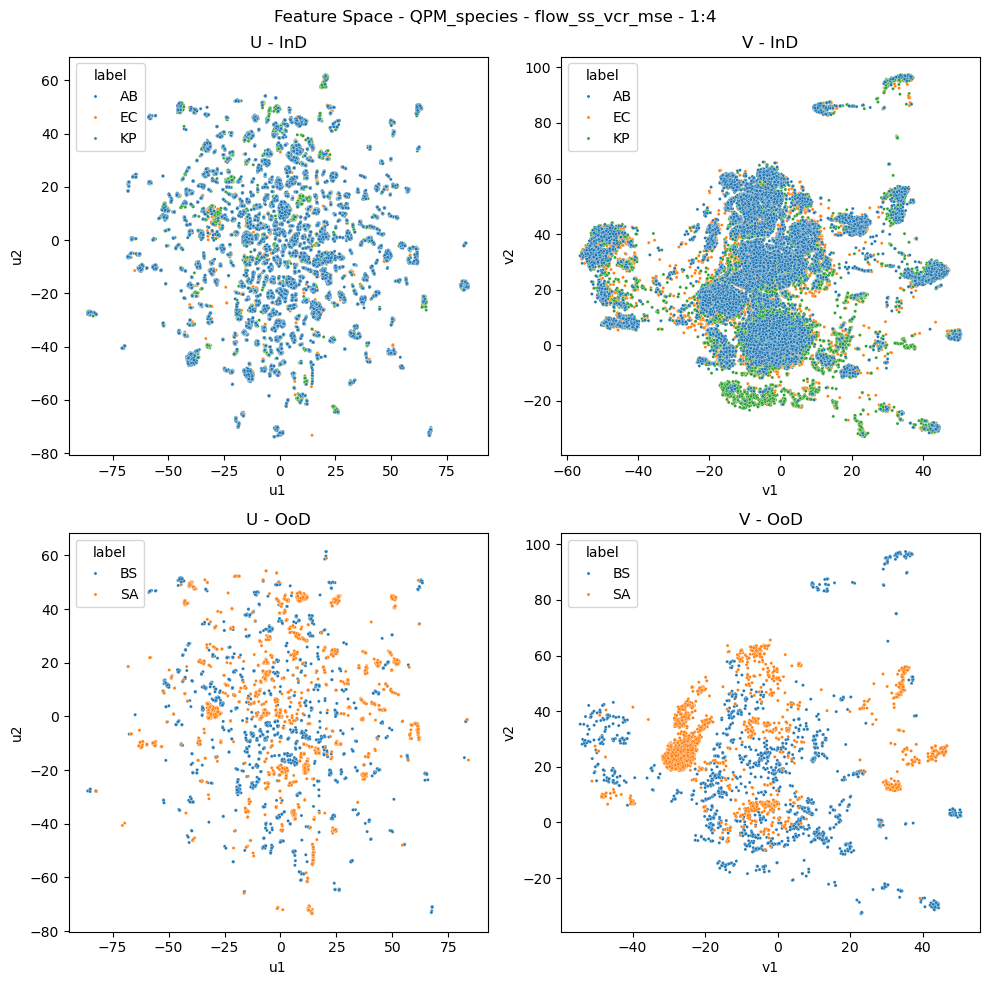

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 1/4 [00:14<00:44, 14.75s/it]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 2/4 [00:29<00:29, 14.82s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3/4 [00:44<00:14, 14.91s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 15.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:00<00:00, 15.00s/it]

  0%|                                                                                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 1/4 [01:35<04:46, 95.55s/it]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 2/4 [03:11<03:11, 95.60s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3/4 [04:46<01:35, 95.68s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:23<00:00, 95.91s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:23<00:00, 95.81s/it]

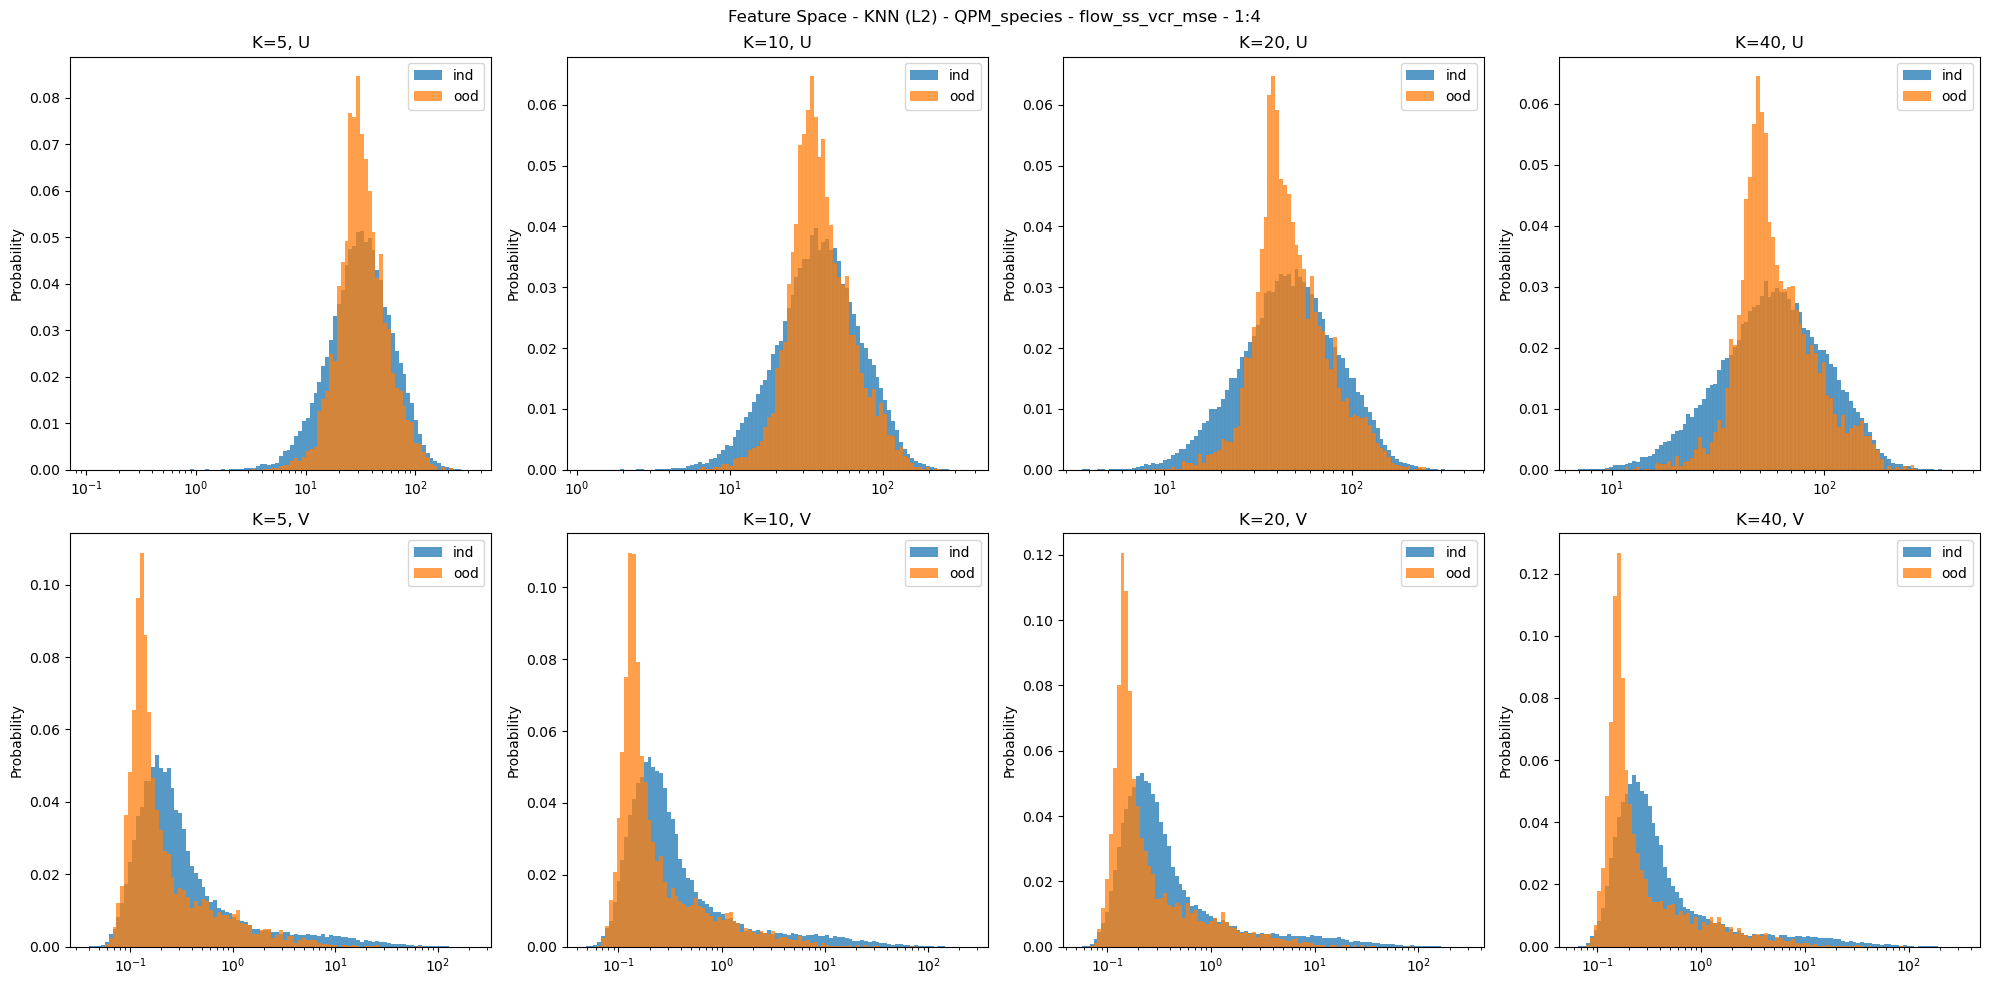

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 1/4 [00:14<00:43, 14.51s/it]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 2/4 [00:29<00:29, 14.55s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3/4 [00:43<00:14, 14.65s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.83s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.74s/it]

  0%|                                                                                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 1/4 [01:35<04:45, 95.01s/it]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 2/4 [03:10<03:10, 95.28s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3/4 [04:45<01:35, 95.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:21<00:00, 95.48s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:21<00:00, 95.38s/it]

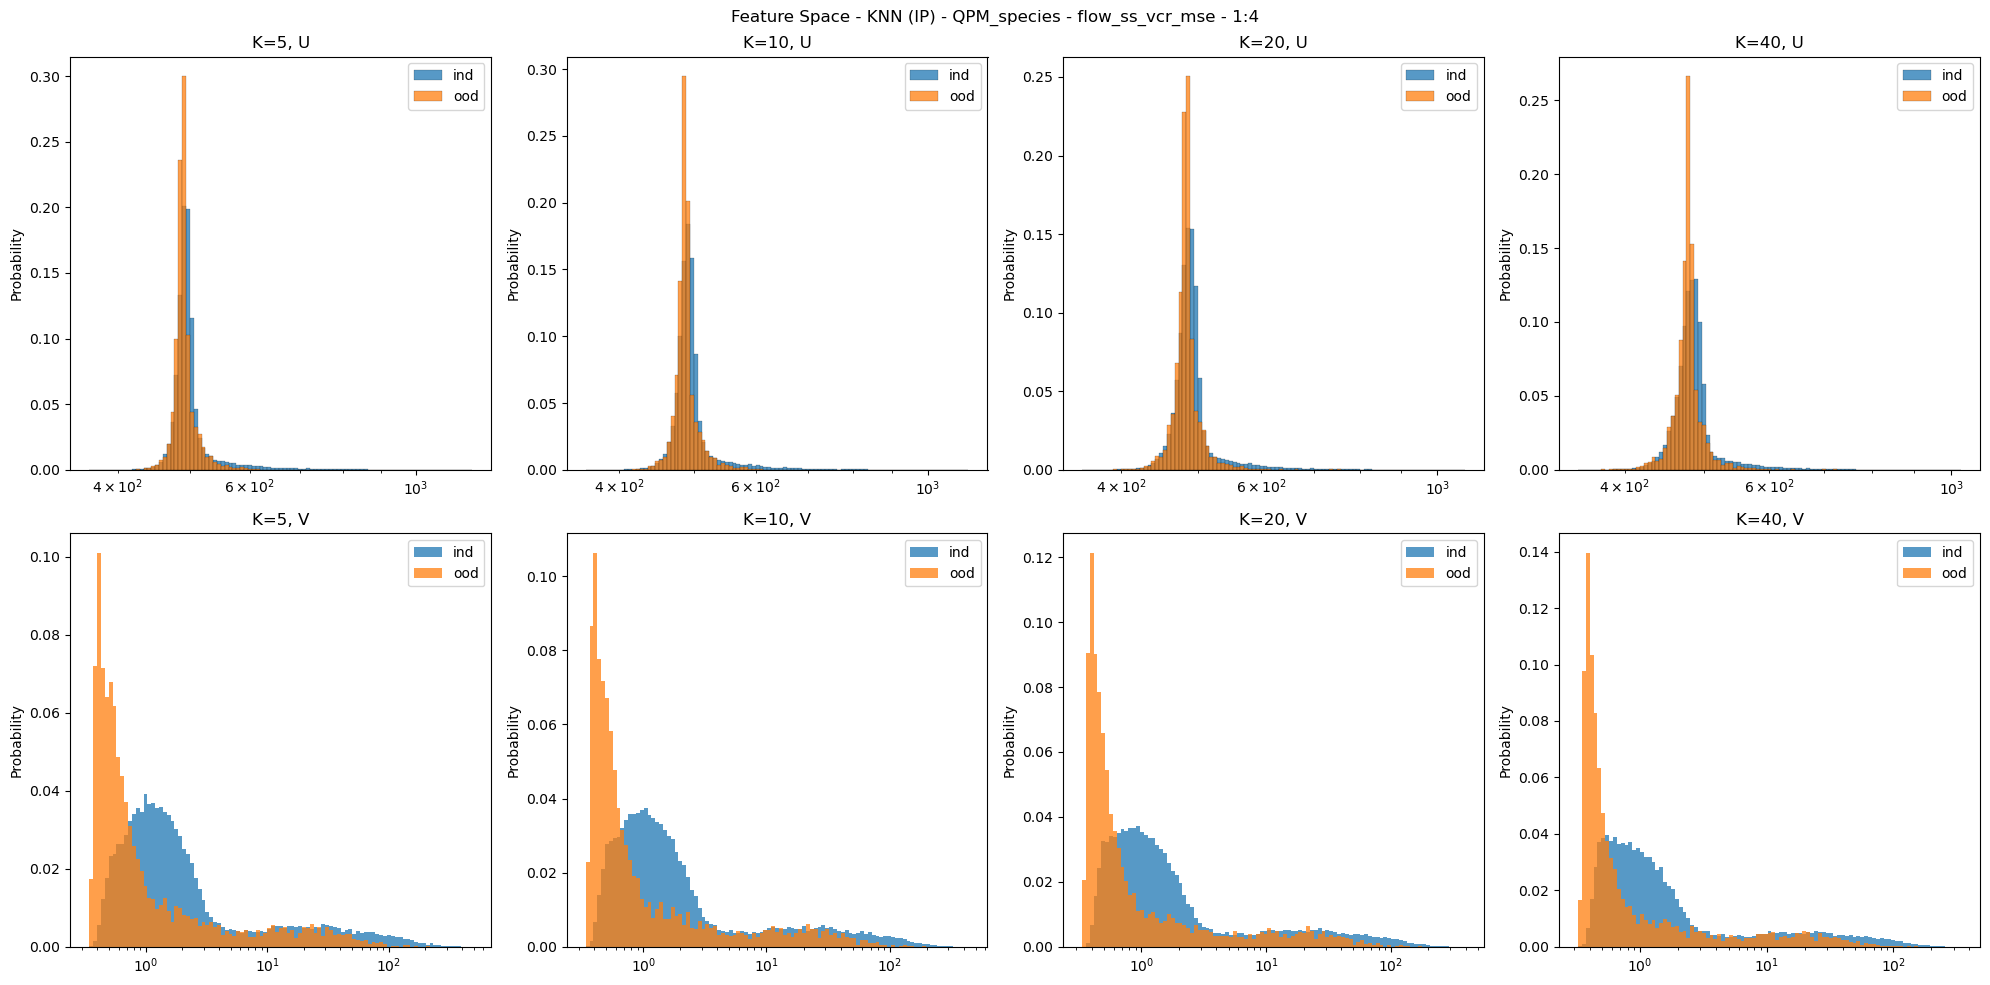

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.72631 0.69076836 1.449675 1.6621493
22.68403 0.62525177 1.347364 1.5071394
22.766285 0.7697436 1.5448488 1.8371581
22.573177 0.35660833 1.062693 1.0273798
33.40082 0.8836351 54.17184 0.7425324


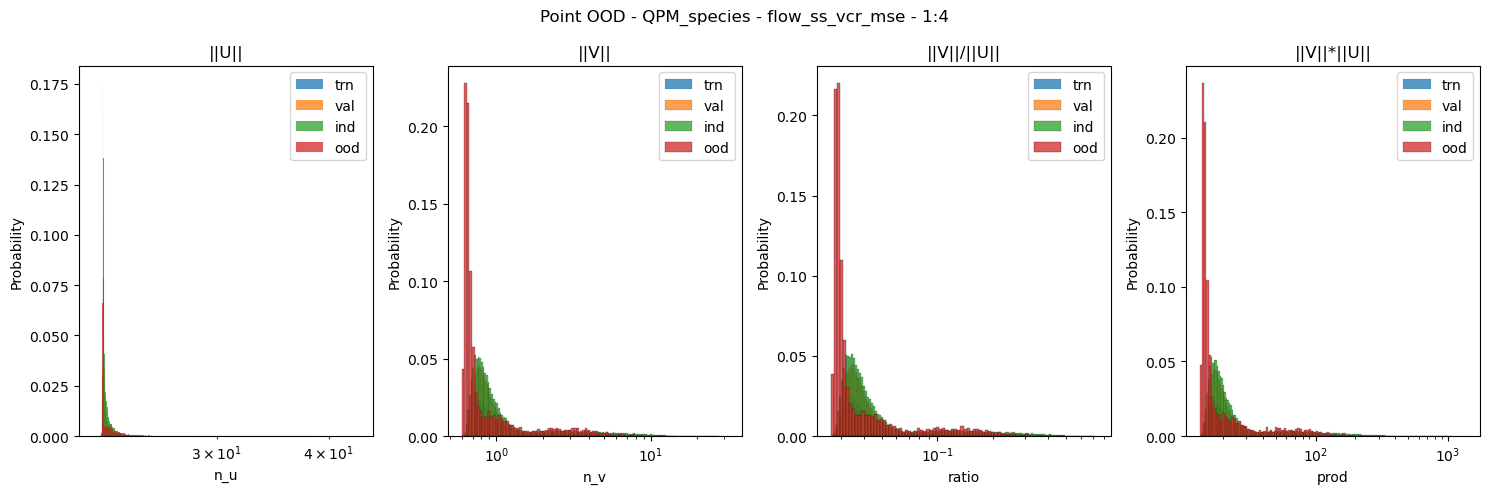

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


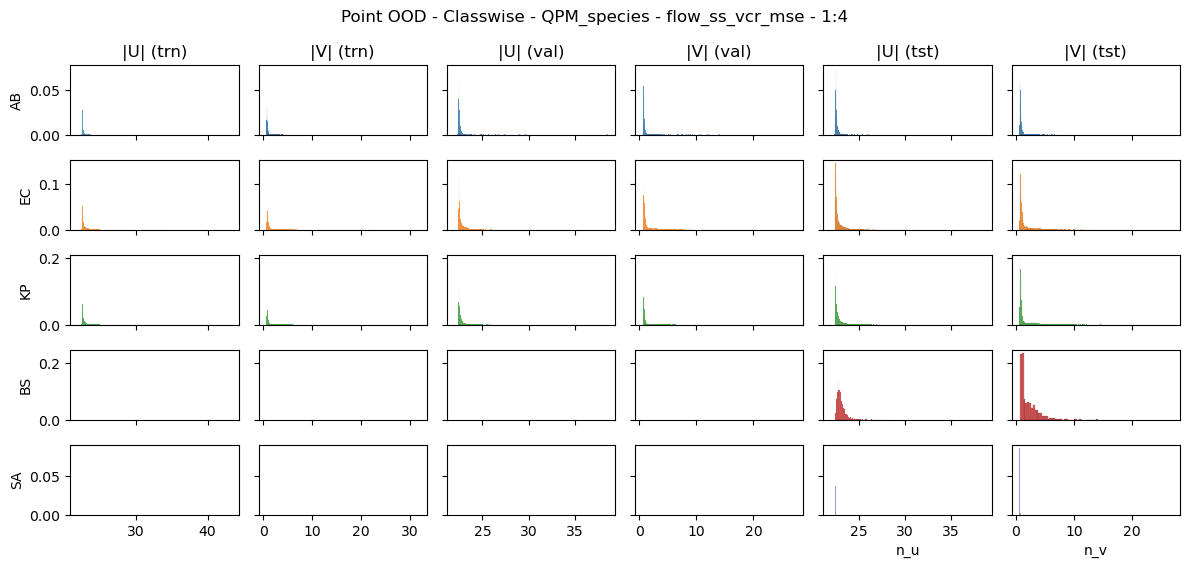

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

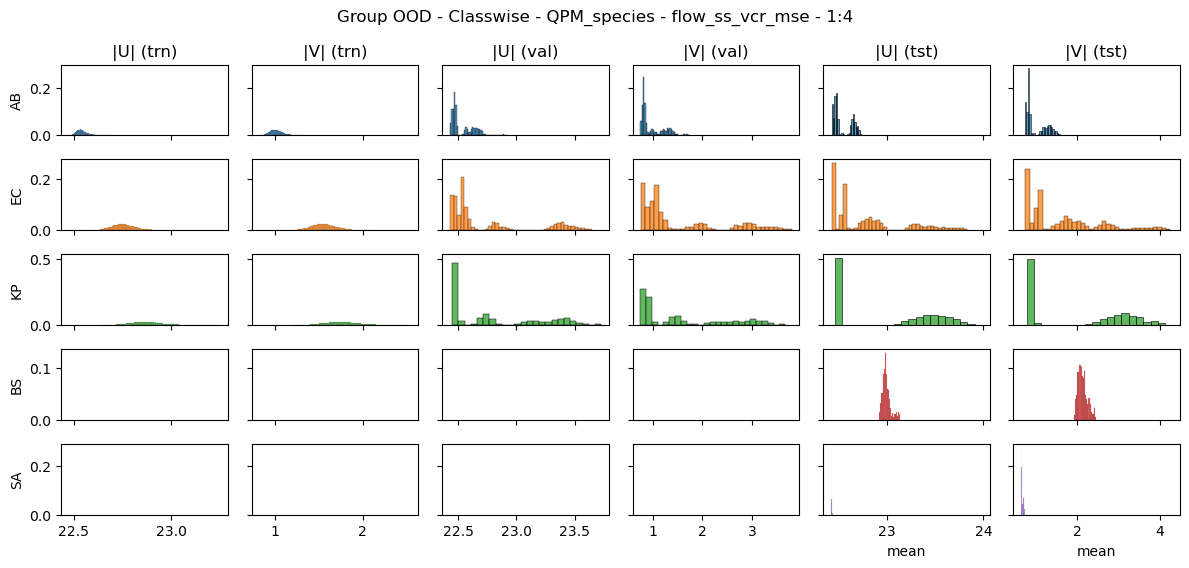

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

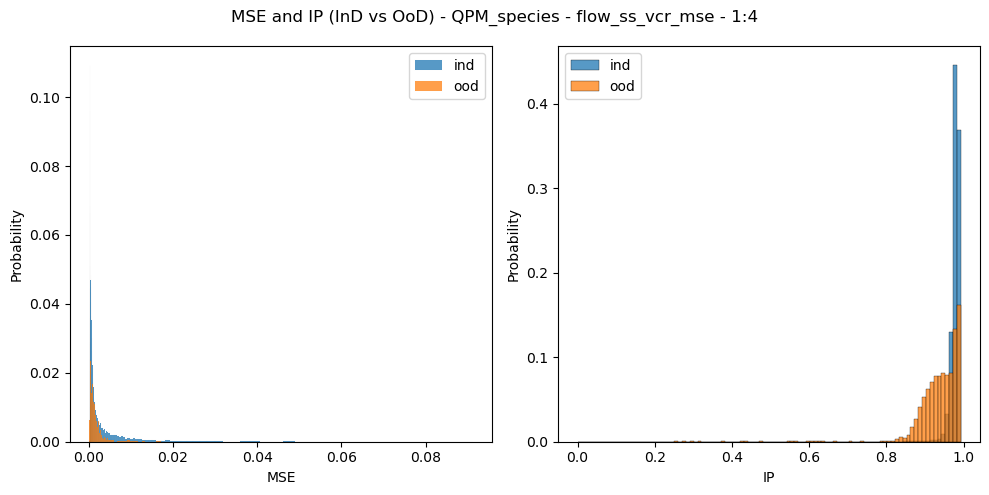

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()